**Stores sale - Time Series Forecasting**  
Kaggle competition  
<https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview>

In [1]:
# !pip install pmdarima
# !pip install pystan==2.19.1.1
# !pip install prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rc('figure', figsize=(20, 10))
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats.stats import pearsonr

from datetime import datetime

In [205]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima
from pmdarima import model_selection

from sklearn.metrics import r2_score, mean_squared_log_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope

import lightgbm as lgbm
from fbprophet import Prophet

from fbprophet.diagnostics import cross_validation,  performance_metrics

from keras.models import load_model
from keras.callbacks import ModelCheckpoint

**1. Load datasets**

In [3]:
%cd C:\Users\Dawid\Desktop\projekty\Store Time Series Forecasting

C:\Users\Dawid\Desktop\projekty\Store Time Series Forecasting


In [4]:
files = sorted(os.listdir('data'))

In [5]:
file_names = ['holidays','oil_prices','sample','stores','df_test','df_train','transactions']

In [6]:
# let read all files, although we won't use sample and df_test dataset
for i in range(len(files)):
    vars()[str(file_names[i])] = pd.read_csv('data/' + files[i])

**2. Preliminary data analysis**

- df_train


In [7]:
df = df_train
df
# The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
# store_nbr identifies the store at which the products are sold.
# family identifies the type of product sold.
# sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
# onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

We would like focus on total sale, so let aggregate date and drop useless columns

In [ ]:
df['date']= pd.to_datetime(df['date'])
df = df.groupby(['date'])['sales'].sum().to_frame()
df = df.asfreq('d').fillna(0)
df

In our date set we have sales beetween 2013-01-01 to 2017-08-15

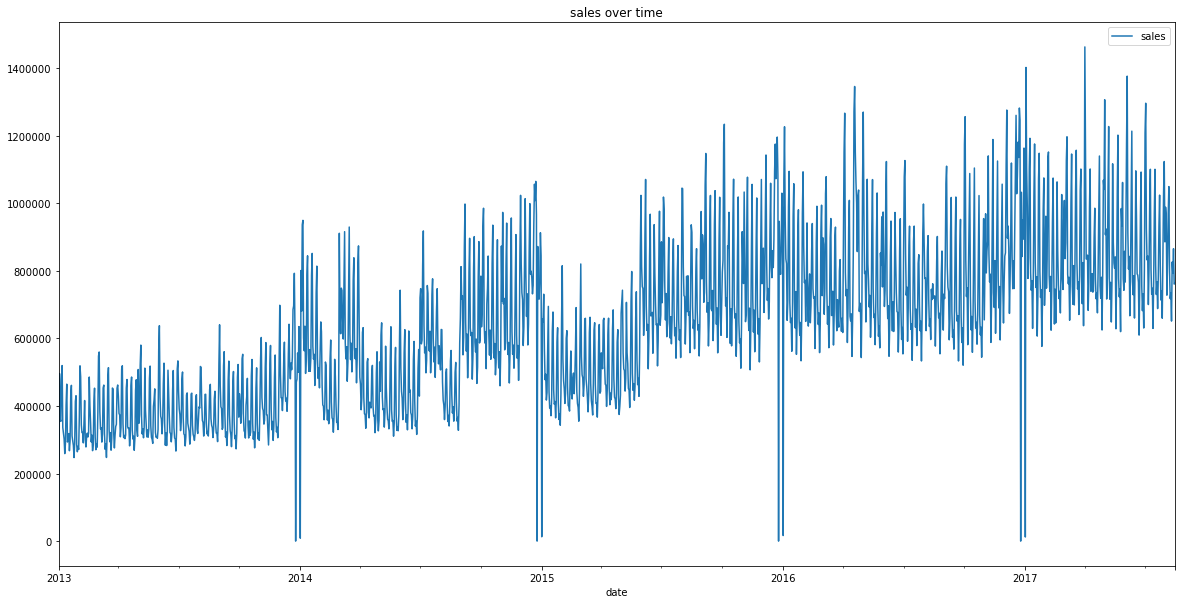

In [9]:
df.plot()
plt.title('sales over time')
plt.ticklabel_format(axis = 'y', useOffset=False, style='plain')
plt.show()

How we can see in sales we have clear trend over those years, and seasional trend near the end of the year

- stores

In [10]:
# we have list of stores, which sale we will predict.
stores.sample(10)

store_nbr           city                           state type  cluster
9          10          Quito                       Pichincha    C       15
30         31       Babahoyo                        Los Rios    B       10
49         50         Ambato                      Tungurahua    A       14
22         23         Ambato                      Tungurahua    D        9
4           5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
46         47          Quito                       Pichincha    A       14
43         44          Quito                       Pichincha    A        5
36         37         Cuenca                           Azuay    D        2
51         52          Manta                          Manabi    A       11
12         13      Latacunga                        Cotopaxi    C       15

In [11]:
# we have 54 different stores
print('number of stores =', stores['store_nbr'].unique().size)

number of stores = 54


In [12]:
# stores are clustered on 17 clusters
print('clusters_number = ', stores['cluster'].value_counts().size)

clusters_number =  17


In [13]:
# stores are distinguished by 5 types
print('types_number = ', stores['type'].value_counts().size)

types_number =  5


- oil prices

In [14]:
# Ecuador market is oil prices dependent so we should take them into consideration
oil_prices.sample(10)

date  dcoilwtico
1140  2017-05-16       48.64
921   2016-07-13       44.87
944   2016-08-15       45.72
462   2014-10-09       85.76
481   2014-11-05       78.71
1204  2017-08-14       47.59
862   2016-04-21       43.18
15    2013-01-22       96.09
909   2016-06-27       45.80
341   2014-04-23      101.47

In [15]:
# let set date as index and fill NaN for empty dates
oil_prices['date'] = pd.to_datetime(oil_prices['date'])
oil_prices = oil_prices.set_index('date').asfreq('d')
oil_prices.fillna(method = 'bfill', inplace = True)
oil_prices.rename(columns = {'dcoilwtico': 'oil_price'}, inplace= True)

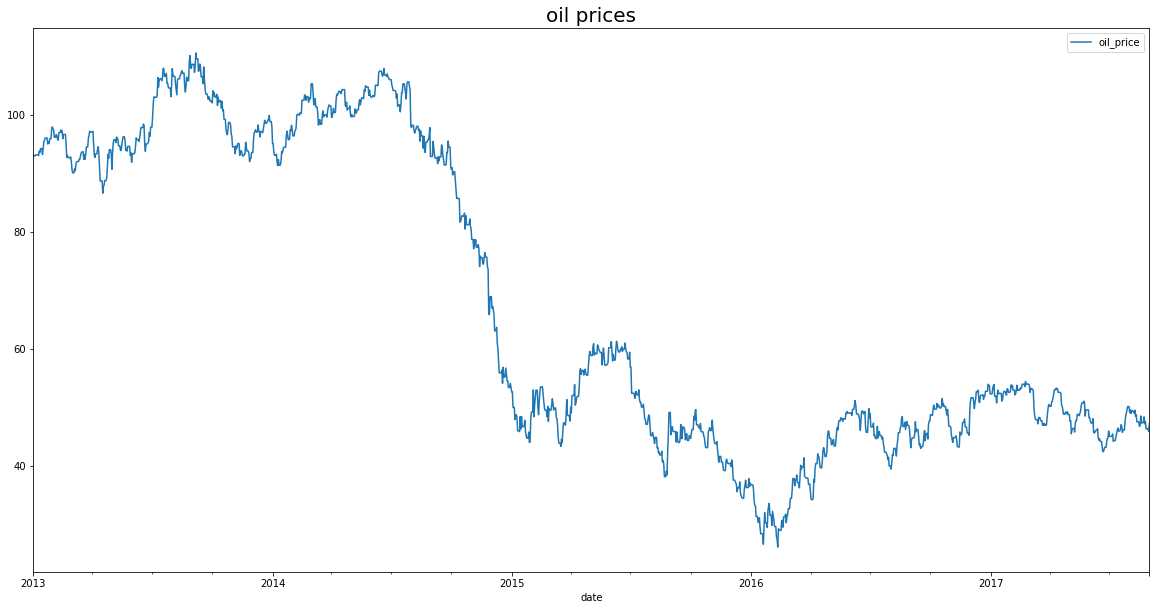

In [16]:
# oil prices over time
oil_prices.plot(figsize = (20,10))
plt.title ('oil prices', size = 20)
plt.show()

<AxesSubplot:xlabel='date'>

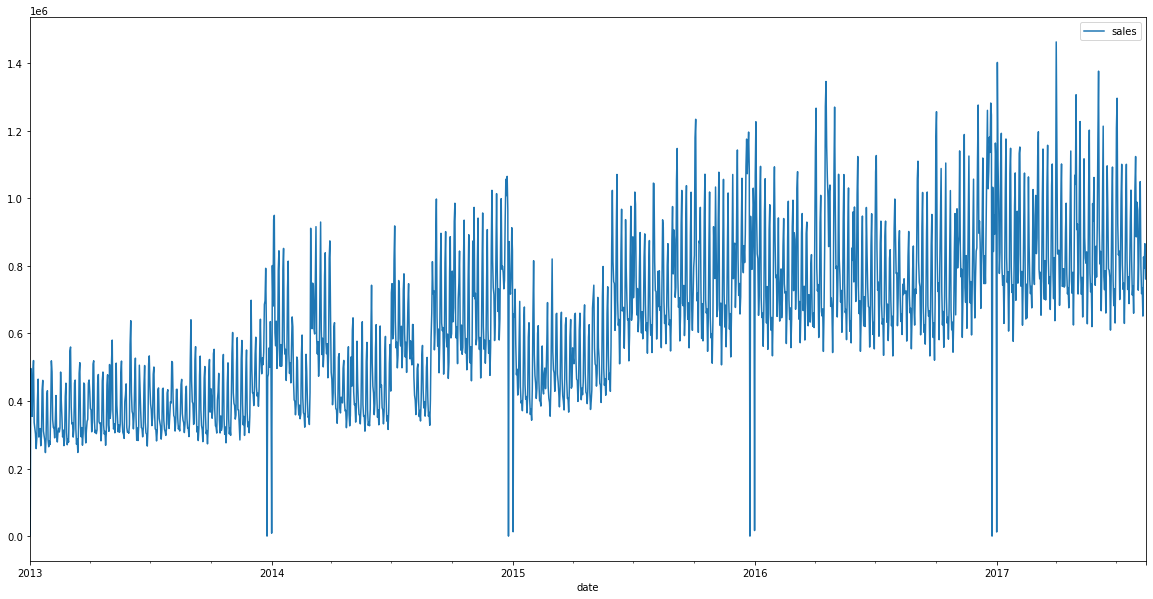

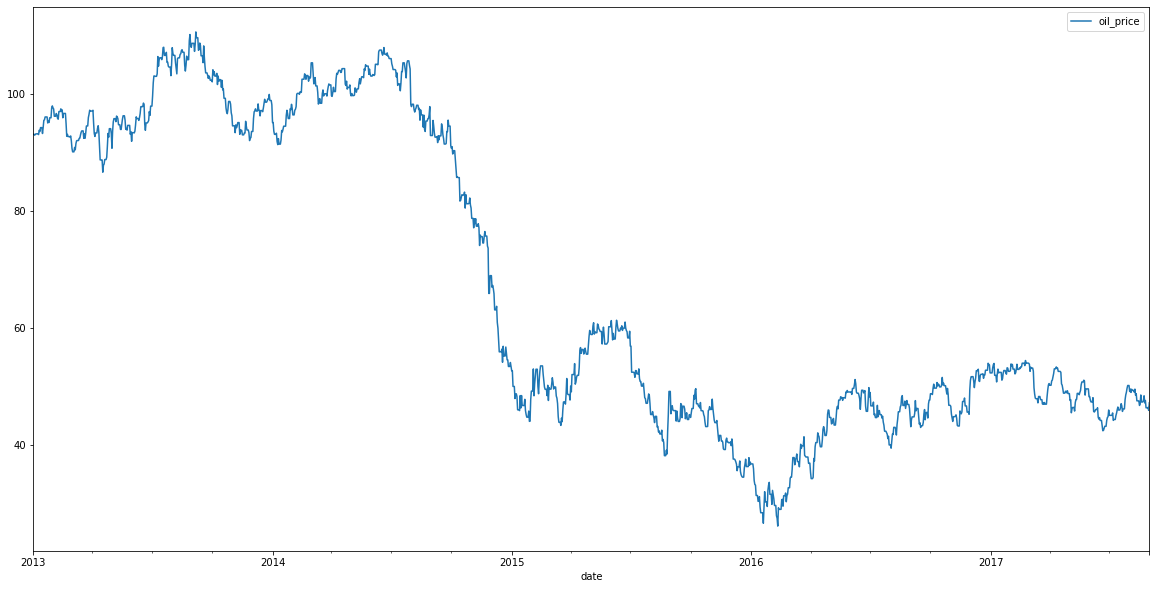

In [17]:
# let's have a look if there is any relation beetween oil prices and sale
df.plot()
oil_prices.plot()

It is difficult to say if there is any relation, based on charts.  
Let's try examine relation between them using correlation function.
We check whether the two variables change in the same direction (positive) or change in different directions (negative), by using covarinace.  
Covariance value of zero indicates that both variables are completely independent.

In [18]:
pearsonr(df['sales'], oil_prices['oil_price'][:len(df)])

(-0.6209175996570805, 1.5700650185277765e-180)

How we can see between those two variables exist, quite strong negative correlation -0.62, with strong significance (p_value) almost 0.

In [19]:
covariance = np.cov(df['sales'], oil_prices['oil_price'][:len(df)])
covariance

array([[ 5.57793817e+10, -3.77009144e+06],
       [-3.77009144e+06,  6.60940145e+02]])

How we can see covariance rate between those two variables are near to zero, what mean that they completely independent.  
It is what we expected.

So we can assume that oil price can affect our sale and we should take it into consideration.

- transactions

In [20]:
# transactions dataset cointain all transactions by store over time, representing as number of transactions
transactions

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

In [21]:
#let aggregate transactions per day
transactions['date'] = pd.to_datetime(transactions['date'])
transactions_agg = transactions.groupby(['date'])['transactions'].sum().to_frame()
trans_agg = transactions_agg.asfreq('d').fillna(0)

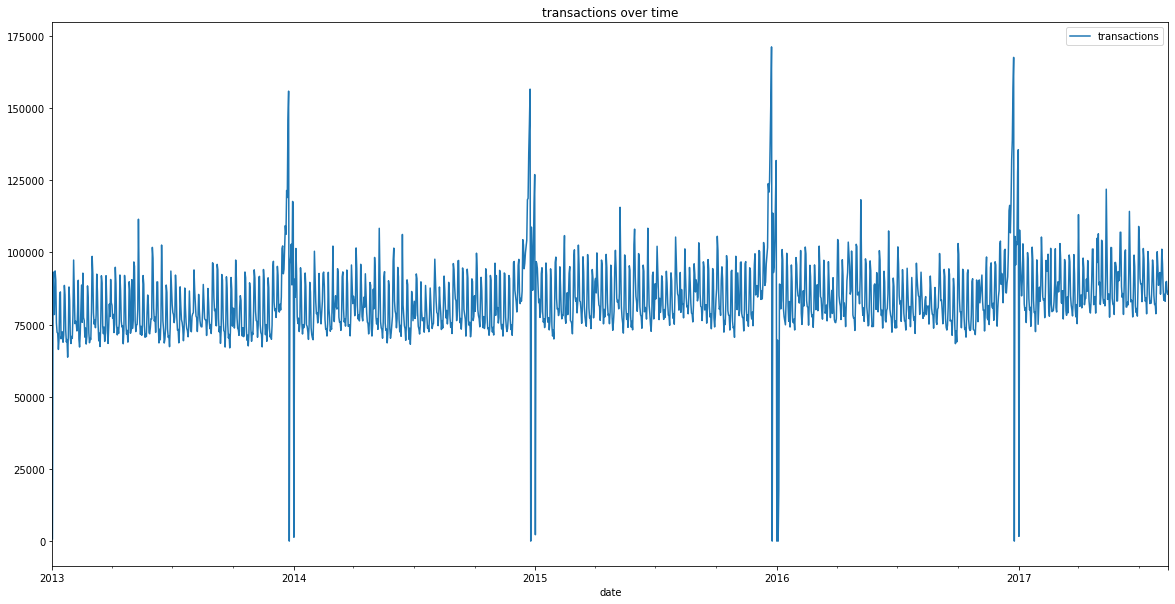

In [22]:
trans_agg.plot()
plt.title('transactions over time')
plt.show()

How we can see number of transactions doesn't have clear trend.  
We can see only seasonal trend at the turn of each year, what is typicall during the Christmas period in retail.

- holidays

In [ ]:
# list of local holidays
holidays.sample(10)

date     type    locale  locale_name  \
160  2015-01-02   Bridge  National      Ecuador   
128  2014-07-25  Holiday     Local    Guayaquil   
288  2016-12-08  Holiday     Local         Loja   
6    2012-06-23  Holiday     Local     Guaranda   
1    2012-04-01  Holiday  Regional     Cotopaxi   
194  2015-11-07  Holiday  Regional  Santa Elena   
311  2017-05-14    Event  National      Ecuador   
344  2017-12-22  Holiday     Local      Salinas   
275  2016-11-02  Holiday  National      Ecuador   
5    2012-05-12  Holiday     Local         Puyo   

                       description  transferred  
160      Puente Primer dia del ano        False  
128         Fundacion de Guayaquil        False  
288              Fundacion de Loja        False  
6        Cantonizacion de Guaranda        False  
1    Provincializacion de Cotopaxi        False  
194  Provincializacion Santa Elena        False  
311                Dia de la Madre        False  
344       Cantonizacion de Salinas        False  
275                Dia de Difuntos        False  
5           Cantonizacion del Puyo        False

In [23]:
#let use only date as an index and add new column [0,1,2,3,4,5] indicate type of holiday, and -1 mean that there wasn't any holidays
holidays['date'] = pd.to_datetime(holidays['date'])
holidays1 = holidays.iloc[:,:2].set_index('date')

le = LabelEncoder()
y = le.fit_transform(holidays1['type'])
holidays1['type'] = y


#delete duplicates 
holidays2 = holidays1.groupby(holidays1.index).first()

holidays_list = holidays2.asfreq('d')
holidays_list.fillna(-1, inplace = True)

In [14]:
print("types description", '\n',
      list(le.classes_), '\n',
      list(le.transform(list(le.classes_))))

types description 
 ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'] 
 [0, 1, 2, 3, 4, 5]


In [ ]:
# we have 312 days off in range beetwen 2012-03-02 to 2017-12-26
holidays_list['type'].value_counts()

-1.0    1814
 3.0     199
 2.0      49
 0.0      45
 4.0      10
 1.0       5
 5.0       4
Name: type, dtype: int64

We can see that mostly we have holiday type 'Holiday' 199 times, then 49 times 'Event' , 45 times 'Additional' etc

**3. Data concatenate**

In [24]:
# let join all probably usefull data
dataset = pd.concat([holidays_list,df,trans_agg, oil_prices ] , axis =1)
dataset.dropna(inplace = True)

**4. Features engineering**

In [25]:
#Let's add some features to our dateset

#day week (1 - Monday, 7 Sunday)
dataset['wday'] = [datetime.weekday(i)+1 for i in dataset.index]

**5. Train/test split**

In [26]:
# let split data set into test and train
treshold = int(len(dataset)*0.8)

train = dataset.iloc[:treshold,:]
test  = dataset.iloc[treshold:,:]

In [18]:
print('train size lenght is: ', len(train), '\n'
     'test_size lenght is: ', len(test))

train size lenght is:  1350 
test_size lenght is:  338


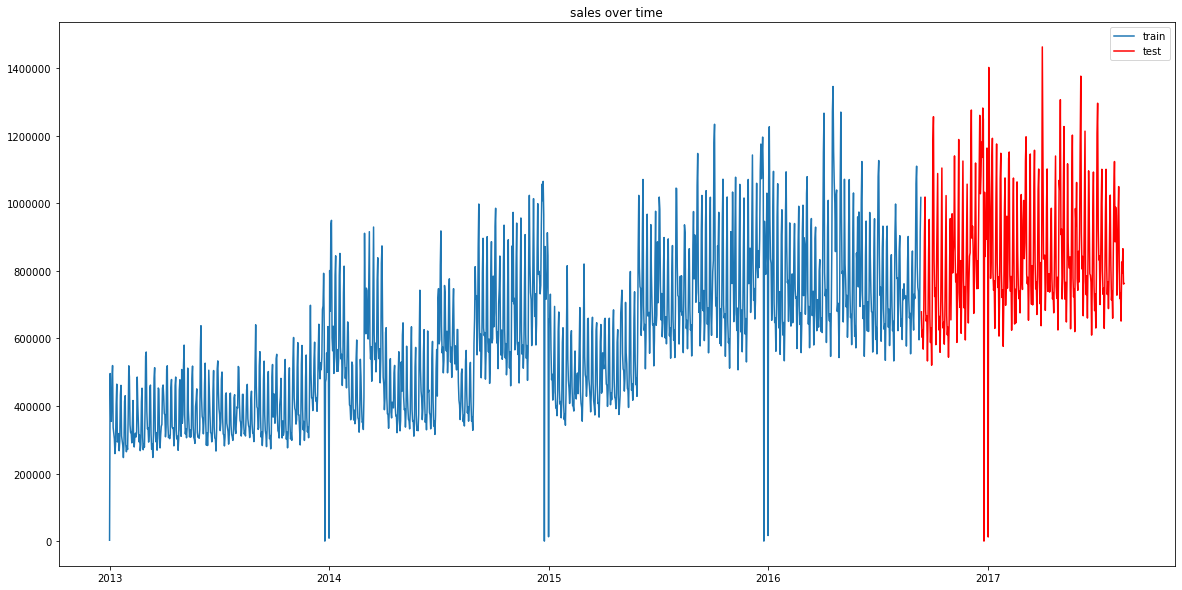

In [ ]:
#plot train and test sale 
plt.plot(train.index, train['sales'], label = 'train')
plt.plot(test.index, test['sales'],color = 'red', label = 'test')
plt.title('sales over time')
plt.ticklabel_format(axis = 'y', useOffset=False, style='plain')
plt.legend()
plt.show()

In [27]:
#let's determine future holidays till the end of 2017 year in case of forecast's need 
holidays_future = holidays_list.loc[holidays_list.index > pd.to_datetime('2017-08-15')]
holidays_future[holidays_future.type >= 0].head()

type
date            
2017-08-24   3.0
2017-09-28   3.0
2017-09-29   4.0
2017-10-07   3.0
2017-10-09   3.0

**6. Stationary test**

In [ ]:
# Let check whether our data is stationary or not

# ADF test for 'sale' variable
result_adf = sts.adfuller(train['sales'])
print('p_value = ', result_adf[1])

p_value =  0.10530064305089226


P value > 0.05 mean that our data isn't stationary.  
In some models we will need to make them stationary, so let's implement some solutions to gain it.

- transforming data to percentage change format, called 'return'

In [28]:
train['sales_ret']= train['sales'].pct_change(1)*100
train['sales_ret']

date
2013-01-01             NaN
2013-01-02    19651.897805
2013-01-03      -27.138328
2013-01-04       -1.937014
2013-01-05       34.669795
                  ...     
2016-09-07       -1.734886
2016-09-08      -19.321074
2016-09-09       10.593237
2016-09-10       38.995692
2016-09-11       11.073960
Freq: D, Name: sales_ret, Length: 1350, dtype: float64

In [21]:
# and let's check again whether data is still stationary or not
# ADF test for 'sales_ret' variable

#first we have to delete or replace inf values
train['sales_ret'] = [1000 if j == np.inf else train['sales_ret'][i] for i,j in enumerate(train['sales_ret'])]

result_adf_1 = sts.adfuller(train['sales_ret'][1:])
print('p_value = ', result_adf_1[1])

p_value =  1.2480915313707583e-26


This way let us to gain stationarity in our data, but let try another method too.

- first order differencing

In [29]:
train['sales_diff'] = train['sales'].diff(1)

In [30]:
# ADF test for 'sales_diff' variable

result_adf_2 = sts.adfuller(train['sales_diff'][1:])
print('p_value = ', result_adf_2[1])

p_value =  4.072269153214223e-14


Thanks to the first order differencing our data is totally stationary

In [31]:
#let create return and 1st order differencing data also for our test dataset
test1 = pd.concat([train.iloc[-1:,:5],test])
test1['sales_ret'] =  test1['sales'].pct_change(1)*100
test1['sales_diff'] =   test1['sales'].diff(1)
test = test1.iloc[1:]

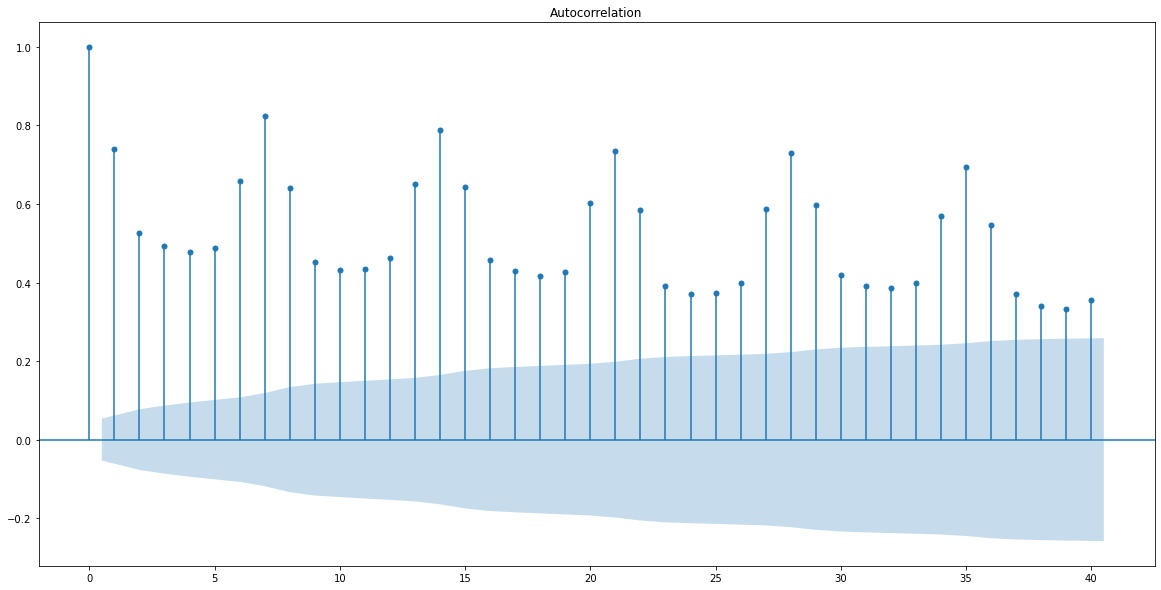

In [ ]:
# Let check if our data isn't white noise or random walk 
sgt.plot_acf(train['sales'], lags = 40)
plt.show()

As we can see all data (till 40 lag) is significant, so we can't consider this data set as a white noise.

*Random walk testing*  
As we know, our data isn't stationary so it can be consider as a random walk,  
so we need to see how autocorrelation for first-order diffence data looks.

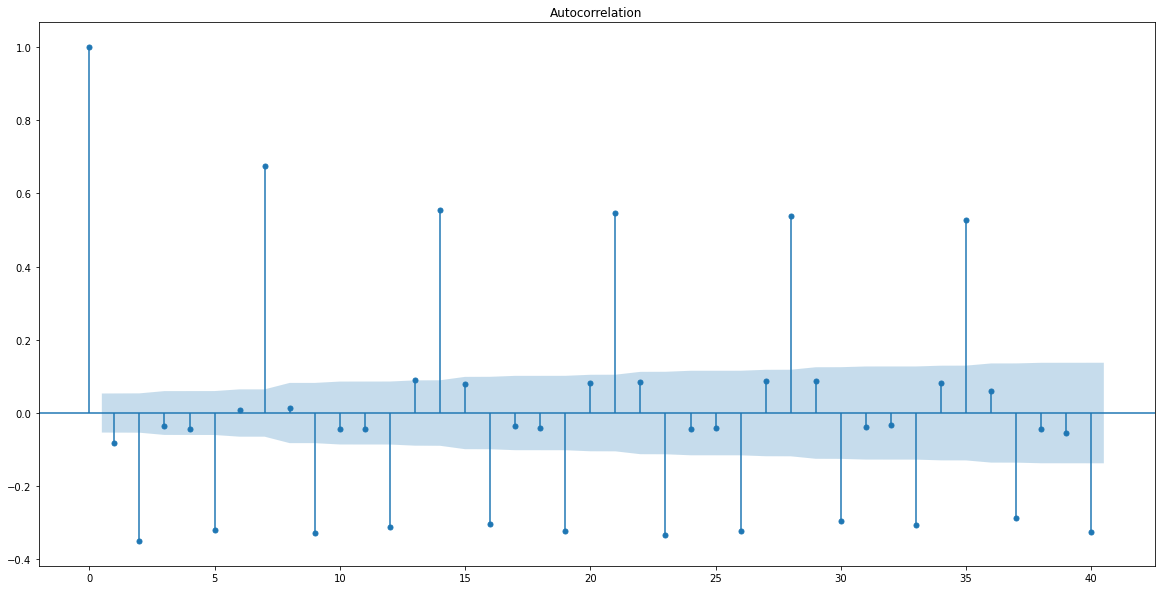

In [ ]:
sgt.plot_acf(train['sales_diff'][1:],lags =40)
plt.show()

Even first-order differenced data isn't random noise, so we can't talk about random walk in our data.  
It is good information, because we can expect that are data are able to be predicted.

In this data we can see that every 7th lag is significant, it tells us about weakly seasonal effects.

To have full view on our data let's check also partial autocorrelation function

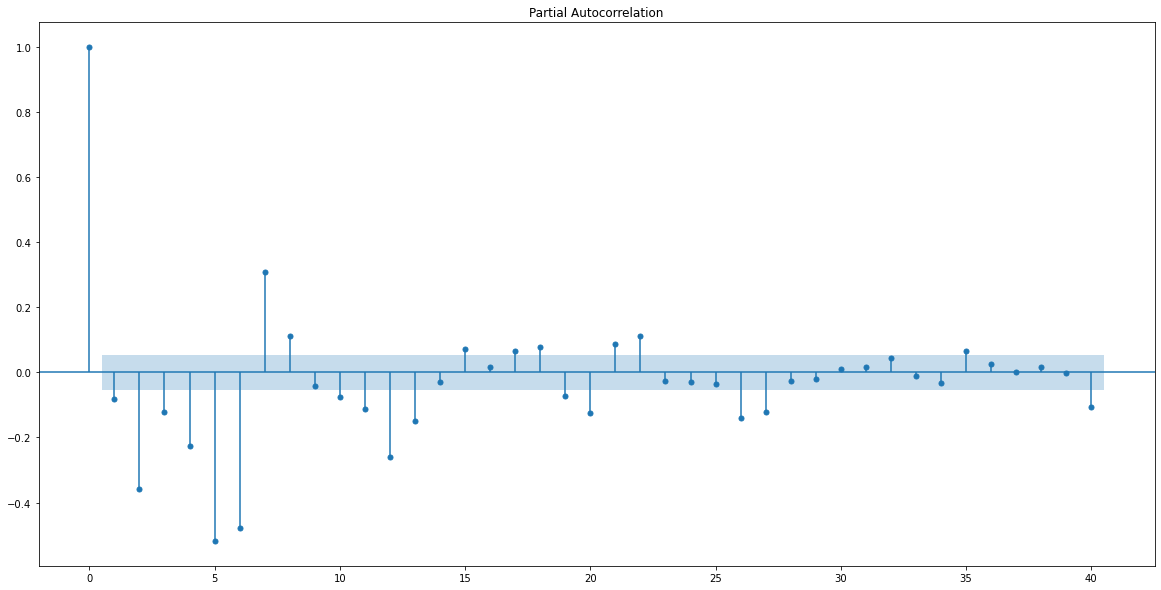

In [ ]:
sgt.plot_pacf(train['sales_diff'][1:], lags = 40, method = 'ols')
plt.show()

According to the results from previous pacf_plot it seems than at least 8 periods before, but also 13th or even 22th lag can be use to predict future sale.
We also check 7 periods, because it is common trend in retail.

**7. Trend decomposition**

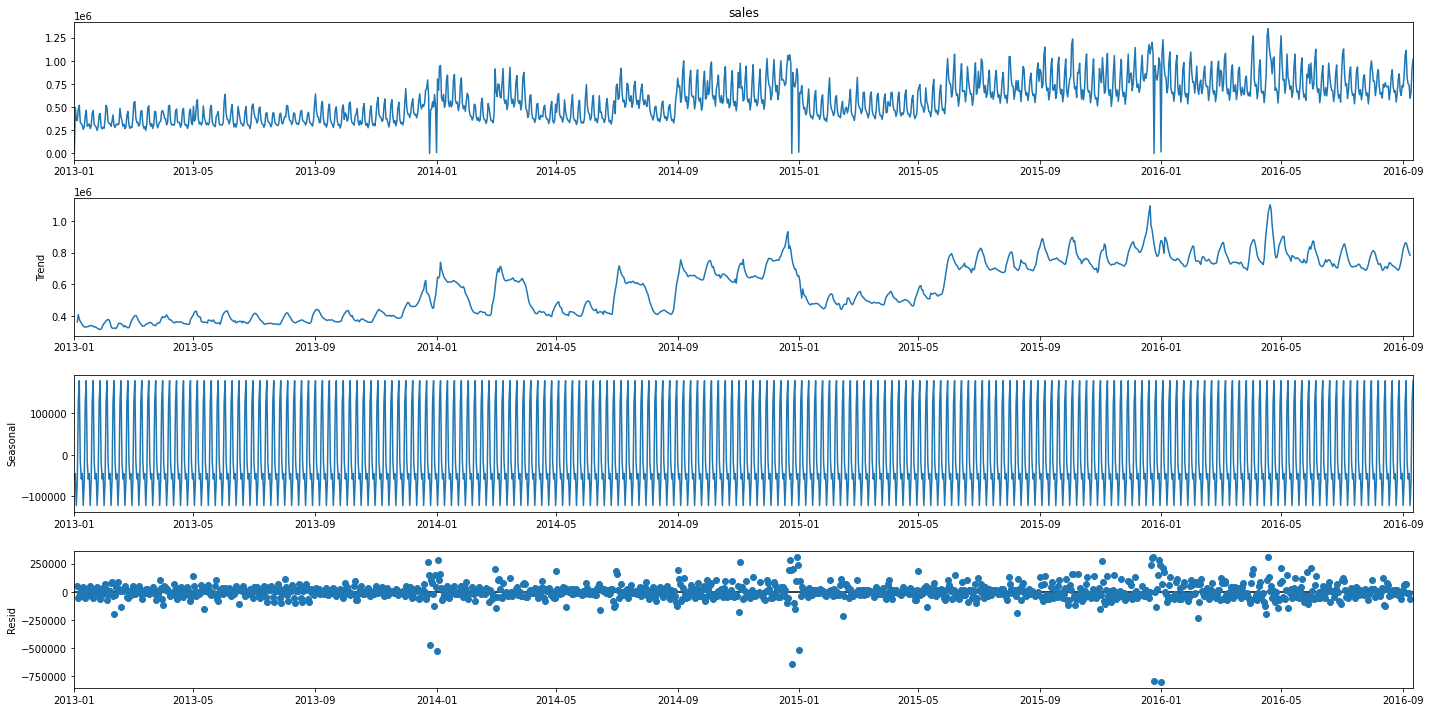

In [27]:
#Let furthermore check trend composition to know what cycles we can noticed

decomp = seasonal_decompose(train['sales'])
decomp.plot()
plt.show()

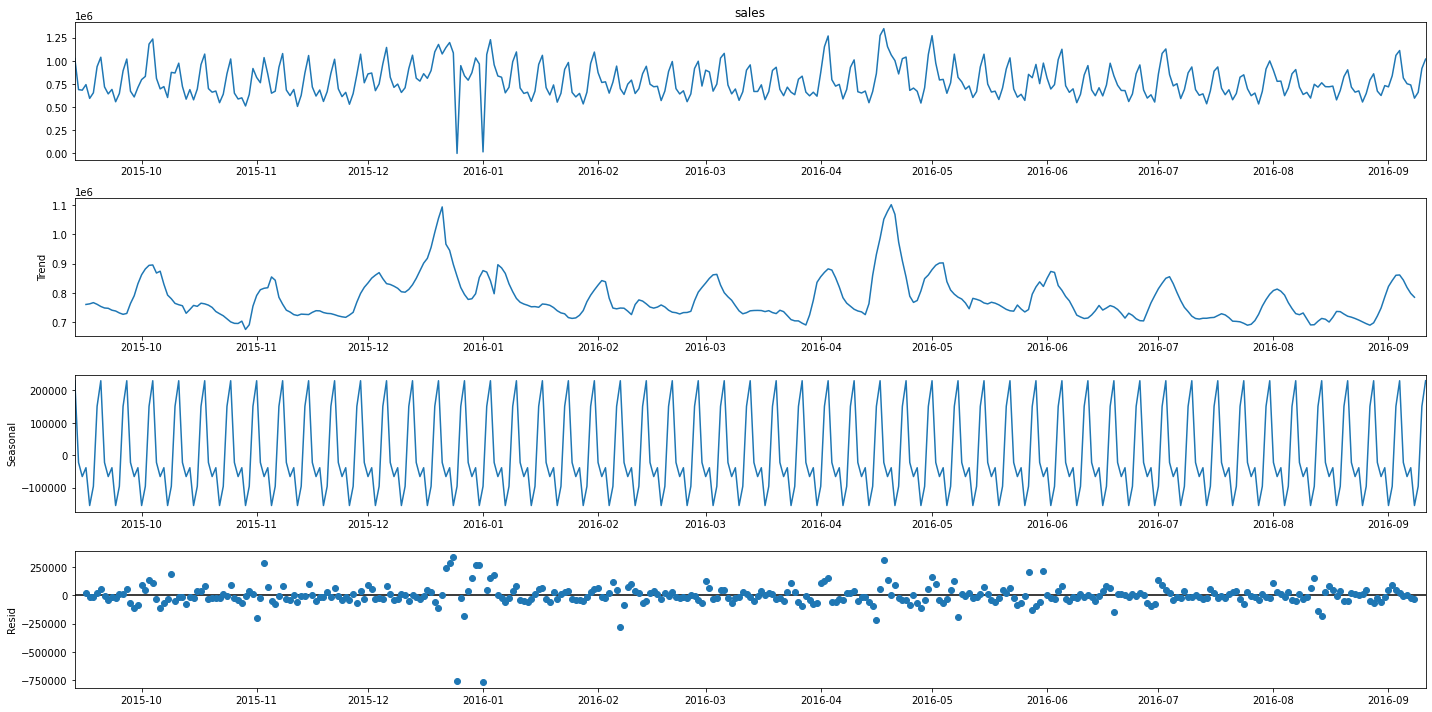

In [ ]:
#only last 12 months
decomp_year = seasonal_decompose(train['sales'][-365:])
decomp_year.plot()
plt.show()

How we can see there is a significant seasonal component in our data, and seasonality pick is four times per month.  
Our residuals errors are close to zero, but at the year turn appear to be bigger than usually.

**8. Modeling**

**- ARMA**

Let's create some simple models to get a banchmark for future improvments.  
First we will rank models by their Log Likelihood ratio.

In [ ]:
#let's create a test to compare simple models
def LLR_test(model1, model2, DF = 1):
    L1 = model1.llf
    L2 = model2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

In [ ]:
# simple ARMA models
model_arma_7_0 = ARMA(train['sales_diff'][1:], order = (7,0)).fit()
model_arma_7_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 0)   Log Likelihood              -17436.943
Method:                       css-mle   S.D. of innovations          99235.384
Date:                Sun, 10 Apr 2022   AIC                          34891.886
Time:                        14:17:25   BIC                          34938.750
Sample:                    01-02-2013   HQIC                         34909.437
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.3036    859.023      0.876      0.381    -931.350    2435.957
ar.L1.sales_diff    -0.4040      0.026    -15.522      0.000      -0.455      -0.353
ar.L2.sales_diff    -0.4926      0.027    -18.266      0.000      -0.545      -0.440
ar.L3.sales_diff    -0.4088      0.028    -14.833      0.000      -0.463      -0.355
ar.L4.sales_diff    -0.4000      0.028    -14.480      0.000      -0.454      -0.346
ar.L5.sales_diff    -0.4502      0.028    -16.360      0.000      -0.504      -0.396
ar.L6.sales_diff    -0.3091      0.027    -11.457      0.000      -0.362      -0.256
ar.L7.sales_diff     0.3107      0.026     11.929      0.000       0.260       0.362
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0051           -0.4809j            1.1142           -0.4290
AR.2           -1.0051           +0.4809j            1.1142            0.4290
AR.3           -0.2401           -1.0168j            1.0447           -0.2869
AR.4           -0.2401           +1.0168j            1.0447            0.2869
AR.5            0.6516           -0.8149j            1.0434           -0.1427
AR.6            0.6516           +0.8149j            1.0434            0.1427
AR.7            2.1820           -0.0000j            2.1820           -0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model_arma_7_1 = ARMA(train['sales_diff'][1:], order = (7,1)).fit()
model_arma_7_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 1)   Log Likelihood              -17431.254
Method:                       css-mle   S.D. of innovations          98815.340
Date:                Sun, 10 Apr 2022   AIC                          34882.507
Time:                        14:17:57   BIC                          34934.578
Sample:                    01-02-2013   HQIC                         34902.008
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.3035    943.304      0.798      0.425   -1096.537    2601.145
ar.L1.sales_diff    -0.2054      0.056     -3.658      0.000      -0.315      -0.095
ar.L2.sales_diff    -0.3806      0.036    -10.455      0.000      -0.452      -0.309
ar.L3.sales_diff    -0.2686      0.043     -6.278      0.000      -0.352      -0.185
ar.L4.sales_diff    -0.2811      0.038     -7.338      0.000      -0.356      -0.206
ar.L5.sales_diff    -0.3320      0.038     -8.780      0.000      -0.406      -0.258
ar.L6.sales_diff    -0.1752      0.041     -4.247      0.000      -0.256      -0.094
ar.L7.sales_diff     0.4102      0.033     12.490      0.000       0.346       0.475
ma.L1.sales_diff    -0.2193      0.058     -3.767      0.000      -0.333      -0.105
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0153           -0.4940j            1.1291           -0.4279
AR.2           -1.0153           +0.4940j            1.1291            0.4279
AR.3           -0.2340           -1.0178j            1.0443           -0.2860
AR.4           -0.2340           +1.0178j            1.0443            0.2860
AR.5            0.6465           -0.8099j            1.0362           -0.1428
AR.6            0.6465           +0.8099j            1.0362            0.1428
AR.7            1.6328           -0.0000j            1.6328           -0.0000
MA.1            4.5593           +0.0000j            4.5593            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
#let create a function that provide us model name and his results, we will use it then in the loop
AR_comp = [7,8,12,15,22]
MA_comp = [1,2,3,5,7]

def model_arma(x,AR_comp, MA_comp,name = 'name'):
    model = ARMA(x, order =(AR_comp, MA_comp))
    result = model.fit()
    return {name: round(result.llf,3)}

In [ ]:
#let's check a few diffent models, whose will gain the best results, according to the Log Likelihood
loop_results = dict()

for ar in AR_comp:
    for ma in MA_comp:
        try:
            x = model_arma(train['sales_diff'][1:], ar, ma, name = 'model_arma_' + str(ar) + '_' + str(ma))
            loop_results.update(x)
            print('model_arma_' + str(ar) +"_" + str(ma))
        except:
            continue

In [ ]:
#let's check a few diffent models, whose will gain the best results, according to the Log Likelihood
loop_results = dict()

for ar in AR_comp:
    for ma in MA_comp:
        try:
            x = model_arma(train['sales_diff'][1:], ar, ma, name = 'model_arma_' + str(ar) + '_' + str(ma))
            loop_results.update(x)
            print('model_arma_' + str(ar) +"_" + str(ma))
        except:
            continue

In [ ]:
#Let check 5 best models
best_arma = pd.DataFrame([loop_results]).T.rename(columns = {0: 'result'})
best_arma.sort_values(by = 'result', ascending = False).head(5)

result
model_arma_12_7 -17288.971
model_arma_8_7  -17301.937
model_arma_7_7  -17302.503
model_arma_22_2 -17312.784
model_arma_22_1 -17313.038

How we can see best models has mostly 7 MA lags, and more AR lags then better, but not too many, because models don't perform much better and their computation last very long.  
But let's check if all coefitents are significant

In [ ]:
model_arma_12_7 = ARMA(train['sales_diff'][1:], order = (12,7))
results_arma_12_7 = model_arma_12_7.fit()
results_arma_12_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                    ARMA(12, 7)   Log Likelihood              -17288.971
Method:                       css-mle   S.D. of innovations          88126.409
Date:                Sun, 10 Apr 2022   AIC                          34619.941
Time:                        19:37:15   BIC                          34729.291
Sample:                    01-02-2013   HQIC                         34660.894
                         - 09-11-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               752.2965      0.135   5566.468      0.000     752.032     752.561
ar.L1.sales_diff     -0.3440        nan        nan        nan         nan         nan
ar.L2.sales_diff     -0.3651   1.82e-05  -2.01e+04      0.000      -0.365      -0.365
ar.L3.sales_diff     -0.5155   2.87e-05  -1.79e+04      0.000      -0.516      -0.515
ar.L4.sales_diff     -0.0022   2.53e-05    -86.345      0.000      -0.002      -0.002
ar.L5.sales_diff     -0.6492        nan        nan        nan         nan         nan
ar.L6.sales_diff     -0.0427   1.31e-06  -3.27e+04      0.000      -0.043      -0.043
ar.L7.sales_diff      0.5653        nan        nan        nan         nan         nan
ar.L8.sales_diff      0.1495   7.33e-05   2040.267      0.000       0.149       0.150
ar.L9.sales_diff      0.1303   6.11e-06   2.13e+04      0.000       0.130       0.130
ar.L10.sales_diff     0.1137   5.72e-05   1987.744      0.000       0.114       0.114
ar.L11.sales_diff    -0.0583   5.15e-05  -1133.929      0.000      -0.058      -0.058
ar.L12.sales_diff     0.1400        nan        nan        nan         nan         nan
ma.L1.sales_diff     -0.1940      0.023     -8.258      0.000      -0.240      -0.148
ma.L2.sales_diff      0.0149      0.021      0.720      0.472      -0.026       0.055
ma.L3.sales_diff      0.2598      0.019     13.618      0.000       0.222       0.297
ma.L4.sales_diff     -0.3894      0.014    -28.733      0.000      -0.416      -0.363
ma.L5.sales_diff      0.5227      0.016     32.572      0.000       0.491       0.554
ma.L6.sales_diff     -0.4565      0.022    -20.686      0.000      -0.500      -0.413
ma.L7.sales_diff     -0.5260      0.026    -20.520      0.000      -0.576      -0.476
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0329           -0.0000j            1.0329           -0.5000
AR.2            -1.0580           -0.4585j            1.1531           -0.4349
AR.3            -1.0580           +0.4585j            1.1531            0.4349
AR.4            -0.2226           -0.9749j            1.0000           -0.2857
AR.5            -0.2226           +0.9749j            1.0000            0.2857
AR.6            -0.2876           -1.3143j            1.3454           -0.2843
AR.7            -0.2876           +1.3143j            1.3454            0.2843
AR.8             0.6236           -0.7818j            1.0000           -0.1428
AR.9             0.6236           +0.7818j            1.0000            0.1428
AR.10            1.1879           -0.0000j            1.1879           -0.0000
AR.11            1.0753           -1.1232j            1.5550           -0.1285
AR.12            1.0753           +1.1232j            1.5550            0.1285

In this model we got some Nan's in summary, it can mean that our model isn't right for our predictions, and there is a problem with model converge

In [ ]:
model_arma_8_7 = ARMA(train['sales_diff'][1:], order = (8,7))
results_arma_8_7 = model_arma_8_7.fit()
results_arma_8_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(8, 7)   Log Likelihood              -17301.976
Method:                       css-mle   S.D. of innovations          89549.261
Date:                Sun, 24 Apr 2022   AIC                          34637.952
Time:                        20:10:26   BIC                          34726.473
Sample:                    01-02-2013   HQIC                         34671.104
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.2938    448.345      1.678      0.093    -126.446    1631.034
ar.L1.sales_diff    -0.3960      0.078     -5.048      0.000      -0.550      -0.242
ar.L2.sales_diff    -0.4730      0.047    -10.149      0.000      -0.564      -0.382
ar.L3.sales_diff    -0.5467      0.059     -9.294      0.000      -0.662      -0.431
ar.L4.sales_diff    -0.3164      0.056     -5.626      0.000      -0.427      -0.206
ar.L5.sales_diff    -0.6592      0.045    -14.551      0.000      -0.748      -0.570
ar.L6.sales_diff    -0.2696      0.066     -4.108      0.000      -0.398      -0.141
ar.L7.sales_diff     0.3704      0.040      9.341      0.000       0.293       0.448
ar.L8.sales_diff     0.0228      0.034      0.670      0.503      -0.044       0.089
ma.L1.sales_diff    -0.1485      0.077     -1.921      0.055      -0.300       0.003
ma.L2.sales_diff     0.1076      0.068      1.571      0.116      -0.027       0.242
ma.L3.sales_diff     0.2126      0.060      3.572      0.000       0.096       0.329
ma.L4.sales_diff    -0.1718      0.059     -2.934      0.003      -0.287      -0.057
ma.L5.sales_diff     0.3948      0.053      7.421      0.000       0.291       0.499
ma.L6.sales_diff    -0.2896      0.058     -4.963      0.000      -0.404      -0.175
ma.L7.sales_diff    -0.5338      0.063     -8.531      0.000      -0.656      -0.411
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -0.7818j            1.0001           -0.1428
AR.2            0.6237           +0.7818j            1.0001            0.1428
AR.3           -0.2230           -0.9758j            1.0010           -0.2858
AR.4           -0.2230           +0.9758j            1.0010            0.2858
AR.5           -1.0849           -0.3757j            1.1481           -0.4469
AR.6           -1.0849           +0.3757j            1.1481            0.4469
AR.7            1.9712           -0.0000j            1.9712           -0.0000
AR.8          -16.8672           -0.0000j           16.8672           -0.5000
MA.1            1.1118           -0.0000j            1.1118           -0.0000
MA.2            0.6288           -0.7879j            1.0081           -0.1428
MA.3            0.6288           +0.7879j            1.0081            0.1428
MA.4           -0.2272           -0.9987j            1.0242           -0.2856
MA.5           -0.2272           +0.9987j            1.0242            0.2856
MA.6           -1.2288           -0.2648j            1.2571           -0.4662
MA.7           -1.2288           +0.2648j            1.2571            0.4662
-----------------------------------------------------------------------------
"""

In this model last AR coeficient isn't significant, so let try model ARMA(7,7)

In [ ]:
model_arma_7_7 = ARMA(train['sales_diff'][1:], order = (7,7))
results_arma_7_7 = model_arma_7_7.fit()
results_arma_7_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 7)   Log Likelihood              -17302.207
Method:                       css-mle   S.D. of innovations          89586.373
Date:                Sun, 24 Apr 2022   AIC                          34636.415
Time:                        20:07:57   BIC                          34719.728
Sample:                    01-02-2013   HQIC                         34667.617
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.2461    453.985      1.657      0.098    -137.548    1642.040
ar.L1.sales_diff    -0.3600      0.087     -4.152      0.000      -0.530      -0.190
ar.L2.sales_diff    -0.4903      0.045    -10.824      0.000      -0.579      -0.402
ar.L3.sales_diff    -0.5333      0.074     -7.202      0.000      -0.678      -0.388
ar.L4.sales_diff    -0.3290      0.060     -5.451      0.000      -0.447      -0.211
ar.L5.sales_diff    -0.6557      0.057    -11.463      0.000      -0.768      -0.544
ar.L6.sales_diff    -0.2677      0.081     -3.302      0.001      -0.427      -0.109
ar.L7.sales_diff     0.3585      0.043      8.359      0.000       0.274       0.443
ma.L1.sales_diff    -0.1813      0.088     -2.069      0.039      -0.353      -0.010
ma.L2.sales_diff     0.1377      0.058      2.371      0.018       0.024       0.252
ma.L3.sales_diff     0.1900      0.057      3.311      0.001       0.078       0.303
ma.L4.sales_diff    -0.1480      0.055     -2.684      0.007      -0.256      -0.040
ma.L5.sales_diff     0.3825      0.065      5.873      0.000       0.255       0.510
ma.L6.sales_diff    -0.2950      0.068     -4.325      0.000      -0.429      -0.161
ma.L7.sales_diff    -0.5042      0.069     -7.262      0.000      -0.640      -0.368
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0804           -0.3909j            1.1490           -0.4448
AR.2           -1.0804           +0.3909j            1.1490            0.4448
AR.3           -0.2231           -0.9762j            1.0014           -0.2858
AR.4           -0.2231           +0.9762j            1.0014            0.2858
AR.5            0.6237           -0.7818j            1.0001           -0.1428
AR.6            0.6237           +0.7818j            1.0001            0.1428
AR.7            2.1064           -0.0000j            2.1064           -0.0000
MA.1            1.1173           -0.0000j            1.1173           -0.0000
MA.2            0.6290           -0.7882j            1.0085           -0.1428
MA.3            0.6290           +0.7882j            1.0085            0.1428
MA.4           -0.2284           -1.0035j            1.0292           -0.2856
MA.5           -0.2284           +1.0035j            1.0292            0.2856
MA.6           -1.2518           -0.2842j            1.2837           -0.4645
MA.7           -1.2518           +0.2842j            1.2837            0.4645
-----------------------------------------------------------------------------
"""

In [ ]:
LLR_test(results_arma_7_7, results_arma_8_7, DF = 1)

0.287

Neverthless we will call our model ARMA(8,7) as our current benchmark with following results

In [ ]:
arma_pred = results_arma_8_7.predict(test.index[0],test.index[-1])
arma_train_pred = results_arma_8_7.predict(train.index[1],train.index[-1])

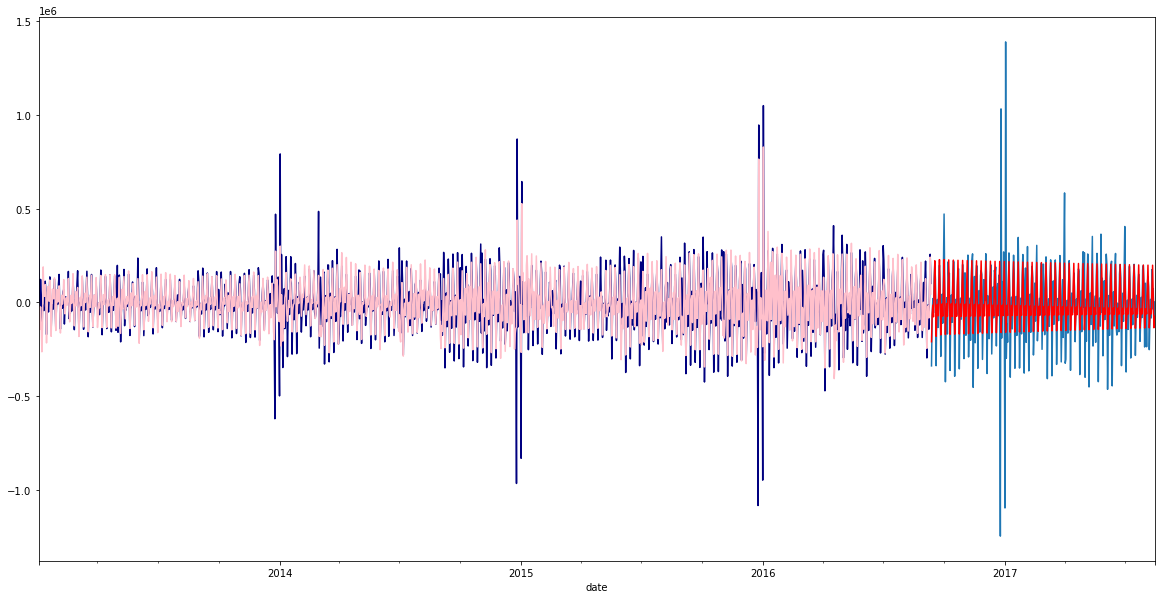

In [ ]:
test['sales_diff'].plot()
train['sales_diff'][1:].plot(color= 'navy')
arma_pred.plot(color = 'red')
arma_train_pred.plot(color = 'pink')

plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train['sales_diff'][1:], arma_train_pred),3))
print('R2 score test is: ', round(r2_score(test['sales_diff'], arma_pred),3))

R2 score train is:  0.659
R2 score test is:  0.343


So our first simple model has 0.659 on train set and 0.343 R2 score on test set.  
Let's improve it!

**- SARIMA**

 a) model decompose (on stationary data)

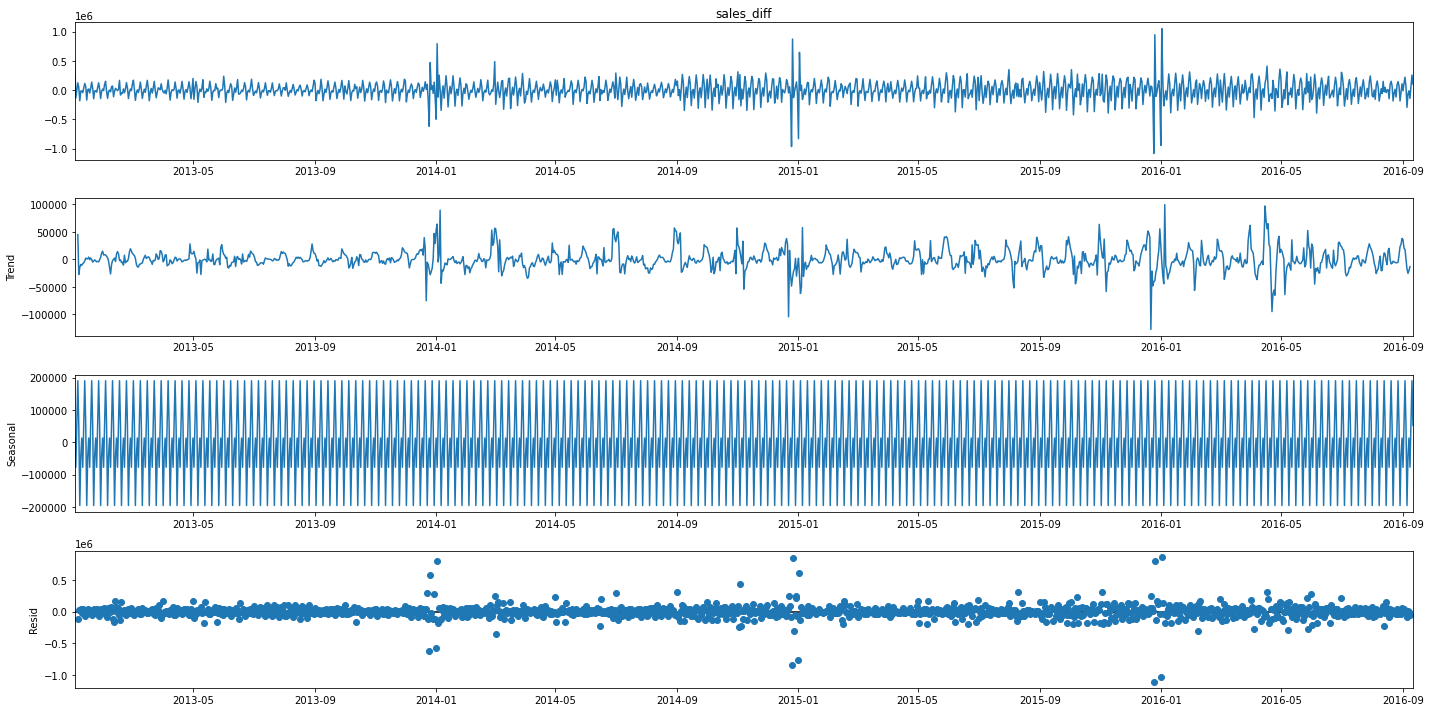

In [ ]:
decomp_stat = seasonal_decompose(train['sales_diff'][1:])
decomp_stat.plot()
plt.show()

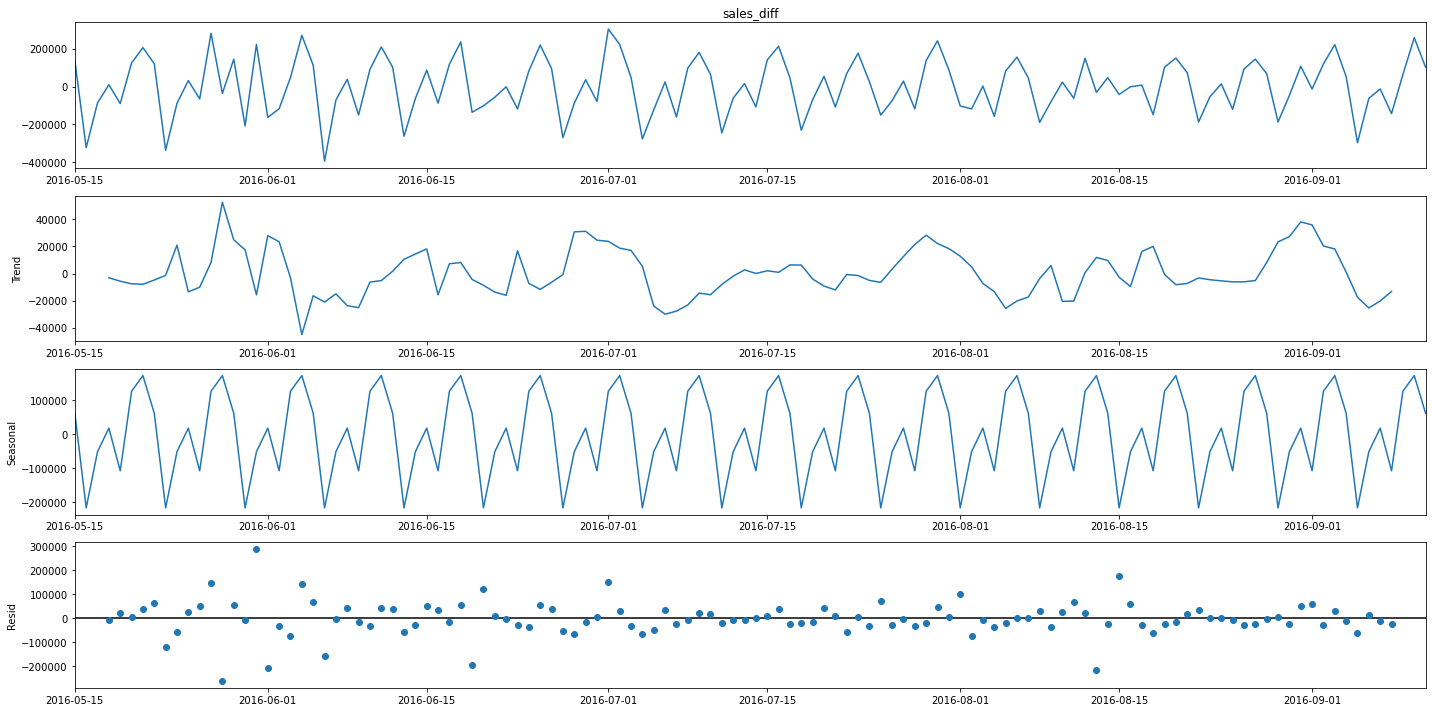

In [ ]:
#let's see trend also for last 4 months
seasonal_decompose(train['sales_diff'][-120:]).plot()
plt.show()

It seems to be weekly seasonal cycle.

b) stationarity test on seasonal data (also stationary)

In [ ]:
# Let's use our decomposed trend and check wheter it is stationary
seasonal_adf = sts.adfuller(decomp_stat.seasonal)
print('p_value = ', seasonal_adf[1])

p_value =  0.9585320860598848


It's looks like our seasonal data isn't stationary, so we should do seasonal differencing

In [32]:
#Let's make our seasonal data stationary too
train['seasonal_diff'] = train['sales_diff'].diff(7).dropna()

#let's do the same with our test data in case of future use
test2 = pd.concat([train.iloc[-8:,:7],test])
test['seasonal_diff'] = test2['sales_diff'].diff(7).dropna()

In [ ]:
seasonal_diff_adf = sts.adfuller(train['seasonal_diff'].dropna())
print('p_value = ', seasonal_diff_adf[1])

p_value =  2.0441673862320492e-23


Both our main data and seasonal data are now stationary.  
Let choose right model components

c) components choosing 

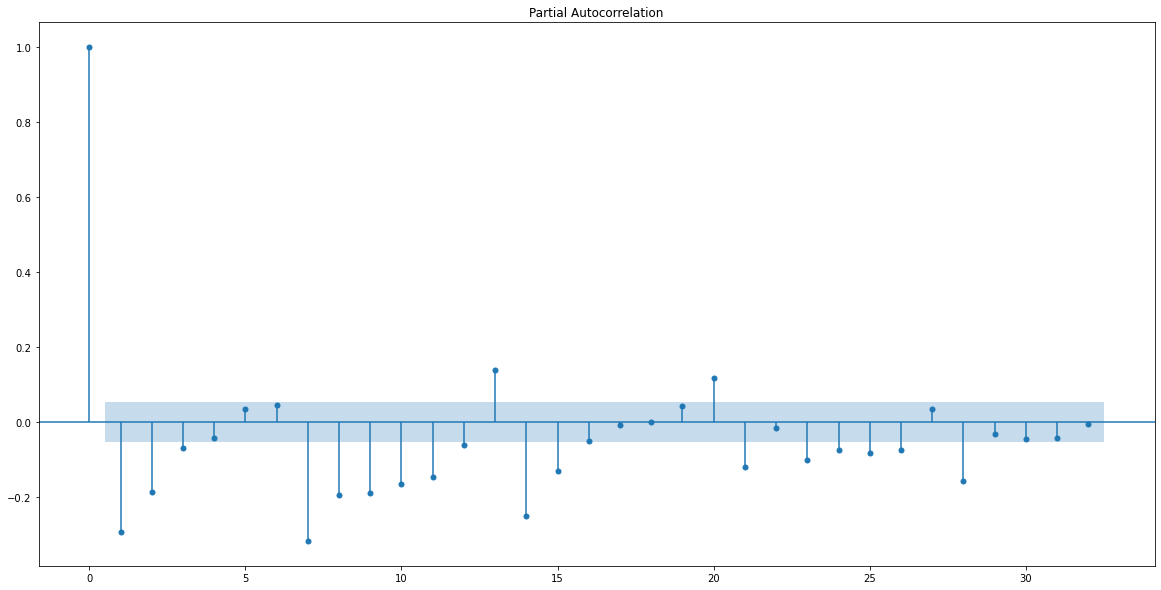

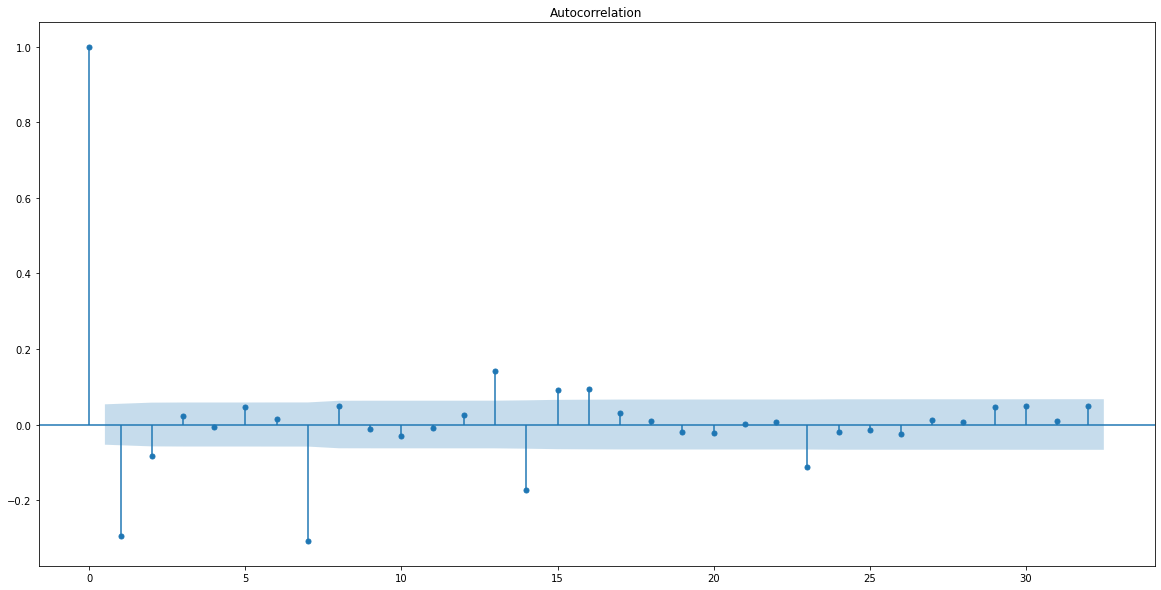

In [ ]:
_ = sgt.plot_pacf(train['seasonal_diff'].dropna())
_ = sgt.plot_acf(train['seasonal_diff'].dropna())
plt.show()

PACF plot sugests that we should consider p not bigger than 3, P min 1, maybe 2, but we should check also 3, 4  
ACF plot sugests q not bigger than 2, and Q 1 or 2

d) model definition

In [ ]:
#our parameters grid
p_comp = [1,2,3]
P_comp = [1,2,3,4]
q_comp = [1,2]
Q_comp = [1,2]

In [ ]:
# model definition
def model_sarma(x,p, P, q, Q, d = 7, name = 'name'):
    model = SARIMAX(x, order =(p, 1, q), seasonal_order = (P,1,Q, d))
    result = model.fit()
    return {name: round(result.llf,3)}

In [ ]:
#let check a few diffent models, which will gain the best results, according to the Log Likelihood
loop_results_sarma = dict()

for p in p_comp:
    for P in P_comp:
        for q in q_comp:
            for Q in Q_comp:
                try:
                    x = model_sarma(train['sales'], p, P, q, Q,  name = 'model_sarma_' + str(p) + '_' + str(q) + '_seasonal_' + str(P) + "_" + str(Q))
                    loop_results_sarma.update(x)
                    print('model_sarma_' + str(p) + '_' + str(q) + '_seasonal_' + str(P) + "_"  + str(Q))
                except:
                    continue

model_sarma_1_1_seasonal_1_1
model_sarma_1_1_seasonal_1_2
model_sarma_1_2_seasonal_1_1
model_sarma_1_2_seasonal_1_2
model_sarma_1_1_seasonal_2_1
model_sarma_1_1_seasonal_2_2
model_sarma_1_2_seasonal_2_1
model_sarma_1_2_seasonal_2_2
model_sarma_1_1_seasonal_3_1
model_sarma_1_1_seasonal_3_2
model_sarma_1_2_seasonal_3_1
model_sarma_1_2_seasonal_3_2
model_sarma_1_1_seasonal_4_1
model_sarma_1_1_seasonal_4_2
model_sarma_1_2_seasonal_4_1
model_sarma_1_2_seasonal_4_2
model_sarma_2_1_seasonal_1_1
model_sarma_2_1_seasonal_1_2
model_sarma_2_2_seasonal_1_1
model_sarma_2_2_seasonal_1_2
model_sarma_2_1_seasonal_2_1
model_sarma_2_1_seasonal_2_2
model_sarma_2_2_seasonal_2_1
model_sarma_2_2_seasonal_2_2
model_sarma_2_1_seasonal_3_1
model_sarma_2_1_seasonal_3_2
model_sarma_2_2_seasonal_3_1
model_sarma_2_2_seasonal_3_2
model_sarma_2_1_seasonal_4_1
model_sarma_2_1_seasonal_4_2
model_sarma_2_2_seasonal_4_1
model_sarma_2_2_seasonal_4_2
model_sarma_3_1_seasonal_1_1
model_sarma_3_1_seasonal_1_2
model_sarma_3_

In [ ]:
#Let's check 5 best models
best_sarma = pd.DataFrame([loop_results_sarma]).T.rename(columns = {0: 'result'})
best_sarma.sort_values(by = 'result', ascending = False).head(6)

result
model_sarma_3_1_seasonal_4_2 -17270.681
model_sarma_3_2_seasonal_4_2 -17271.121
model_sarma_2_2_seasonal_4_2 -17272.128
model_sarma_2_1_seasonal_4_2 -17272.725
model_sarma_4_2_seasonal_4_2 -17273.047

Our best SARIMA is SARIMA(4,1,1)(4,1,2)7 but as good as SARIMA(3,1,1)(4,1,2)7, so we use less complex model

In [ ]:
model_sarma_3_1_seasonal_4_2 = SARIMAX(train['sales'], order = (3,1,1), seasonal_order=(4,1,2,7))
result_sarma_3_1_seasonal_4_2 = model_sarma_3_1_seasonal_4_2.fit()
result_sarma_3_1_seasonal_4_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(4, 1, [1, 2], 7)   Log Likelihood              -17270.681
Date:                                Fri, 15 Apr 2022   AIC                          34563.362
Time:                                        22:15:02   BIC                          34620.583
Sample:                                    01-01-2013   HQIC                         34584.798
                                         - 09-11-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4476      0.028     15.771      0.000       0.392       0.503
ar.L2          0.0834      0.035      2.385      0.017       0.015       0.152
ar.L3          0.0833      0.038      2.190      0.029       0.009       0.158
ma.L1         -0.9657      0.020    -47.807      0.000      -1.005      -0.926
ar.S.L7       -0.7157      0.045    -15.906      0.000      -0.804      -0.627
ar.S.L14       0.2402      0.048      4.977      0.000       0.146       0.335
ar.S.L21      -0.0103      0.077     -0.134      0.893      -0.160       0.140
ar.S.L28      -0.0538      0.064     -0.839      0.401      -0.179       0.072
ma.S.L7        0.0103      0.041      0.253      0.800      -0.069       0.090
ma.S.L14      -0.9334      0.037    -25.030      0.000      -1.006      -0.860
sigma2      1.331e+10   3.16e-12   4.21e+21      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (Q):                      143.17   Jarque-Bera (JB):             47233.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+36. Standard errors may be unstable.
"""

Unfortunately not all coefficients are significant.  
Besides that residuals are correlated and haven't normal distribution.  
Let's try simpler model without those coefficients

In [ ]:
model_sarma_3_1_seasonal_1_1 = SARIMAX(train['sales'], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarma_3_1_seasonal_1_1 = model_sarma_3_1_seasonal_1_1.fit()
result_sarma_3_1_seasonal_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17275.896
Date:                           Fri, 15 Apr 2022   AIC                          34565.792
Time:                                   22:24:27   BIC                          34602.206
Sample:                               01-01-2013   HQIC                         34579.433
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4564      0.026     17.547      0.000       0.405       0.507
ar.L2          0.0910      0.033      2.742      0.006       0.026       0.156
ar.L3          0.0764      0.036      2.149      0.032       0.007       0.146
ma.L1         -0.9692      0.018    -54.681      0.000      -1.004      -0.934
ar.S.L7        0.2501      0.022     11.213      0.000       0.206       0.294
ma.S.L7       -0.9617      0.015    -65.466      0.000      -0.990      -0.933
sigma2      1.331e+10   9.76e-13   1.36e+22      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (Q):                      159.46   Jarque-Bera (JB):             44753.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                            -1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+36. Standard errors may be unstable.
"""

This less complex model doesn't have any not significant coefficients, but still residuals are correlated and haven't normal distribution.

e) prediction and evaluation

In [ ]:
sarma_pred = result_sarma_3_1_seasonal_1_1.predict(test.index[0],test.index[-1])
sarma_train_pred = result_sarma_3_1_seasonal_1_1.predict(train.index[0],train.index[-1])

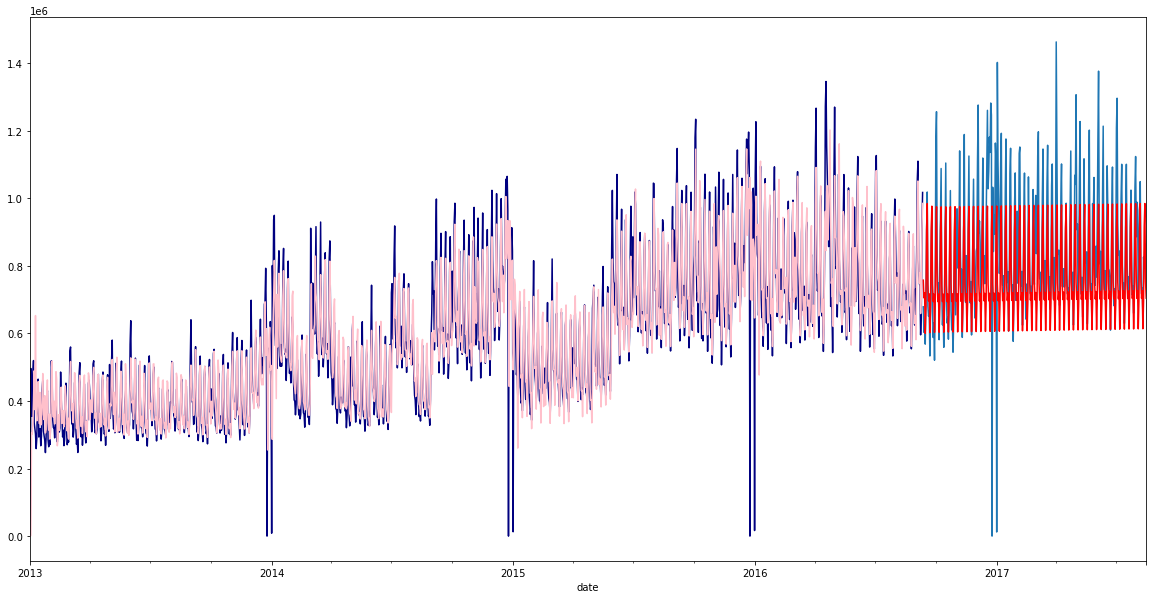

In [ ]:
test['sales'].plot()
train['sales'].plot(color= 'navy')
sarma_pred.plot(color = 'red')
sarma_train_pred.plot(color = 'pink')

plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train['sales'], sarma_train_pred),3))
print('R2 score test is: ', round(r2_score(test['sales'], sarma_pred),3))

R2 score train is:  0.828
R2 score test is:  0.263


We have very good results on train set, but still poor on test dataset.

**- SARIMAX**

In [ ]:
#let's use some exogeous variables with our best SARIMA model.  First wday and holiday type
model_sarimax_3_1_seasonal_1_1 = SARIMAX(train['sales'],exog = train[['wday','type']], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarimax_3_1_seasonal_1_1 = model_sarimax_3_1_seasonal_1_1.fit()
result_sarimax_3_1_seasonal_1_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17275.038
Date:                           Sat, 16 Apr 2022   AIC                          34568.076
Time:                                   09:31:47   BIC                          34614.893
Sample:                               01-01-2013   HQIC                         34585.614
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wday        5.687e-05   9395.973   6.05e-09      1.000   -1.84e+04    1.84e+04
type       -1547.0982   2726.872     -0.567      0.570   -6891.669    3797.472
ar.L1          0.4566      0.027     17.171      0.000       0.404       0.509
ar.L2          0.0923      0.034      2.707      0.007       0.025       0.159
ar.L3          0.0767      0.036      2.149      0.032       0.007       0.147
ma.L1         -0.9692      0.018    -54.600      0.000      -1.004      -0.934
ar.S.L7        0.2489      0.022     11.110      0.000       0.205       0.293
ma.S.L7       -0.9617      0.015    -64.625      0.000      -0.991      -0.933
sigma2       1.33e+10      0.024    5.5e+11      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (Q):                      156.40   Jarque-Bera (JB):             43678.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                            -1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.92e+27. Standard errors may be unstable.
"""

In [ ]:
#let's use some exogeous variables with our best SARIMA model.  Then with oil price and transactions, too.
model_sarimax_3_1_seasonal_1_1 = SARIMAX(train['sales'],exog = train[['wday','type', 'transactions','oil_price']], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarimax_3_1_seasonal_1_1 = model_sarimax_3_1_seasonal_1_1.fit()
result_sarimax_3_1_seasonal_1_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -16686.562
Date:                           Sat, 16 Apr 2022   AIC                          33395.123
Time:                                   09:35:52   BIC                          33452.345
Sample:                               01-01-2013   HQIC                         33416.559
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wday         -5.178e-06   6.66e+04  -7.78e-11      1.000    -1.3e+05     1.3e+05
type          1696.8720   1833.876      0.925      0.355   -1897.459    5291.203
transactions     6.6084      0.086     77.046      0.000       6.440       6.776
oil_price     2196.0042   1664.695      1.319      0.187   -1066.738    5458.746
ar.L1            0.7744      0.031     24.683      0.000       0.713       0.836
ar.L2           -0.1464      0.027     -5.377      0.000      -0.200      -0.093
ar.L3            0.1505      0.044      3.434      0.001       0.065       0.236
ma.L1           -0.9653      0.025    -39.080      0.000      -1.014      -0.917
ar.S.L7          0.0578      0.046      1.265      0.206      -0.032       0.147
ma.S.L7         -0.9223      0.022    -42.138      0.000      -0.965      -0.879
sigma2        5.879e+09      0.141   4.16e+10      0.000    5.88e+09    5.88e+09
===================================================================================
Ljung-Box (Q):                       99.44   Jarque-Bera (JB):             17104.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.21e+27. Standard errors may be unstable.
"""

How we can see, only transaction is not significant coef. and also corelated with sale, so we shouldn't use it.  
Let's better try with some feature enginering from oil_price.  Let's lag this variable.

In [33]:
train['oil_price_shift_1d'] = train['oil_price'].shift(1)
train['oil_price_shift_7d'] = train['oil_price'].shift(7)
train['oil_price_shift_30d'] = train['oil_price'].shift(30)

In [ ]:
model_sarimax_3_1_seasonal_1_1_ex3 = SARIMAX(train['sales'][30:],exog = train[['type','oil_price_shift_1d', 'oil_price_shift_7d','oil_price_shift_30d']][30:], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarimax_3_1_seasonal_1_1_ex3 = model_sarimax_3_1_seasonal_1_1_ex3.fit()
result_sarimax_3_1_seasonal_1_1_ex3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1320
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -16893.949
Date:                           Sat, 16 Apr 2022   AIC                          33809.898
Time:                                   09:56:27   BIC                          33866.871
Sample:                               01-31-2013   HQIC                         33831.265
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
type                -1384.7084   2879.160     -0.481      0.631   -7027.758    4258.341
oil_price_shift_1d  -1491.3505   3072.294     -0.485      0.627   -7512.936    4530.235
oil_price_shift_7d   -956.8778   3299.704     -0.290      0.772   -7424.178    5510.423
oil_price_shift_30d  3824.8134   2886.035      1.325      0.185   -1831.711    9481.338
ar.L1                   0.4485      0.027     16.355      0.000       0.395       0.502
ar.L2                   0.0833      0.035      2.375      0.018       0.015       0.152
ar.L3                   0.0823      0.037      2.205      0.027       0.009       0.155
ma.L1                  -0.9723      0.017    -57.819      0.000      -1.005      -0.939
ar.S.L7                 0.2482      0.024     10.475      0.000       0.202       0.295
ma.S.L7                -0.9621      0.016    -60.829      0.000      -0.993      -0.931
sigma2               1.353e+10      0.012   1.11e+12      0.000    1.35e+10    1.35e+10
===================================================================================
Ljung-Box (Q):                      162.03   Jarque-Bera (JB):             41947.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+26. Standard errors may be unstable.
"""

Not this time too.  
Let's try automate this proces, using auto-arima

**- AUTO-ARIMA**

In [ ]:
#let's define our model
model_auto = auto_arima(
    train['sales'],
    m = 7,
    seasonal = True,
    max_p = 7,
    max_q = 7,
    max_d = 1,
    max_P = 7,
    max_Q = 7,
    max_D = 1,
    maxiter= 50,
    n_jobs = -1,
    trend = 'ct',
    out_of_sample = int(len(train)*0.2),
    error_action = 'ignore',
    stepwise = True,
    trace = True)    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=34858.787, Time=3.25 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=36077.447, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=35406.263, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=35605.944, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=36077.447, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=35210.800, Time=2.44 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=34855.704, Time=6.11 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=6.67 sec
 ARIMA(2,1,2)(3,0,1)[7] intercept   : AIC=34857.417, Time=23.61 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=11.25 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=34852.770, Time=7.74 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=35087.378, Time=4.72 sec
 ARIMA(2,1,2)(1,0,3)[7] intercept   : AIC=34853.723, Time=16.74 sec
 ARIMA(2,1,2)(0,0,3)[7] intercept 

In [ ]:
#our best model according to auto_arima
model_auto 

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(4, 0, 4, 7),
      suppress_warnings=True, trend='ct', with_intercept=False)

In [ ]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                        sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 2)x(4, 0, [1, 2, 3, 4], 7)   Log Likelihood              -17361.349
Date:                                      Mon, 25 Apr 2022   AIC                          34754.698
Time:                                              18:42:09   BIC                          34838.012
Sample:                                          01-01-2013   HQIC                         34785.901
                                               - 09-11-2016                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    878.3721    994.710      0.883      0.377   -1071.223    2827.967
drift         -0.6946      1.254     -0.554      0.580      -3.152       1.763
ar.L1         -0.6989      0.062    -11.355      0.000      -0.820      -0.578
ar.L2          0.2931      0.072      4.050      0.000       0.151       0.435
ar.L3          0.0175      0.037      0.473      0.636      -0.055       0.090
ma.L1          0.1524      0.060      2.521      0.012       0.034       0.271
ma.L2         -0.8253      0.049    -16.937      0.000      -0.921      -0.730
ar.S.L7       -1.0886      0.171     -6.361      0.000      -1.424      -0.753
ar.S.L14       0.7406      0.170      4.354      0.000       0.407       1.074
ar.S.L21       1.1238      0.156      7.187      0.000       0.817       1.430
ar.S.L28       0.2010      0.173      1.165      0.244      -0.137       0.539
ma.S.L7        1.3853      0.169      8.189      0.000       1.054       1.717
ma.S.L14      -0.3270      0.205     -1.594      0.111      -0.729       0.075
ma.S.L21      -1.1908      0.108    -11.062      0.000      -1.402      -0.980
ma.S.L28      -0.4237      0.138     -3.078      0.002      -0.693      -0.154
sigma2      1.316e+10      0.000   8.43e+13      0.000    1.32e+10    1.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             44715.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.63e+29. Standard errors may be unstable.
"""

But we still see some not significant parameters

In [ ]:
auto_pred = pd.DataFrame({
    'index' : test.index,
    'result': model_auto.predict(n_periods= len(test[test.index[0]:test.index[-1]]))
                          }).set_index('index')

In [ ]:
print('R2 score test is: ', round(r2_score(test['sales'], auto_pred['result']),3))

R2 score test is:  0.392


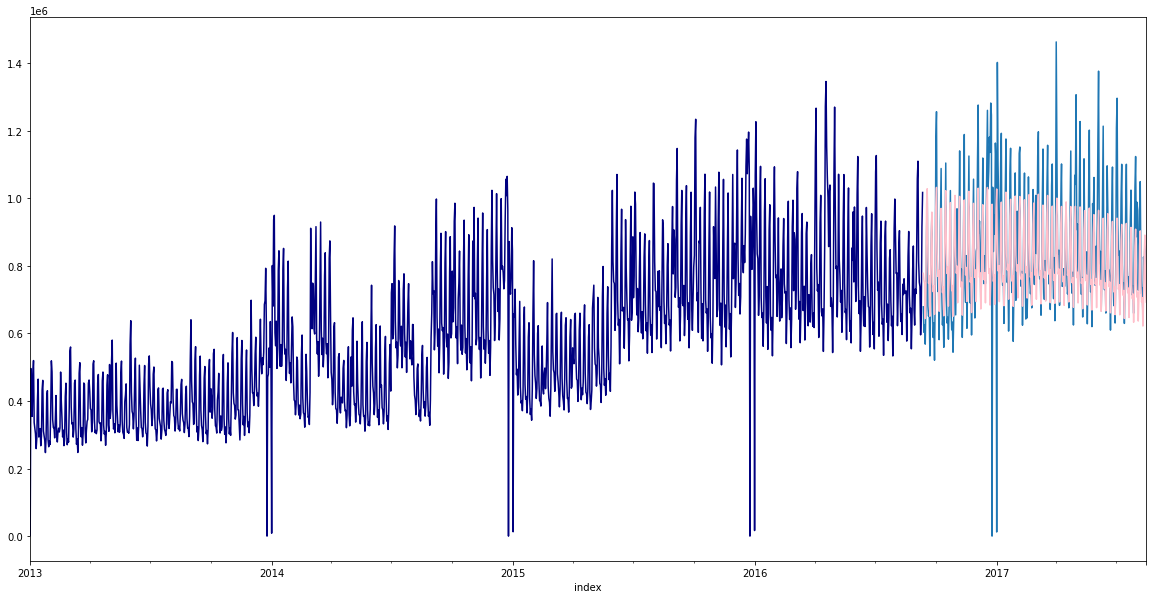

In [ ]:
#and plot the results
test['sales'].plot()
train['sales'].plot(color= 'navy')
auto_pred['result'].plot(color = 'pink')

plt.show()

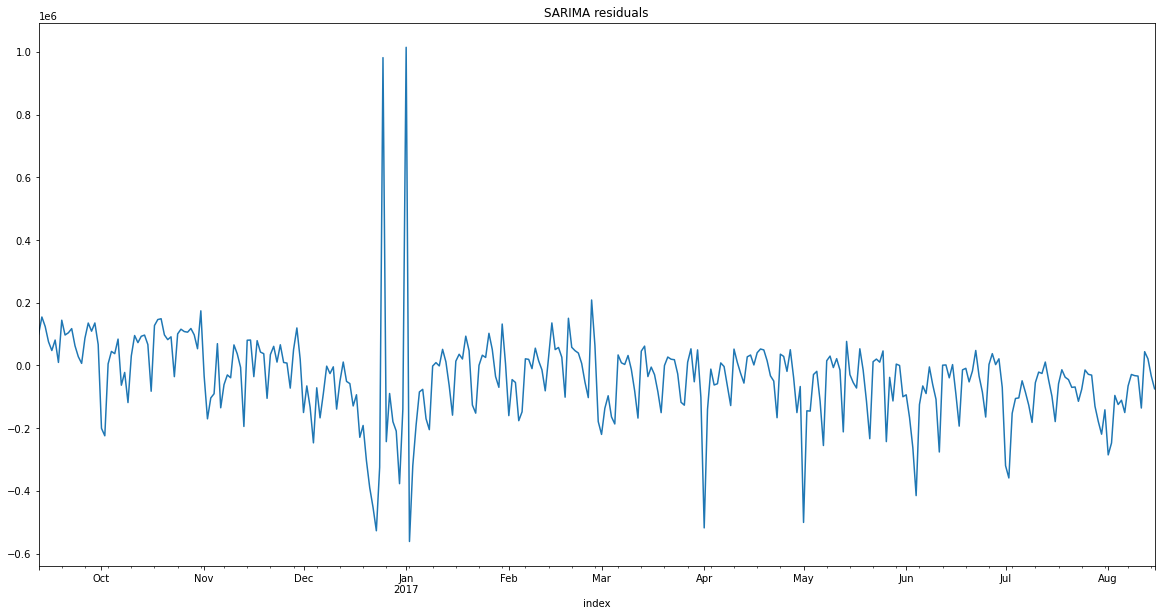

In [ ]:
#let check residuals from our best SARIMA model 
resid_sarima =auto_pred['result']-test['sales']
resid_sarima.plot()
plt.title('SARIMA residuals')
plt.show()

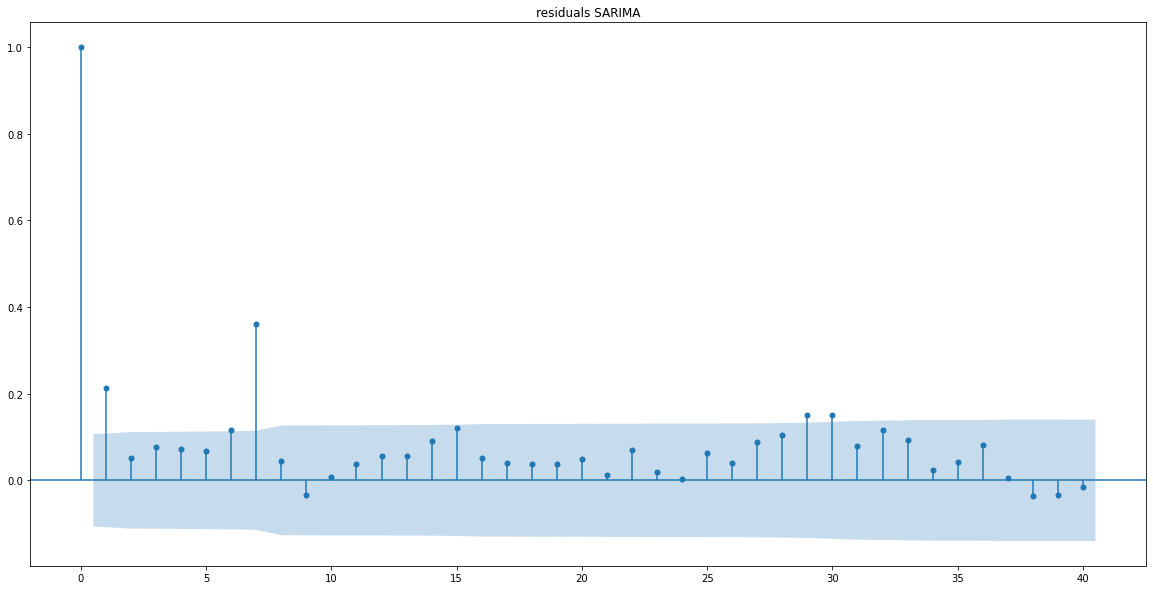

In [ ]:
#let's check if residuals are white noise
sgt.plot_acf(resid_sarima, lags = 40)
plt.title('residuals SARIMA')
plt.show()

Residauls from SARIMA model aren't completely white noise, so there is some room for improvment.

**- Prophet**

In [371]:
#let's try prophet module with his Prophet model
prophet_model = Prophet(yearly_seasonality= True, weekly_seasonality= True)
prophet_model.add_country_holidays(country_name = 'BR') # we use Brazil as quite similar country

In [372]:
#we have to first prepare our data for the model
train_df = train[['sales']].reset_index()
train_df.rename(columns = {'date': 'ds', 'sales': 'y'}, inplace = True)

test_df = test[['sales']].reset_index()
test_df.rename(columns = {'date': 'ds', 'sales': 'y'}, inplace = True)

In [373]:
prophet_model.fit(train_df)
forecast = prophet_model.predict(test_df)
forecast_train = prophet_model.predict(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [374]:
print('R2 score train is: ', round(r2_score(train['sales'], forecast_train['yhat']),3))
print('R2 score test is: ', round(r2_score(test['sales'], forecast['yhat']),3))

R2 score train is:  0.801
R2 score test is:  0.602


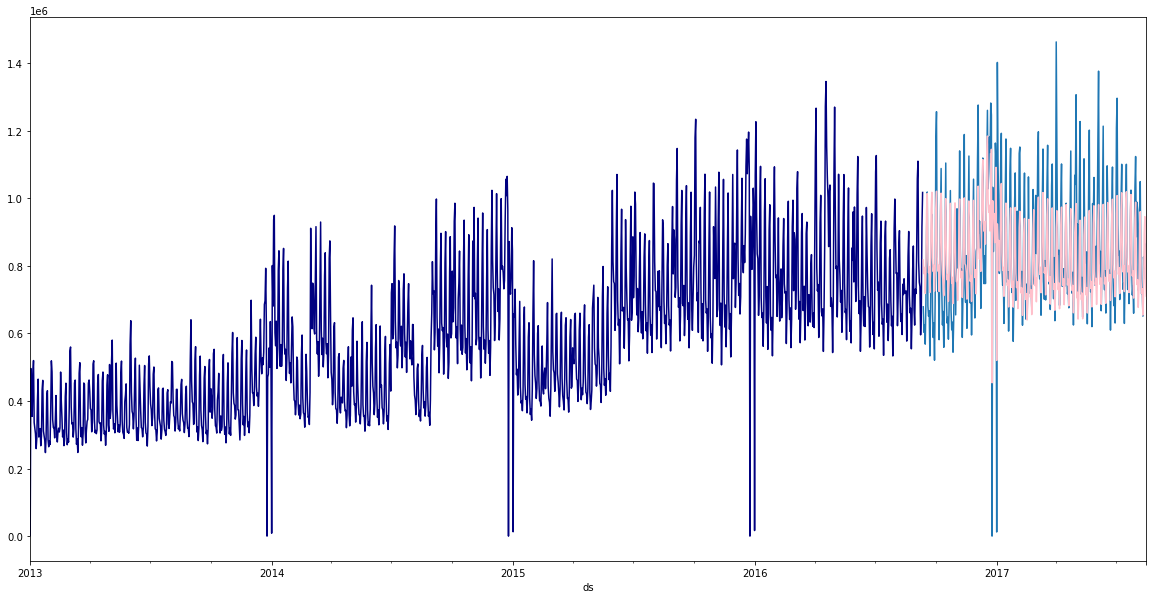

In [375]:
#and plot the results
forecast_df = forecast[['ds','yhat']].set_index('ds')

test['sales'].plot()
train['sales'].plot(color= 'navy')
forecast_df['yhat'].plot(color = 'pink')
plt.figsize = (20,10)
plt.show()

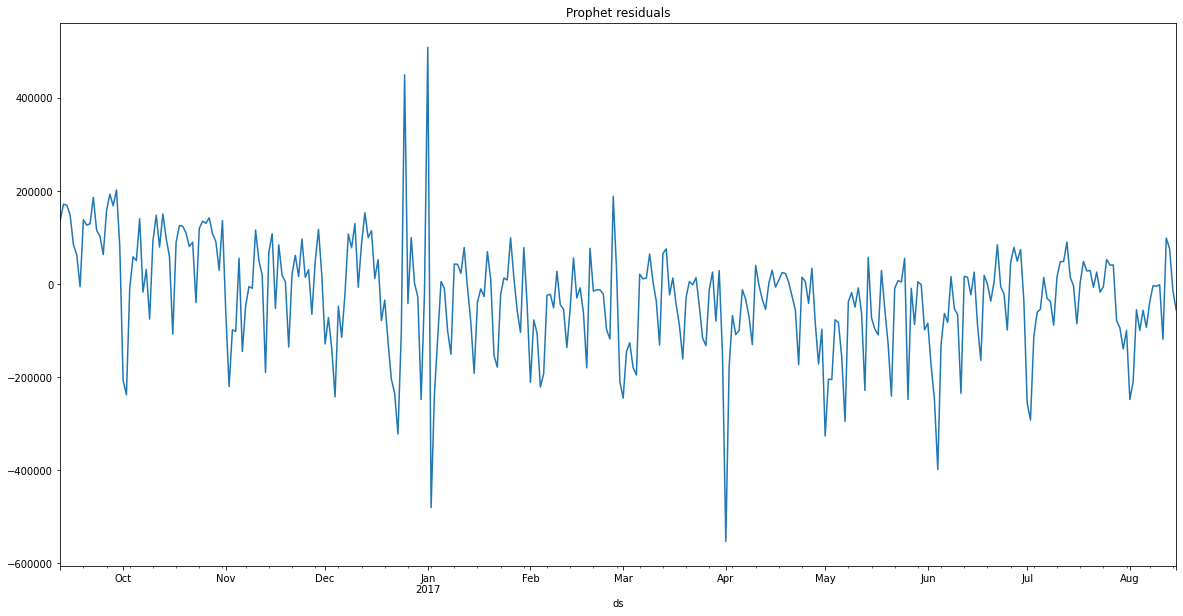

In [109]:
#let check residuals from our Prophet model 
resid_Prophet =forecast_df['yhat']-test['sales']
resid_Prophet.plot()
plt.title('Prophet residuals')
plt.show()

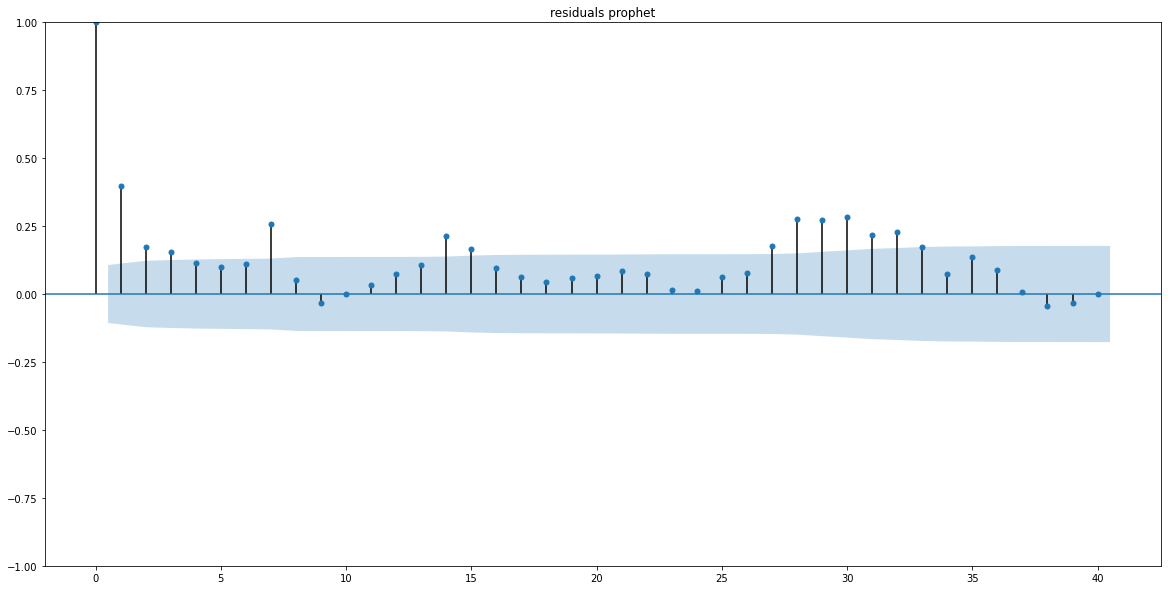

In [110]:
#let's check if residuals are white noise
sgt.plot_acf(resid_Prophet, lags = 40)
plt.title('residuals prophet')
plt.show()

Our model perform very well accoring to r2 score, but we see that later periods has bigger deviations, so maybe we should try multiplicative mode.

In [376]:
#multiplicative version 
prophet_model_multi = Prophet(yearly_seasonality= True, weekly_seasonality= True, seasonality_mode= 'multiplicative', interval_width= 0.95)
prophet_model_multi.add_country_holidays(country_name='BR')
prophet_model_multi.fit(train_df)
forecast = prophet_model_multi.predict(test_df)
forecast_train = prophet_model_multi.predict(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [377]:
print('R2 score train is: ', round(r2_score(train['sales'], forecast_train['yhat']),3))
print('R2 score test is: ', round(r2_score(test['sales'], forecast['yhat']),3))

R2 score train is:  0.812
R2 score test is:  0.668


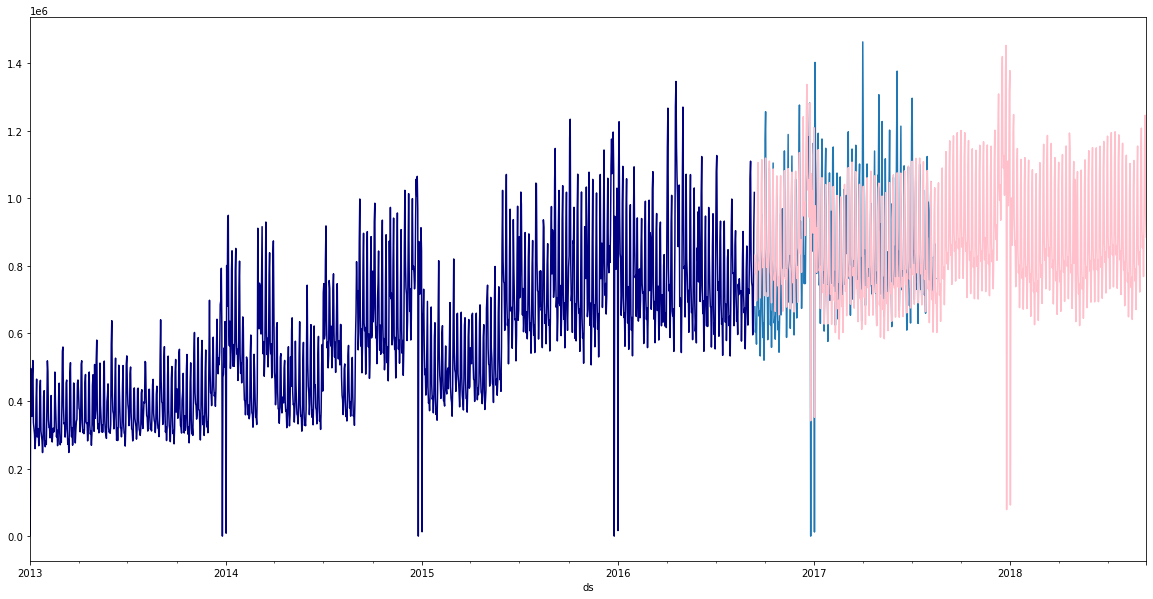

In [378]:
#future predictions for next two years
future_dates = prophet_model_multi.make_future_dataframe(periods = 365*2)
future_dates = future_dates[future_dates['ds']>=test.index[0]]
future_model = prophet_model_multi.predict(future_dates)
future_model

future_model = future_model[['ds','yhat']].set_index('ds')

test['sales'].plot()
train['sales'].plot(color= 'navy')
future_model['yhat'].plot(color = 'pink')
plt.figsize = (20,10)
plt.show()


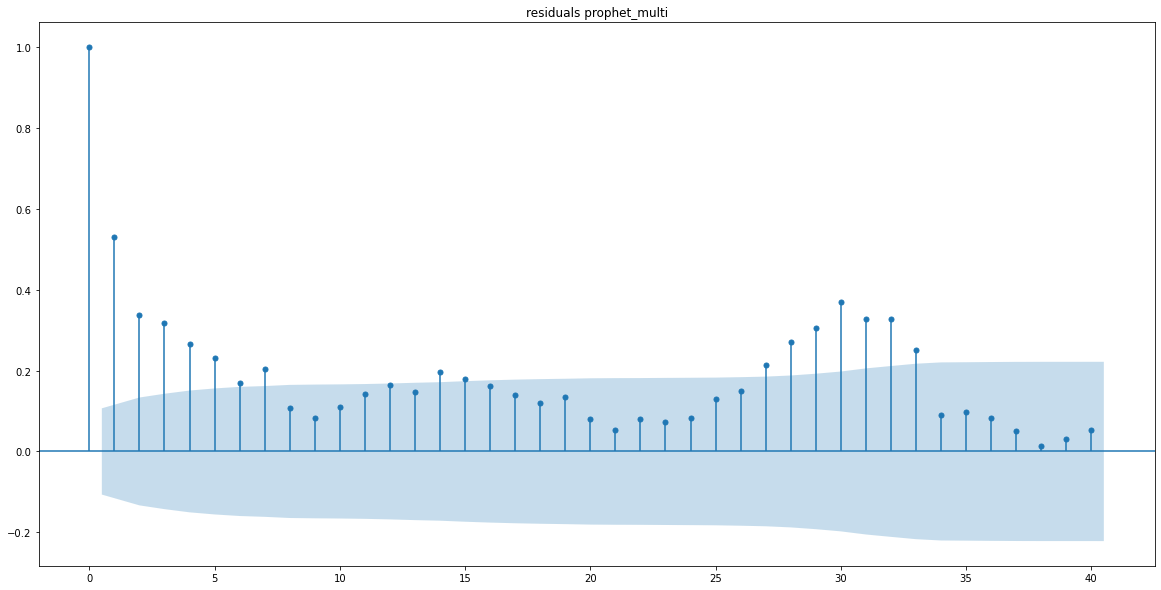

In [379]:
#let's check if residuals are white noise
resid_Prophet_multi = future_model[future_model.index <= test.index[-1]]['yhat']-test['sales']
sgt.plot_acf(resid_Prophet_multi, lags = 40)
plt.title('residuals prophet_multi')
plt.show()

As we can see Prophet model, especially multiplicative one, gives us better result than all ARMA family models, but his residuals still aren't white noise.

**- LSTM**

a) preparation

In [ ]:
#let's try with more sophisticated models, deep learning models.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#let's normalize our data to get better results
train_X = np.array(train['sales']).reshape(-1,1)
test_X = np.array(test['sales']).reshape(-1,1)
minmax_scaler = MinMaxScaler().fit(train_X)
X_train_norm = minmax_scaler.transform(train_X)
X_test_norm = minmax_scaler.transform(test_X)

train_norm = train.copy()
test_norm = test.copy()

train_norm['sales'] = X_train_norm
test_norm['sales'] = X_test_norm

In [ ]:
#let's again concate our train and test data to prepare sequential data, and finally split it into train and test
all_df = pd.concat([train_norm.iloc[:,:7], test_norm])

In [ ]:
#first we have to prepare right imput data format, i.e. sequential

def convert_to_seq(x, seq_len, feature_num):
    '''
    x - a numpy array with timeseries data to predict
    seq_len - sequantial lenght, depending on case can be different
    feature_num - number of features to use
    
    '''
    
    total_len = x.shape[0]
    xSeq =[]
    
    for i in range(total_len - seq_len):
        xSeq.append(x[i:i+seq_len])
    
    xSeq = np.array(xSeq).reshape(-1, seq_len, feature_num)
   
    try:
        y = np.array(x.iloc[seq_len:,0]).reshape(-1,1)
    except:
        y = xSeq[seq_len:,0].reshape(-1,1)
    
    return xSeq, y

In [ ]:
xSeq, y = convert_to_seq(all_df['sales'], 30,1)

In [ ]:
# we should also create a function which will update or sequence by adding predicted values to our previous sequence

def uptade_seq(seq,value):
    '''
    seq - sequence which we want to extend,
    value - value which will be add on the end of previous sequence
    
    '''
    seqLen = seq.shape[0]
    updatedSeq = np.zeros(seqLen)
    updatedSeq[:seqLen - 1] = seq[1:]
    updatedSeq[-1] = value
    
    return updatedSeq

In [ ]:
xSeq.shape, y.shape

((1658, 30, 1), (1628, 1))

As we can see our xSeq lenght is bigger than y, because of nature of sequence.  
So we won't have targets for our last 30 observations.  
Let's split our data set on train, test, and last 30 observations without targets

In [ ]:
treshold_seq = int(len(y)*0.8)

train_xSeq = xSeq[:treshold_seq]
test_xSeq  = xSeq[treshold_seq:y.shape[0]]
future_xSeq =xSeq[y.shape[0]:]

train_y = y[:treshold_seq]
test_y = y[treshold_seq:]


train_xSeq.shape, test_xSeq.shape, future_xSeq.shape, train_y.shape, test_y.shape

((1302, 30, 1), (326, 30, 1), (30, 30, 1), (1302, 1), (326, 1))

b) basic model

In [215]:
def model_lstm(x, y, x_test, y_test, units_lstm, seq_len,dropout_out = 0.3, 
               dropout_lstm = 0, layers_num = 1, num_feature = 1, epoch = 100, print_summary = False, name = 'best_model'):
    
    '''
    dropout_lstm - size of dropout between lstm layers
    dropout_out - size of dropout on the last lstm layers
    seq_len - sequence lenght
    units_lstm - number of units for lstm layers
    layers_num - number of lstm layers
    epoch - number of epoch to iterate
    name - model will be save with this name
    '''
    model = tf.keras.Sequential()
    
    
    if layers_num > 1 :
        
        model.add(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature),return_sequences = True))
        model.add(layers.Dropout(dropout_lstm))
        
        for n in range(2,layers_num+1):
            if n < layers_num:
                model.add(layers.LSTM(units = units_lstm, return_sequences= True))
                model.add(layers.Dropout(dropout_lstm))
                
            else:
                model.add(layers.LSTM(units = units_lstm))
                model.add(layers.Dropout(dropout_out))
            
    else:
        model.add(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature)))
        model.add(layers.Dropout(dropout_out))
        
    
    model.add(layers.Dense(units =1))
    
    if print_summary:
        print(model.summary())
    
    model.compile(
        optimizer='adam',
        loss="mse"
    )
    
    mc = ModelCheckpoint(str(name)+'.h5', monitor = 'val_loss', mode = 'min', save_best_only= True, verbose = 2)
    
    model.fit(x, y, epochs = epoch, batch_size = seq_len, validation_data = (x_test, y_test), 
              callbacks =[EarlyStopping(monitor = 'val_loss', patience = 3), mc])
    return model

In [ ]:
model_lstm1 = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 10, seq_len = 30,
           dropout_lstm = 0.0, dropout_out = 0.3, layers_num = 2, num_feature = 1, epoch = 10)

Epoch 1/10
44/44 [==============================] - 8s 60ms/step - loss: 0.0655 - val_loss: 0.0429
Epoch 2/10
44/44 [==============================] - 2s 35ms/step - loss: 0.0299 - val_loss: 0.0322
Epoch 3/10
44/44 [==============================] - 2s 34ms/step - loss: 0.0232 - val_loss: 0.0314
Epoch 4/10
44/44 [==============================] - 2s 35ms/step - loss: 0.0215 - val_loss: 0.0279
Epoch 5/10
44/44 [==============================] - 2s 35ms/step - loss: 0.0200 - val_loss: 0.0256
Epoch 6/10
44/44 [==============================] - 2s 35ms/step - loss: 0.0202 - val_loss: 0.0244
Epoch 7/10
44/44 [==============================] - 2s 34ms/step - loss: 0.0197 - val_loss: 0.0212
Epoch 8/10
44/44 [==============================] - 2s 34ms/step - loss: 0.0188 - val_loss: 0.0224
Epoch 9/10
44/44 [==============================] - 1s 34ms/step - loss: 0.0185 - val_loss: 0.0249
Epoch 10/10
44/44 [==============================] - 2s 34ms/step - loss: 0.0175 - val_loss: 0.0228


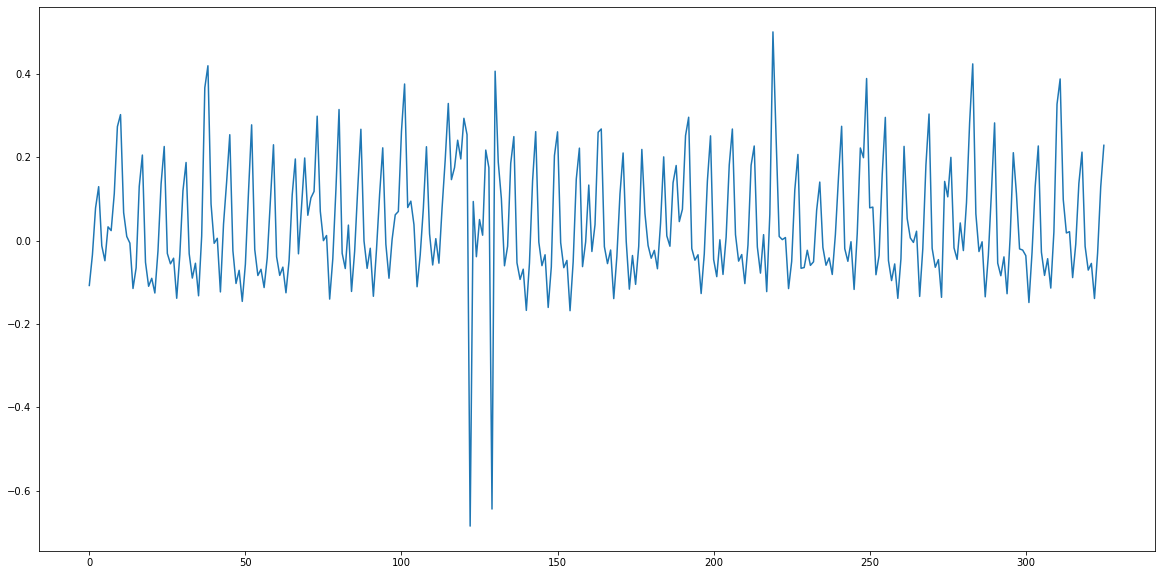

In [ ]:
#let's see how looks residuals plot
y_pred = model_lstm1.predict(test_xSeq)
y_pred_train = model_lstm1.predict(train_xSeq)

y_err = test_y - y_pred
plt.plot(y_err)
plt.show()

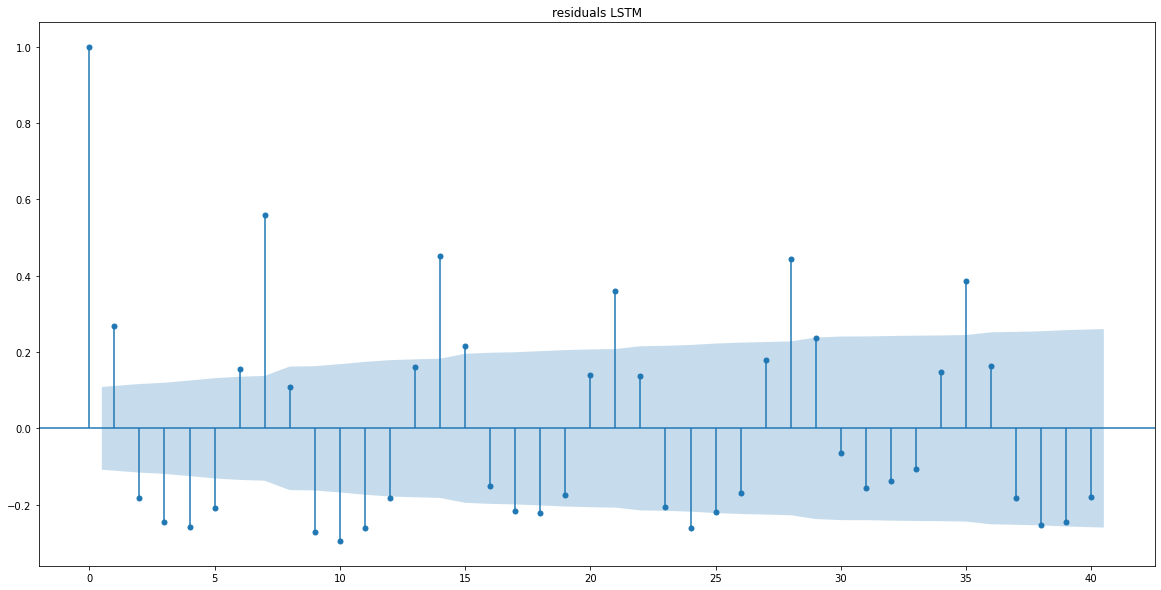

In [ ]:
# and let's check if our residuals are white noise
sgt.plot_acf(y_err, lags = 40)
plt.title('residuals LSTM')
plt.show()

As we can see our residuals aren't really white noise, there are still some patterns whose we should take into account

In [ ]:
def uptade_seq(seq,value):
    '''
    seq - sequence which we want to extend,
    value - value which will be add on the end of previous sequence
    
    '''
    seqLen = seq.shape[1]
    updatedSeq = np.zeros(seqLen)
    updatedSeq[:seqLen - 1] = seq[0][1:]
    updatedSeq[-1] = value
    
    return updatedSeq

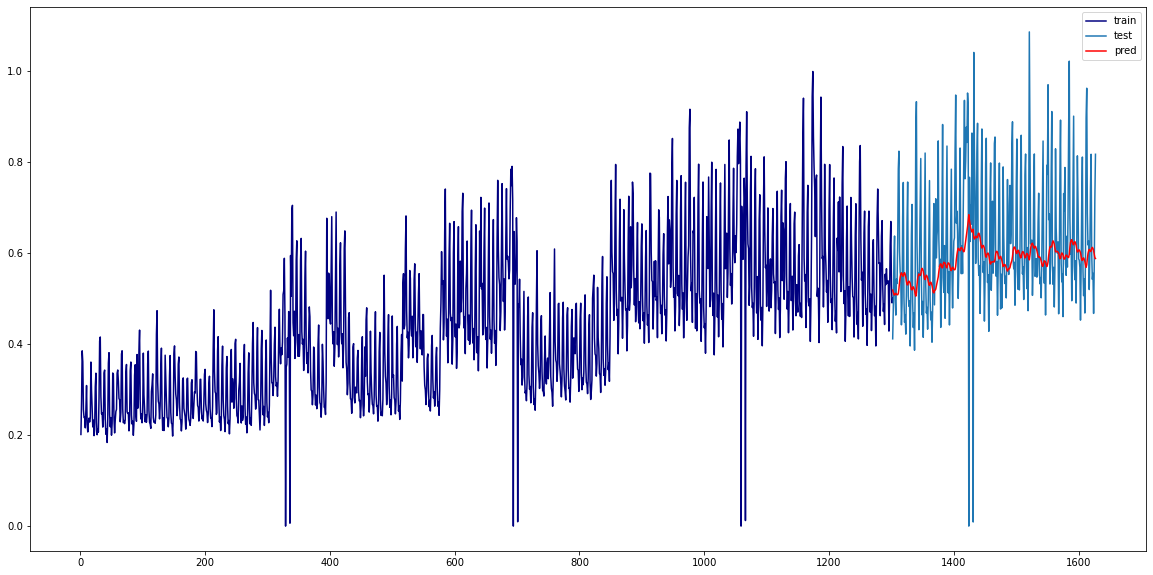

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred.shape[0])),y_pred, label = 'pred', color = 'red')
plt.legend()
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred),3))

R2 score train is:  0.516
R2 score test is:  -0.086


Ok our first basic model hasn't return us any interesting results, so let's try use more parameters.

c) model with different range of parameters

In [ ]:
params = {'units_lstm': [4,8,16, 32],
          'layers_num': [2,3,4],
          'dropout_lstm': [0,0.2,0.3, 0.5],
          'dropout_out': [0.2,0.5],
         }

In [ ]:
data = pd.DataFrame({'name' : [],
       'result': []})

for units_lstm in params['units_lstm']:
    for layers_num in params['layers_num']:
        for dropout_lstm in params['dropout_lstm']:
            for dropout_out in params['dropout_out']:
               
                model = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= units_lstm, seq_len = 30,
                   dropout_lstm = dropout_lstm, dropout_out = dropout_out, layers_num = layers_num, num_feature = 1, epoch = 50)
                
                
                y_pred = model.predict(test_xSeq)
                y_pred_train = model.predict(train_xSeq)
                
                result = r2_score(test_y, y_pred)
                
                data = data.append({'name' : f' model_units_{units_lstm}_layers_{layers_num}_drop_lstm_{dropout_lstm}_drop_{dropout_out}',
                    'result' : result}, ignore_index = True)
                                   
                data.sort_values('result', ascending = False)

Epoch 1/50
44/44 [==============================] - 16s 201ms/step - loss: 184062.4844 - val_loss: 86911.2812
Epoch 2/50
44/44 [==============================] - 7s 168ms/step - loss: 172234.6719 - val_loss: 47615.5039
Epoch 3/50
44/44 [==============================] - 7s 168ms/step - loss: 243763.5156 - val_loss: 147983.9375
Epoch 4/50
44/44 [==============================] - 7s 168ms/step - loss: 52884.1641 - val_loss: 27262.7969
Epoch 5/50
44/44 [==============================] - 7s 168ms/step - loss: 49695.7734 - val_loss: 98012.8750
Epoch 6/50
44/44 [==============================] - 8s 175ms/step - loss: 118869.2734 - val_loss: 30628.2422
Epoch 7/50
44/44 [==============================] - 7s 170ms/step - loss: 75786.3281 - val_loss: 143452.4375
Epoch 1/50
44/44 [==============================] - 16s 203ms/step - loss: 338170.8750 - val_loss: 374057.5000
Epoch 2/50
44/44 [==============================] - 7s 168ms/step - loss: 499701.7812 - val_loss: 375942.8750
Epoch 3/50
44/44

Epoch 11/50
44/44 [==============================] - 7s 169ms/step - loss: 31125.5645 - val_loss: 86027.2422
Epoch 12/50
44/44 [==============================] - 7s 167ms/step - loss: 13707.4043 - val_loss: 80720.0391
Epoch 13/50
44/44 [==============================] - 7s 173ms/step - loss: 59134.2656 - val_loss: 37946.0898
Epoch 1/50
44/44 [==============================] - 19s 224ms/step - loss: 71311.7422 - val_loss: 37901.1172
Epoch 2/50
44/44 [==============================] - 8s 181ms/step - loss: 44921.7617 - val_loss: 57452.9805
Epoch 3/50
44/44 [==============================] - 8s 179ms/step - loss: 39846.3711 - val_loss: 34759.3203
Epoch 4/50
44/44 [==============================] - 8s 181ms/step - loss: 56334.9414 - val_loss: 63123.9766
Epoch 5/50
44/44 [==============================] - 8s 180ms/step - loss: 52703.6797 - val_loss: 28305.2539
Epoch 6/50
44/44 [==============================] - 8s 180ms/step - loss: 19344.7109 - val_loss: 81170.2891
Epoch 7/50
44/44 [======

44/44 [==============================] - 7s 169ms/step - loss: 245667.9844 - val_loss: 198932.6406
Epoch 4/50
44/44 [==============================] - 7s 167ms/step - loss: 111198.3438 - val_loss: 31942.4785
Epoch 5/50
44/44 [==============================] - 8s 175ms/step - loss: 127706.2578 - val_loss: 12886.9629
Epoch 6/50
44/44 [==============================] - 7s 171ms/step - loss: 184850.7812 - val_loss: 31547.9297
Epoch 7/50
44/44 [==============================] - 7s 168ms/step - loss: 33670.8164 - val_loss: 228897.3750
Epoch 8/50
44/44 [==============================] - 7s 168ms/step - loss: 123576.0000 - val_loss: 43070.2070
Epoch 1/50
44/44 [==============================] - 16s 201ms/step - loss: 177778.9688 - val_loss: 210993.4062
Epoch 2/50
44/44 [==============================] - 7s 167ms/step - loss: 153330.3594 - val_loss: 86277.0000
Epoch 3/50
44/44 [==============================] - 7s 168ms/step - loss: 75218.6875 - val_loss: 30469.5684
Epoch 4/50
44/44 [==========

44/44 [==============================] - 9s 202ms/step - loss: 34861.1758 - val_loss: 6080.6826
Epoch 4/50
44/44 [==============================] - 9s 196ms/step - loss: 31928.5527 - val_loss: 28800.7578
Epoch 5/50
44/44 [==============================] - 9s 198ms/step - loss: 14356.3320 - val_loss: 7254.2446
Epoch 6/50
44/44 [==============================] - 9s 197ms/step - loss: 18037.6543 - val_loss: 23780.9766
Epoch 1/50
44/44 [==============================] - 22s 251ms/step - loss: 467451.8125 - val_loss: 679698.3750
Epoch 2/50
44/44 [==============================] - 9s 197ms/step - loss: 575495.6875 - val_loss: 213643.9219
Epoch 3/50
44/44 [==============================] - 9s 198ms/step - loss: 26740.7676 - val_loss: 185342.3750
Epoch 4/50
44/44 [==============================] - 9s 197ms/step - loss: 102215.4219 - val_loss: 75667.9688
Epoch 5/50
44/44 [==============================] - 9s 201ms/step - loss: 62162.5117 - val_loss: 25480.5332
Epoch 6/50
44/44 [================

44/44 [==============================] - 23s 263ms/step - loss: 132561.4062 - val_loss: 110211.0547
Epoch 2/50
44/44 [==============================] - 9s 200ms/step - loss: 68374.4062 - val_loss: 20725.5820
Epoch 3/50
44/44 [==============================] - 9s 200ms/step - loss: 28536.0039 - val_loss: 26451.1602
Epoch 4/50
44/44 [==============================] - 9s 200ms/step - loss: 46043.5312 - val_loss: 64138.6445
Epoch 5/50
44/44 [==============================] - 9s 201ms/step - loss: 52482.6914 - val_loss: 156149.5312
Epoch 1/50
44/44 [==============================] - 22s 258ms/step - loss: 157226.0469 - val_loss: 49385.9414
Epoch 2/50
44/44 [==============================] - 9s 200ms/step - loss: 59133.1250 - val_loss: 72096.1641
Epoch 3/50
44/44 [==============================] - 9s 199ms/step - loss: 75381.2500 - val_loss: 109881.1406
Epoch 4/50
44/44 [==============================] - 9s 202ms/step - loss: 59185.8633 - val_loss: 19259.9609 ETA: 0s - loss: 235
Epoch 5/50
4

Epoch 6/50
44/44 [==============================] - 8s 184ms/step - loss: 212610.4375 - val_loss: 233827.9219
Epoch 7/50
44/44 [==============================] - 8s 186ms/step - loss: 53621.4141 - val_loss: 125603.9844: 0s - loss: 66467.74 - ETA: 0s - loss: 62880
Epoch 8/50
44/44 [==============================] - 8s 185ms/step - loss: 88404.7656 - val_loss: 24146.8184
Epoch 9/50
44/44 [==============================] - 8s 186ms/step - loss: 34598.8828 - val_loss: 135519.4219
Epoch 10/50
44/44 [==============================] - 9s 211ms/step - loss: 44563.9062 - val_loss: 26926.9824
Epoch 11/50
44/44 [==============================] - 9s 198ms/step - loss: 36339.2227 - val_loss: 223834.4531
Epoch 1/50
44/44 [==============================] - 20s 232ms/step - loss: 340133.3438 - val_loss: 153840.8281
Epoch 2/50
44/44 [==============================] - 8s 186ms/step - loss: 188667.2031 - val_loss: 255048.4375
Epoch 3/50
44/44 [==============================] - 8s 189ms/step - loss: 11039

In [ ]:
data.sort_values('result', ascending = False)

name     result
58   model_units_16_layers_3_drop_lstm_0.2_drop_0.2 -11.238625
89     model_units_32_layers_4_drop_lstm_0_drop_0.5 -15.272078
35    model_units_8_layers_3_drop_lstm_0.2_drop_0.5 -15.725560
57     model_units_16_layers_3_drop_lstm_0_drop_0.5 -16.343152
3     model_units_4_layers_2_drop_lstm_0.2_drop_0.5 -16.452256
..                                              ...        ...
28    model_units_8_layers_2_drop_lstm_0.3_drop_0.2 -22.416809
47    model_units_8_layers_4_drop_lstm_0.5_drop_0.5 -22.743599
75   model_units_32_layers_2_drop_lstm_0.2_drop_0.5 -22.969105
84   model_units_32_layers_3_drop_lstm_0.3_drop_0.2 -23.373468
73     model_units_32_layers_2_drop_lstm_0_drop_0.5 -24.066322

[96 rows x 2 columns]

In [ ]:
#let's check our best lstm model with one feature
model_lstm2 = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 16, seq_len = 30,
           dropout_lstm = 0.2, dropout_out = 0.2, layers_num = 3, num_feature = 1, epoch = 50, print_summary = True)

y_pred2 = model_lstm2.predict(test_xSeq)
y_pred_train2 = model_lstm2.predict(train_xSeq)

Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_595 (LSTM)              (None, 30, 16)            1152      
_________________________________________________________________
dropout_454 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_596 (LSTM)              (None, 30, 16)            2112      
_________________________________________________________________
dropout_455 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_597 (LSTM)              (None, 16)                2112      
_________________________________________________________________
dropout_456 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_200 (Dense)            (None, 1)              

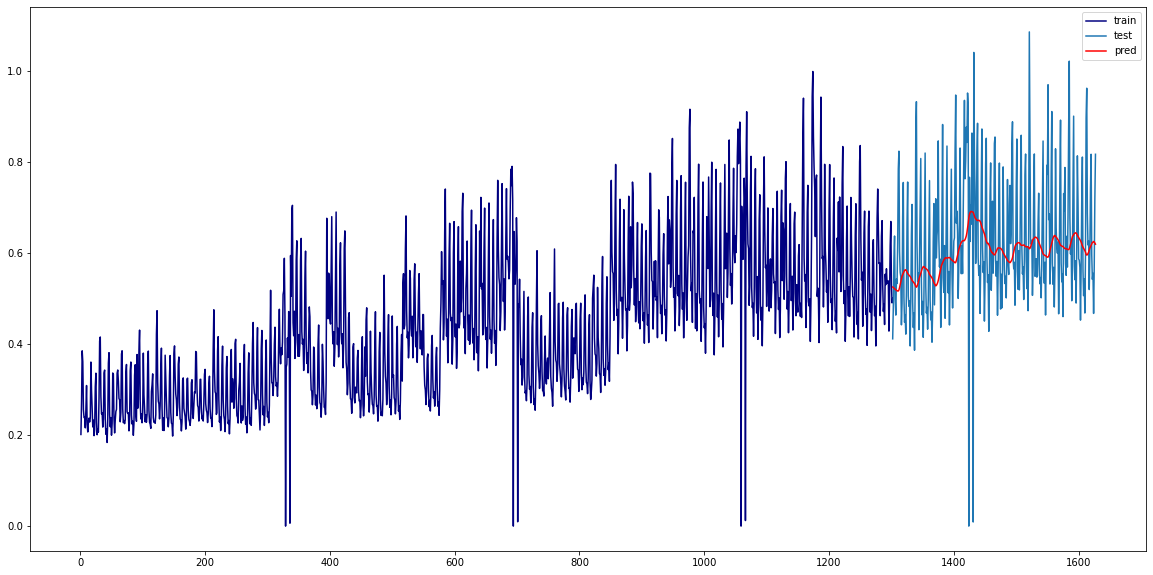

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred.shape[0])),y_pred2, label = 'pred', color = 'red')
plt.legend()
plt.show()

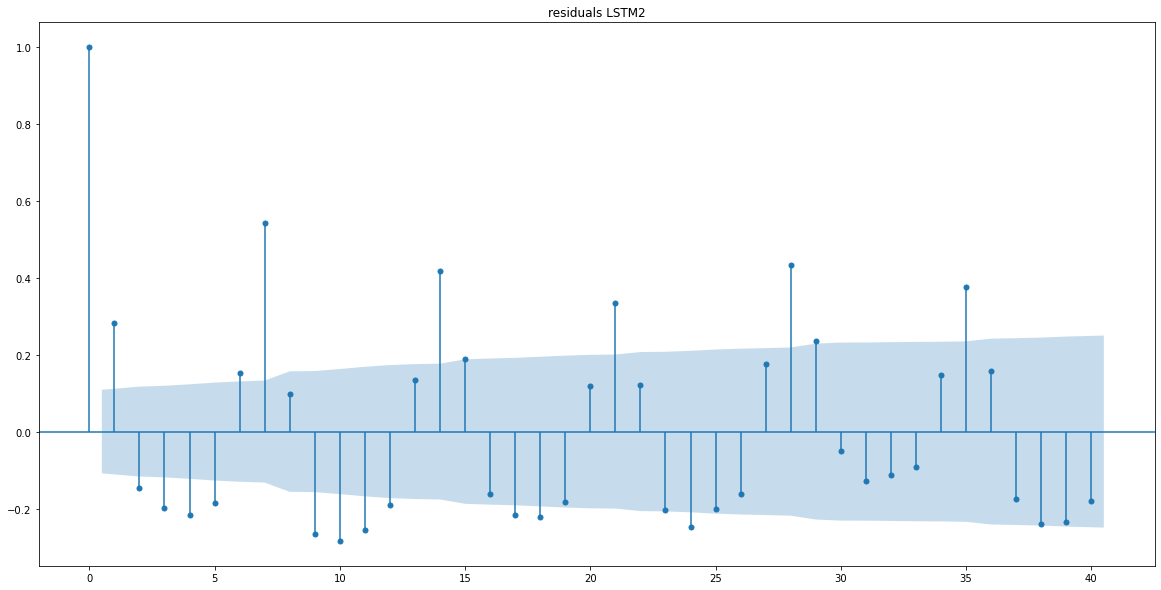

In [ ]:
# and let's check if our residuals are white noise
y_err2 = test_y - y_pred2

sgt.plot_acf(y_err2, lags = 40)
plt.title('residuals LSTM2')
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train2),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred2),3))

R2 score train is:  0.512
R2 score test is:  -0.019


Our prediction get not recommended r2_score results, but on the plot we can see than trend looks really good. 
The problem is that our daily data has too much volatility, maybe we should try to predict weekly data.  
But first let's check if extra features or biderectional lstm layer improve our results

d) model with more features

In [ ]:
xSeq, y = convert_to_seq(all_df[['sales','type','wday']], 30,3)

treshold_seq = int(len(y)*0.8)

train_xSeq = xSeq[:treshold_seq]
test_xSeq  = xSeq[treshold_seq:y.shape[0]]
future_xSeq =xSeq[y.shape[0]:]

train_y = y[:treshold_seq]
test_y = y[treshold_seq:]


train_xSeq.shape, test_xSeq.shape, future_xSeq.shape, train_y.shape, test_y.shape

((1326, 30, 3), (332, 30, 3), (0, 30, 3), (1326, 1), (332, 1))

In [ ]:
#let's check our best lstm model with three feature
model_lstm3 = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 16, seq_len = 30,
           dropout_lstm = 0.2, dropout_out = 0.2, layers_num = 3, num_feature = 3, epoch = 50, print_summary=True)

y_pred3 = model_lstm3.predict(test_xSeq)
y_pred_train3 = model_lstm3.predict(train_xSeq)

Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_612 (LSTM)              (None, 30, 16)            1280      
_________________________________________________________________
dropout_471 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_613 (LSTM)              (None, 30, 16)            2112      
_________________________________________________________________
dropout_472 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_614 (LSTM)              (None, 16)                2112      
_________________________________________________________________
dropout_473 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)              

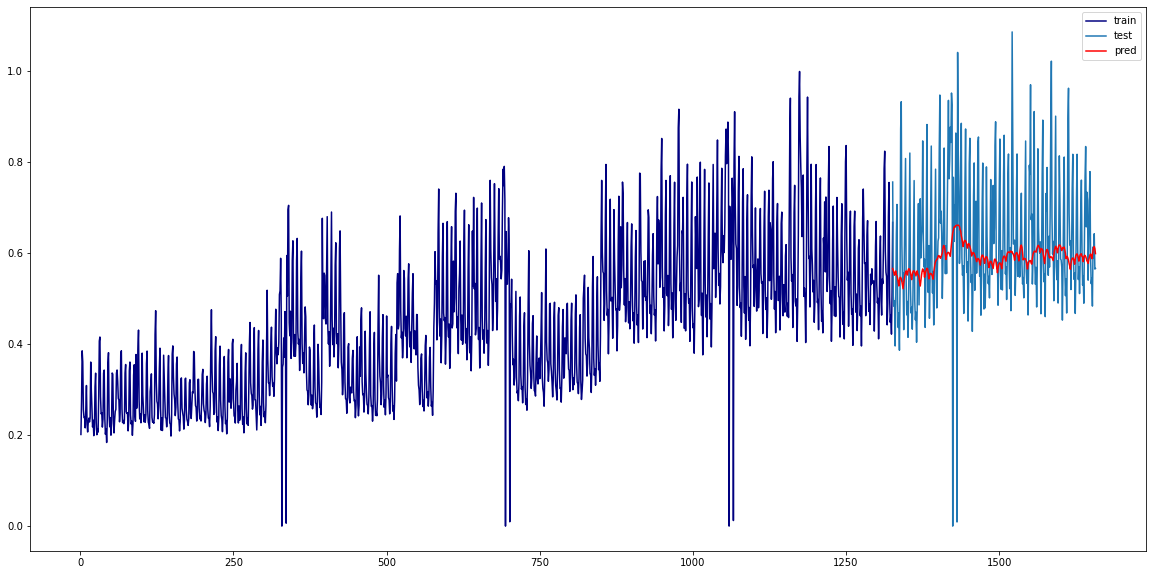

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred3.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred3.shape[0])),y_pred3, label = 'pred', color = 'red')
plt.legend()
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train3),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred3),3))

R2 score train is:  0.509
R2 score test is:  -0.038


There is no significant improvment with extra features

In [212]:
#let's create biderectional lstm model
def model_lstm_2(x, y, x_test, y_test, units_lstm, seq_len,dropout_out = 0.3, 
               dropout_lstm = 0, layers_num = 1, num_feature = 1, epoch = 100, print_summary = False, name = 'best_model'):
    
    '''
    dropout_lstm - size of dropout between lstm layers
    dropout_out - size of dropout on the last lstm layers
    seq_len - sequence lenght
    units_lstm - number of units for lstm layers
    layers_num - number of lstm layers
    epoch - number of epoch to iterate
    name - model will be save with this name
    
    '''
    model = tf.keras.Sequential()
    
    
    if layers_num > 1 :
        
        model.add(layers.Bidirectional(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature),return_sequences = True)))
        model.add(layers.Dropout(dropout_lstm))
        
        for n in range(2,layers_num+1):
            if n < layers_num:
                model.add(layers.Bidirectional(layers.LSTM(units = units_lstm, return_sequences= True)))
                model.add(layers.Dropout(dropout_lstm))
                
            else:
                model.add(layers.Bidirectional(layers.LSTM(units = units_lstm)))
                model.add(layers.Dropout(dropout_out))
            
    else:
        model.add(layers.Bidirectional(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature))))
        model.add(layers.Dropout(dropout_out))
        
    
    model.add(layers.Dense(units =1))
    
    
    model.compile(
        optimizer='adam',
        loss="mse"
    )
    
    mc = ModelCheckpoint(str(name)+'.h5', monitor = 'val_loss', mode = 'min', save_best_only= True, verbose = 2)
    
    model.fit(x, y, epochs = epoch, batch_size = seq_len, validation_data = (x_test, y_test), 
              callbacks =[EarlyStopping(monitor = 'val_loss', patience = 3), mc])
    
    if print_summary:
        print(model.summary())
    
    return model

In [ ]:
xSeq, y = convert_to_seq(all_df['sales'], 30,1)

treshold_seq = int(len(y)*0.8)

train_xSeq = xSeq[:treshold_seq]
test_xSeq  = xSeq[treshold_seq:y.shape[0]]
future_xSeq =xSeq[y.shape[0]:]

train_y = y[:treshold_seq]
test_y = y[treshold_seq:]

e) bidirectional LSTM model

In [ ]:
#let's check our best model with lstm biderectional layers and with one feature
model_lstm_bi = model_lstm_2(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 16, seq_len = 30,
           dropout_lstm = 0.2, dropout_out = 0.2, layers_num = 3, num_feature = 1, epoch = 50, print_summary=True)

y_pred_bi = model_lstm_bi.predict(test_xSeq)
y_pred_train_bi = model_lstm_bi.predict(train_xSeq)

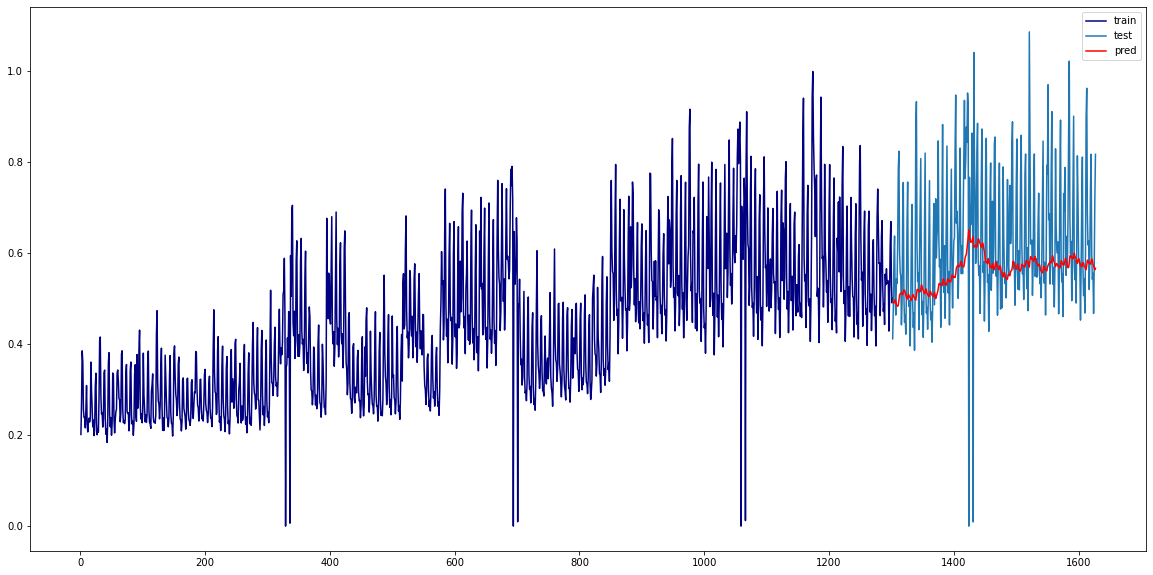

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred_bi.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred_bi.shape[0])),y_pred_bi, label = 'pred', color = 'red')
plt.legend()
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train_bi),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred_bi),3))

R2 score train is:  0.468
R2 score test is:  -0.18


In this case bidirectional layers give us worst results.

**- RGBRegressor**

a) data preparation

In [35]:
#our target variable will be our sales, and our explonatory variable will be: last day sale, last week sale and 30 days ago sale.
#we also again use holidays info and week days

df_xgb = dataset.copy()
df_xgb['sales_1d_ago'] = df_xgb['sales'].shift(1)
df_xgb['sales_7d_ago'] = df_xgb['sales'].shift(7)
df_xgb['sales_30_ago'] = df_xgb['sales'].shift(30)

#delete first 30 observation without all required data
df_xgb.dropna(inplace =True)

In [36]:
# let's again split data set into test and train
# with treshold = 0.8

x_xgb = df_xgb.copy()
del x_xgb['oil_price'],  x_xgb['transactions'],x_xgb['sales']

x_train_xgb = x_xgb.iloc[:treshold,:]
x_test_xgb  = x_xgb.iloc[treshold:,:]

y_train_xgb = df_xgb['sales'].iloc[:treshold]
y_test_xgb = df_xgb['sales'].iloc[treshold:]

print('train size lenght is: ', len(x_train_xgb), '\n'
     'test_size lenght is: ', len(x_test_xgb))

train size lenght is:  1350 
test_size lenght is:  308


b) simple model definition

In [37]:
#model definition
model_xgb = xgb.XGBRegressor(
    n_estimators = 50,
    max_depth = 5,
    objective= 'reg:squarederror',
    booster = 'gbtree',
    learning_rate = 0.1,
    n_jobs = -1,
    eval_metric = 'mae')

#cross validation definition
tscv = TimeSeriesSplit(n_splits = 5)

In [56]:
model_xgb.fit(x_train_xgb,y_train_xgb)
cv_result = cross_val_score(model_xgb, x_train_xgb, y_train_xgb, cv = tscv, scoring = 'r2')

In [57]:
#let's predict future values
y_pred_xgb = model_xgb.predict(x_test_xgb)
print('train r2_score is', round(cv_result.mean(),3))
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_xgb),3))

train r2_score is 0.557
test r2_score is 0.443


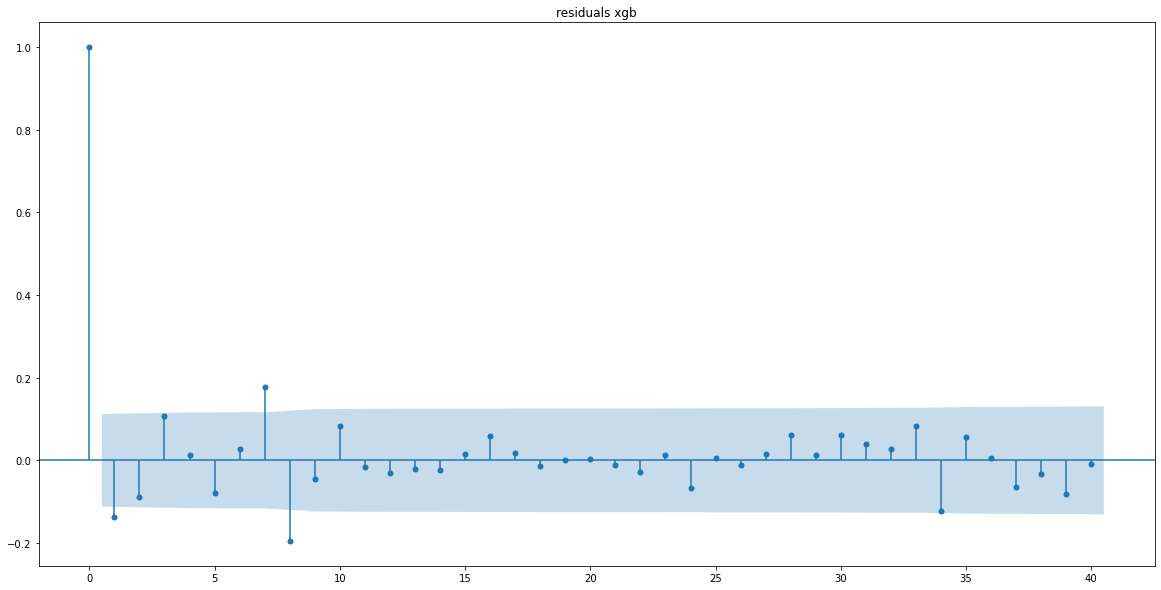

In [58]:
# check or residuals
resid_xgb = y_pred_xgb - y_test_xgb

sgt.plot_acf(resid_xgb, lags = 40)
plt.title('residuals xgb')
plt.show()

We have some autocorrelation in our residuals, it seems that we can improve our model.

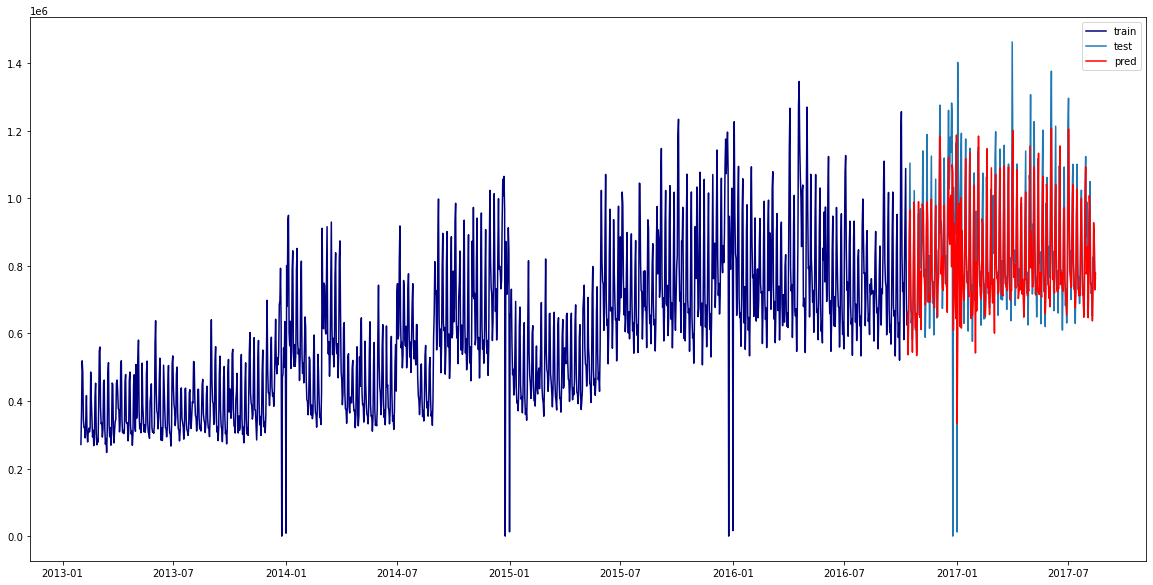

In [116]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_xgb, label = 'pred', color = 'red')
plt.legend()
plt.show()

As we can see our model performs very very good, but let's try improve it a little bit using hyperopt

In [59]:
#hyperopt params
param_hyperopt = {
    "learning_rate" : hp.loguniform("learning_rate", np.log(0.01), np.log(1)),
    "max_depth" : scope.int(hp.quniform("max_depth", 4,15,1)),
    "booster" : hp.choice("booster", ['gbtree']),  #'gblinear'
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 0.5),
    "min_child_weight" : scope.int(hp.quniform("min_child_weight", 2,6,1))
}

In [60]:
# model definition

def model_xgb_hyp(X_train, Y_train, CV, num_eval):
    
    def objective(params):
        
        model = xgb.XGBRegressor(**params, n_estimators = 50, objective= 'reg:squarederror', n_jobs = -1,eval_metric = 'mae')
        
        for a, b in CV.split(X_train):
            eval_set = [(X_train[a], Y_train[a]),(X_train[b], Y_train[b])]
            
            model.fit(X_train[a],Y_train[a], eval_set = eval_set, eval_metric = 'mae', early_stopping_rounds = 5, verbose = False)
            y_pred = model.predict(X_train[b])
            
            score = mean_absolute_error(Y_train[b], y_pred)
            
            return {'loss' : score, 'status': STATUS_OK}
        
        
    params = param_hyperopt 
        
    trials = Trials()
        
    best_params = fmin(objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = num_eval,
                        trials = trials)
        
    hyperparams = space_eval(params, best_params)
        
    print('the best params: ', hyperparams)
        
    return hyperparams

In [134]:
best_params_xgb = model_xgb_hyp(x_train_xgb.values, y_train_xgb.values, CV = tscv, num_eval = 5000)

100%|█████| 5000/5000 [43:10<00:00,  1.93trial/s, best loss: 70604.01034476844]
the best params:  {'booster': 'gbtree', 'learning_rate': 0.9999154341512477, 'max_depth': 4, 'min_child_weight': 6, 'reg_lambda': 0.23545552560891578}


In [63]:
best_model_xgb = xgb.XGBRegressor(**best_params_xgb, objective= 'reg:squarederror')
best_model_xgb.fit(x_train_xgb, y_train_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5839084422811566, max_delta_step=0, max_depth=10,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=0.47721862250264846, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [64]:
y_pred_best_xgb = best_model_xgb.predict(x_test_xgb)
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_best_xgb),3))

test r2_score is 0.4


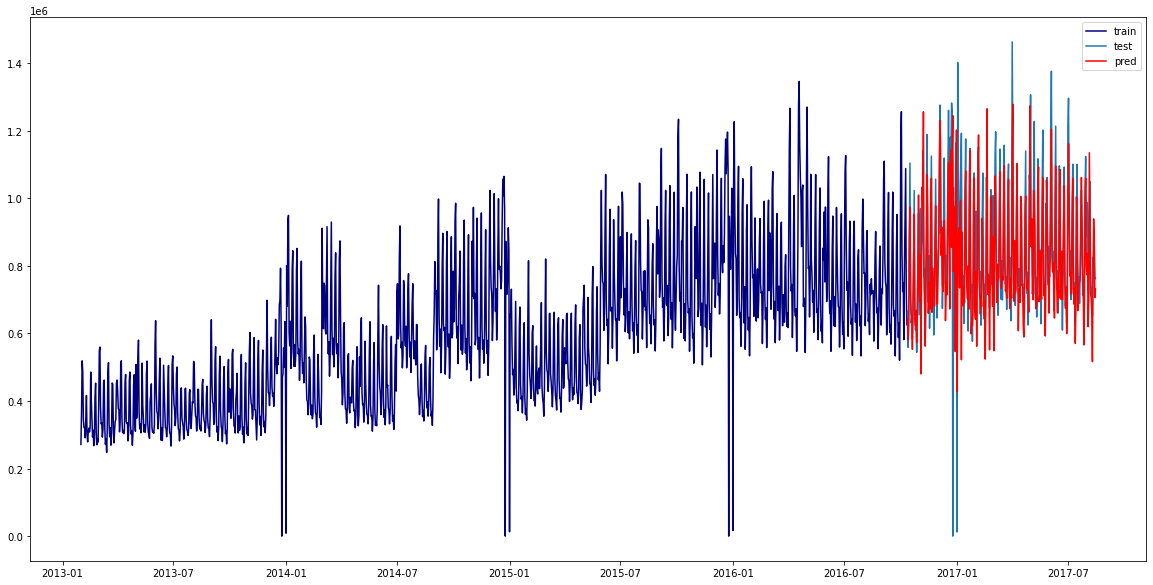

In [65]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_best_xgb, label = 'pred', color = 'red')
plt.legend()
plt.show()

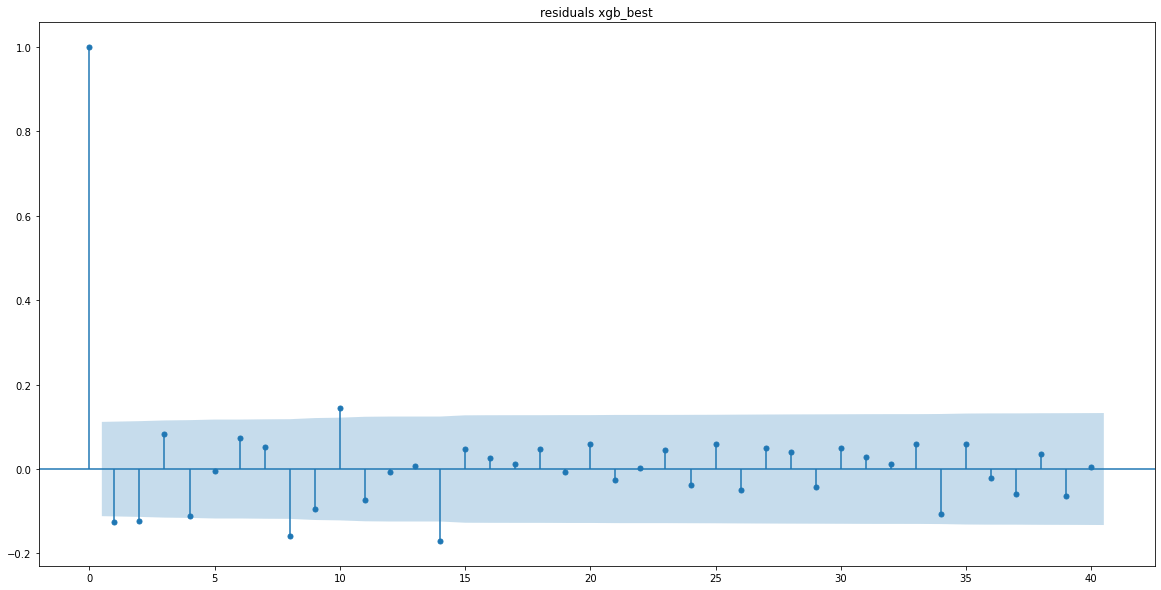

In [66]:
# check our residuals
resid_best_xgb = y_pred_best_xgb - y_test_xgb

sgt.plot_acf(resid_best_xgb, lags = 40)
plt.title('residuals xgb_best')
plt.show()

As we can see more complex model hasn't improve our r2 score, but his residuals seems to be white noise, beside that we should call model_xgb as our best model, unfortunately we can predict only one day ahead. 

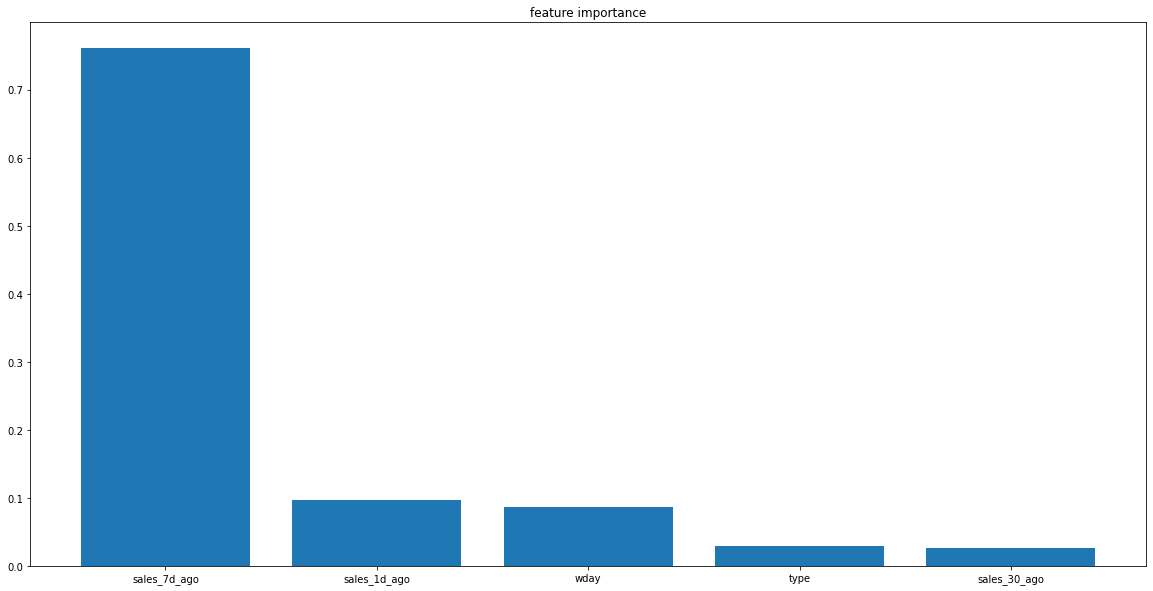

In [139]:
#let's check which feature seems to be more important to predict
fi  = model_xgb.feature_importances_
fi_df = pd.DataFrame(x_train_xgb.columns, fi).reset_index().sort_values(by = 'index', ascending= False)
plt.bar( fi_df[0],fi_df['index'])
plt.title('feature importance')
plt.show()

Now we see, that the most important feature to predict our model is last week sale, we can assume that holidays type or sales_30_ago is useless. So let's try last attempt, to predict without those feature.

In [67]:
#model definition
model_xgb_slim = xgb.XGBRegressor(
    n_estimators = 50,
    max_depth = 5,
    objective= 'reg:squarederror',
    booster = 'gbtree',
    learning_rate = 0.1,
    n_jobs = -1,
    eval_metric = 'mae')

model_xgb_slim.fit(x_train_xgb[['wday','sales_1d_ago','sales_7d_ago']],y_train_xgb)
cv_result_slim = cross_val_score(model_xgb_slim, x_train_xgb[['wday','sales_1d_ago','sales_7d_ago']], y_train_xgb, cv = tscv, scoring = 'r2')

#let's predict future values
y_pred_xgb_slim= model_xgb_slim.predict(x_test_xgb[['wday','sales_1d_ago','sales_7d_ago']])
print('train r2_score is', round(cv_result_slim.mean(),3))
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_xgb_slim),3))

train r2_score is 0.554
test r2_score is 0.337


Result is worst than before, so let's stay with full model and try to predict unseen data for test period, using updated sequenced data instead of test set.

In [68]:
# funtion definition which return y_pred for choosen period based on self, prior predictions
def updated_seq(y, model, seq_dates, seq_len):
    
    '''
    y - timeseries for past periods
    model - XGBmodel which will be use to predict
    seq_dates - data frame which contain date as an index and 'type' column with type of holidys.
            Notice seq_dates, should be long or equal to seq_len
    
    
    seq_len - number of periods to predict ahead.
            Notice seq_len can't be longer than seq_dates
    
    '''
    
    y_updated =pd.DataFrame(y.copy())
    y_pred_1by1 = []
    
    for i in range(seq_len):
        x_test_1by1 = pd.DataFrame({'type': seq_dates['type'][i],
                                    'wday': seq_dates.index[i].weekday()+1,
                                    'sales_1d_ago': y_updated['sales'][-1],
                                    'sales_7d_ago': y_updated['sales'][-7],
                                    'sales_30_ago': y_updated['sales'][-30]
                                    },
                                    index = [seq_dates.index[i]])
    
        y_pred = model.predict(x_test_1by1)
        
        new_row = pd.DataFrame({'sales' :y_pred}, index = [x_test_1by1.index[0]])
        y_pred_1by1 = np.concatenate([y_pred_1by1,y_pred])
    
        y_updated = pd.concat([y_updated,new_row])
        
        
    return y_pred_1by1

In [69]:
#let's forecast data day by day using our best model
y_pred_xgb_1by1 = updated_seq(y_train_xgb, best_model_xgb, seq_dates = x_test_xgb[['type']], seq_len = len(x_test_xgb))

In [70]:
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_xgb_1by1),3))

test r2_score is -0.032


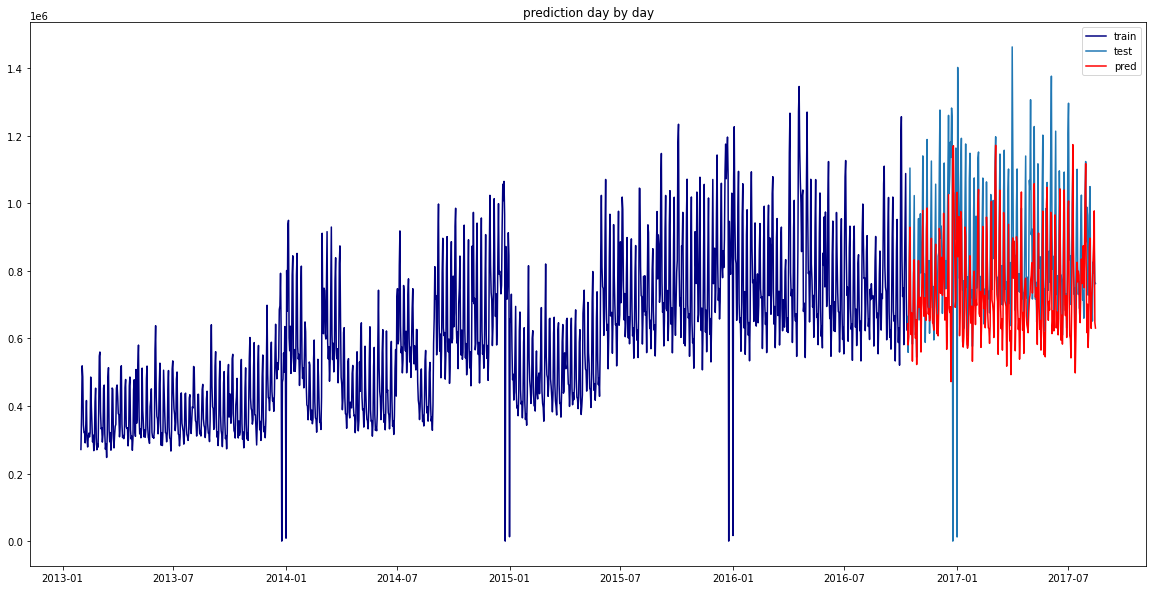

In [71]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_xgb_1by1, label = 'pred', color = 'red')
plt.legend()
plt.title('prediction day by day')
plt.show()

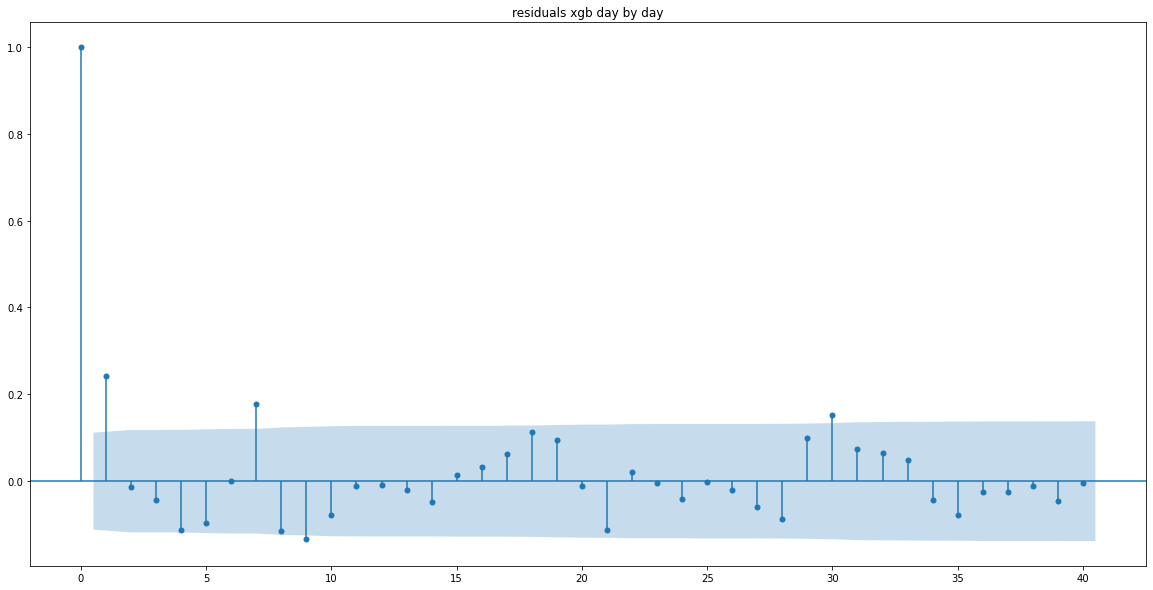

In [72]:
# check or residuals
resid_xgb_1by1 = y_pred_xgb_1by1 - y_test_xgb

sgt.plot_acf(resid_xgb_1by1, lags = 40)
plt.title('residuals xgb day by day')
plt.show()

As we can see our model, when it has to predict more than a few days ahead, using unsean data doesn't improve results obtained by previous model, i.e. Prophet 

**- LGBMRegressor**

In [38]:
#we will use same data as we used for XGB

#model definition
model_lgbm = lgbm.LGBMRegressor(
    n_estimators = 50,
    #max_depth = 5,
    objective= 'regression',
    boosting = 'gbdt',
    learning_rate = 0.1,
    n_jobs = -1)

In [39]:
model_lgbm.fit(x_train_xgb,y_train_xgb)
cv_result = cross_val_score(model_lgbm, x_train_xgb, y_train_xgb, cv = tscv, scoring = 'r2')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [40]:
#let's predict future values
y_pred_lgbm = model_lgbm.predict(x_test_xgb)
print('train r2_score is', round(cv_result.mean(),3))
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_lgbm),3))

train r2_score is 0.552
test r2_score is 0.461


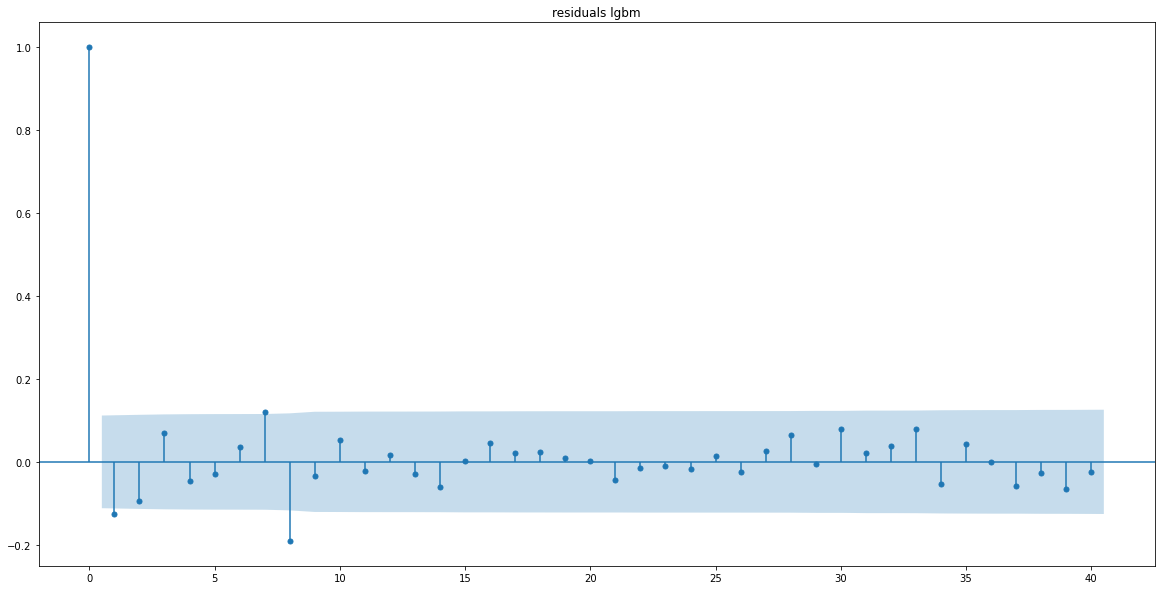

In [43]:
# check or residuals
resid_lgbm = y_pred_lgbm - y_test_xgb

sgt.plot_acf(resid_lgbm, lags = 40)
plt.title('residuals lgbm')
plt.show()

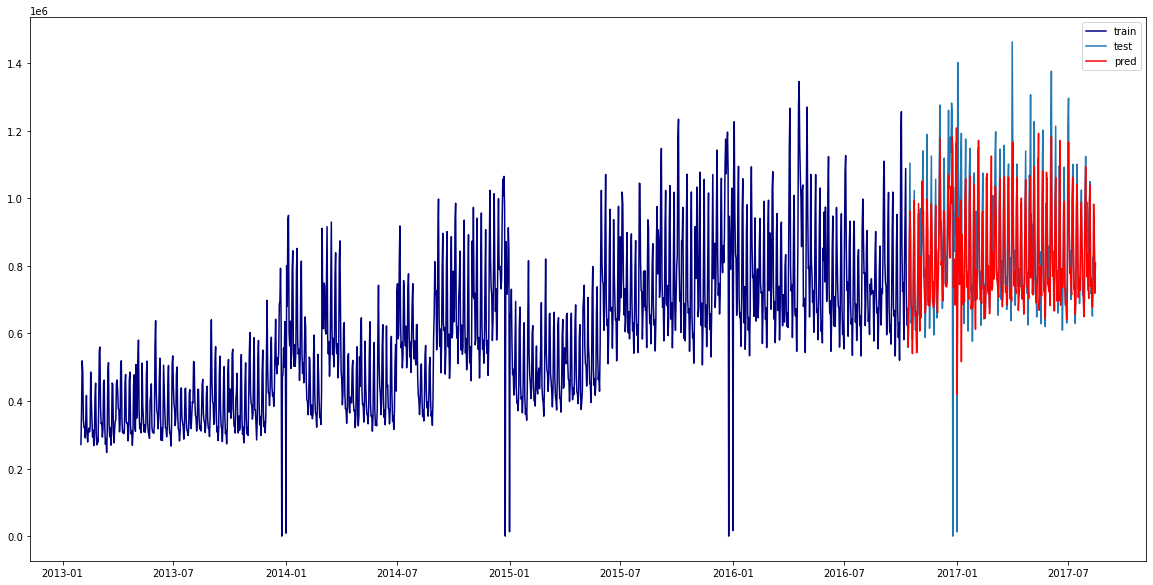

In [44]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_lgbm, label = 'pred', color = 'red')
plt.legend()
plt.show()

As we can see, basic model perform almost the same as XGB.  
Let's try forecast day by day on test period

In [46]:
y_pred_lgbm_1by1 = updated_seq(y_train_xgb, model_lgbm, seq_dates = x_test_xgb[['type']], seq_len = len(x_test_xgb))

In [47]:
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_lgbm_1by1),3))

test r2_score is 0.097


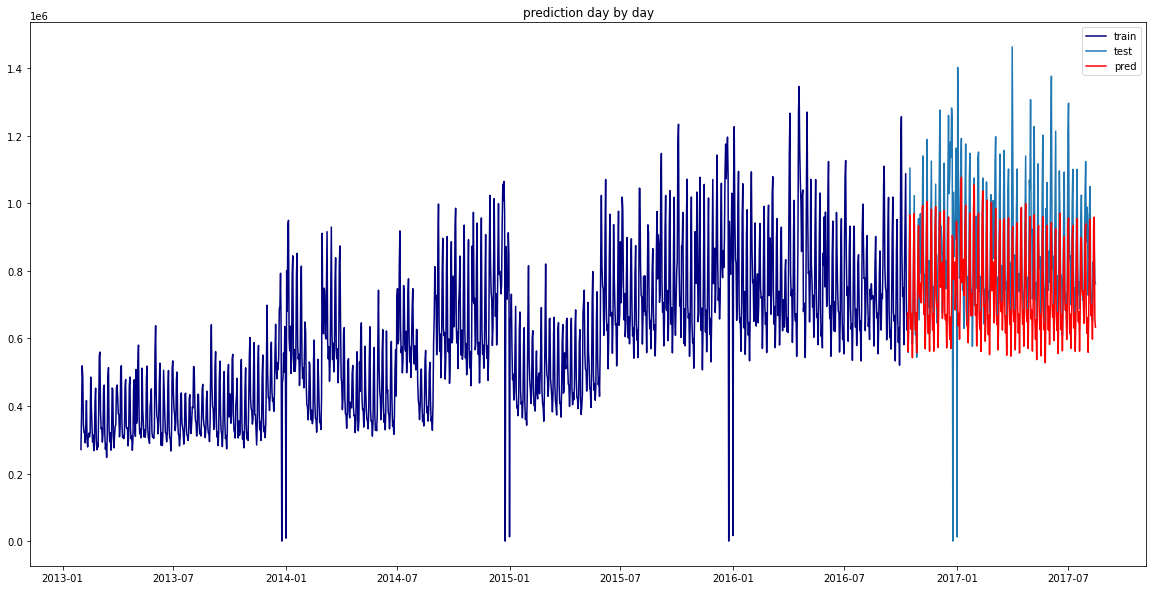

In [48]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_lgbm_1by1, label = 'pred', color = 'red')
plt.legend()
plt.title('prediction day by day')
plt.show()

Our simple model seems to be better than even more complex XGB, so let's try find some betters parameters.

In [41]:
#let's define first some parameters for hyperopt
param_lgbm = {
    "learning_rate" : hp.loguniform("learning_rate", np.log(0.01), np.log(1)),
    "max_depth" : scope.int(hp.quniform("max_depth", 4,15,1)),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 0.5),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1),
    "min_child_weight" : scope.int(hp.quniform("min_child_weight", 2,6,1)),
    "objective" : hp.choice("objective", ['regression', 'regression_L2', 'tweedie'])
}

In [43]:
# model definition

def model_lgbm_hyp(X_train, Y_train, CV, num_eval, n_estimators  = 500):
    
    def objective(params):
        
        for i, (train_x, test_x) in enumerate(CV.split(X_train,Y_train)):
            x_train, x_val = X_train.iloc[train_x], X_train.iloc[test_x]
            y_train, y_val = Y_train[train_x], Y_train[test_x]
            evalset = [(x_val, y_val)]
            
            model = lgbm.LGBMRegressor(**params, n_jobs = -1, n_estimators = n_estimators)
            model.fit(x_train, y_train, eval_set= evalset,eval_metric = 'mae', early_stopping_rounds = 5, verbose = False )
            
            y_pred = model.predict(x_val, num_iteration = model.best_iteration_)
                    
            score = mean_absolute_error(y_val, y_pred)
            
            return {'loss' : score, 'status': STATUS_OK}
        
        
    params = param_lgbm
        
    trials = Trials()
        
    best_params = fmin(objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = num_eval,
                        trials = trials)
        
    hyperparams = space_eval(params, best_params)
        
    print('the best params: ', hyperparams)
        
    return hyperparams

In [108]:
best_params_lgbm = model_lgbm_hyp(x_train_xgb, y_train_xgb, CV = tscv, num_eval = 5000, n_estimators  = 1000)

100%|█████| 5000/5000 [47:39<00:00,  1.75trial/s, best loss: 84438.72730797261]
the best params:  {'colsample_bytree': 0.7818409732129254, 'learning_rate': 0.4082957748876743, 'max_depth': 7, 'min_child_weight': 4, 'objective': 'regression_L2', 'reg_lambda': 0.1371715592395674}


In [109]:
best_model_lgbm = lgbm.LGBMRegressor(**best_params_lgbm,n_estimators  = 500)
best_model_lgbm.fit(x_train_xgb, y_train_xgb, eval_set = [(x_test_xgb, y_test_xgb)],eval_metric = 'mae', early_stopping_rounds = 5, verbose = False )

LGBMRegressor(colsample_bytree=0.7818409732129254,
              learning_rate=0.4082957748876743, max_depth=7, min_child_weight=4,
              n_estimators=500, objective='regression_L2',
              reg_lambda=0.1371715592395674)

In [110]:
y_pred_lgbm_best_1by1 = updated_seq(y_train_xgb, best_model_lgbm, seq_dates = x_test_xgb[['type']], seq_len = len(x_test_xgb))
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_lgbm_best_1by1 ),3))

test r2_score is 0.286


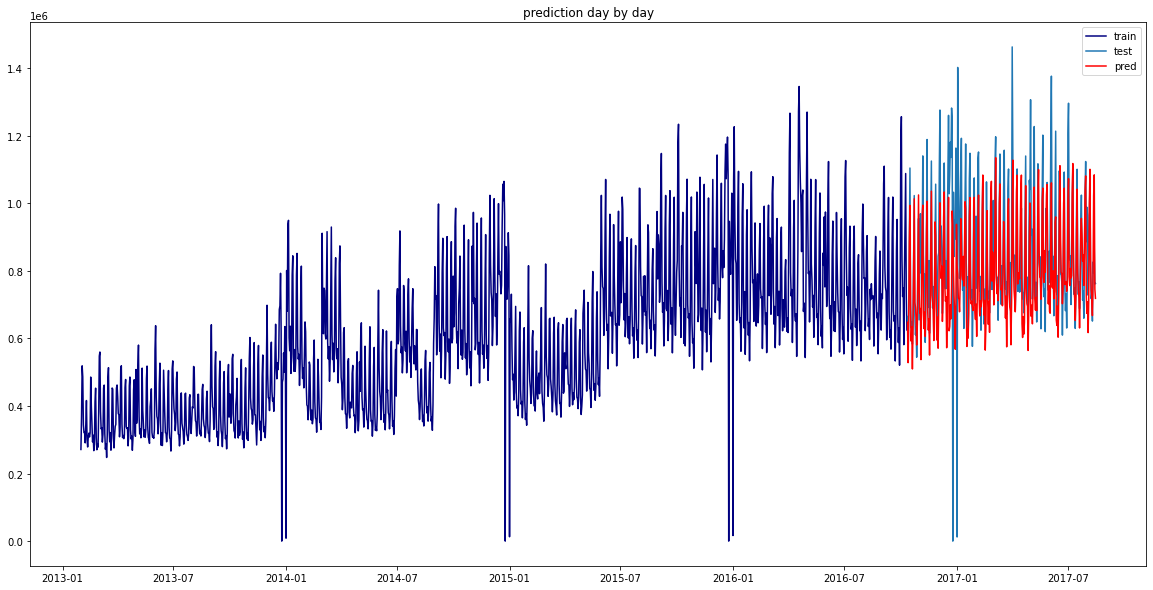

In [111]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_lgbm_best_1by1, label = 'pred', color = 'red')
plt.legend()
plt.title('prediction day by day')
plt.show()

As we can see our improved LGBM model follow the trend, maybe not so good as a prophet model, but much better as XGB. 

**Let's now try to forecast on grouped, weekly data.**

**9. Weekly data approach**

a) data preparation

In [45]:
df_weekly = df[:-2].resample('w').sum()
#we drop last two observation due to not full week representation

b) feature enginering

In [408]:
df_weekly['num_week'] = df_weekly.index.week
df_weekly['year'] = df_weekly.index.year
df_weekly['sales_1week_ago'] = df_weekly['sales'].shift(1)
df_weekly['sales_4week_ago'] =  df_weekly['sales'].shift(4)
df_weekly['sales_30week_ago'] = df_weekly['sales'].shift(30)
df_weekly['sales_52week_ago'] =  df_weekly['sales'].shift(52)
#sales for last year make our dataset too small

c) stationarity test

In [108]:
# Let's check whether our data is stationary or not

# ADF test for 'sale' variable
result_adf_week = sts.adfuller(df_weekly['sales'])
print('p_value = ', result_adf_week[1])

p_value =  0.5668927287366256


As we can see our data isn't stationarity, so we need to transform it

In [409]:
#so let's check if data will be stationary after first order differencing
df_weekly['sales_diff'] = df_weekly['sales'].diff(1).dropna()
result_adf_week_diff = sts.adfuller(df_weekly['sales_diff'][1:])
print('p_value = ', result_adf_week_diff[1])

p_value =  5.68014207532168e-05


Ok now our data is stationary after first order differencing

d) white noise test

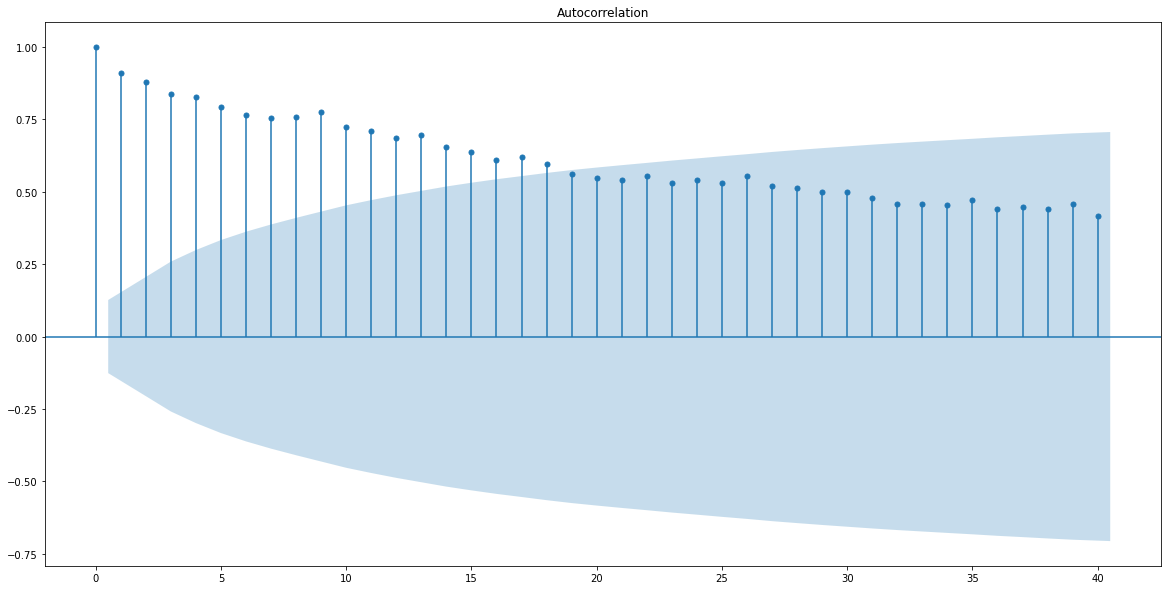

In [32]:
sgt.plot_acf(df_weekly['sales'], lags = 40)
plt.show()

Despite our data isn't stationary, there isn't also white noise. 

e) random walk test

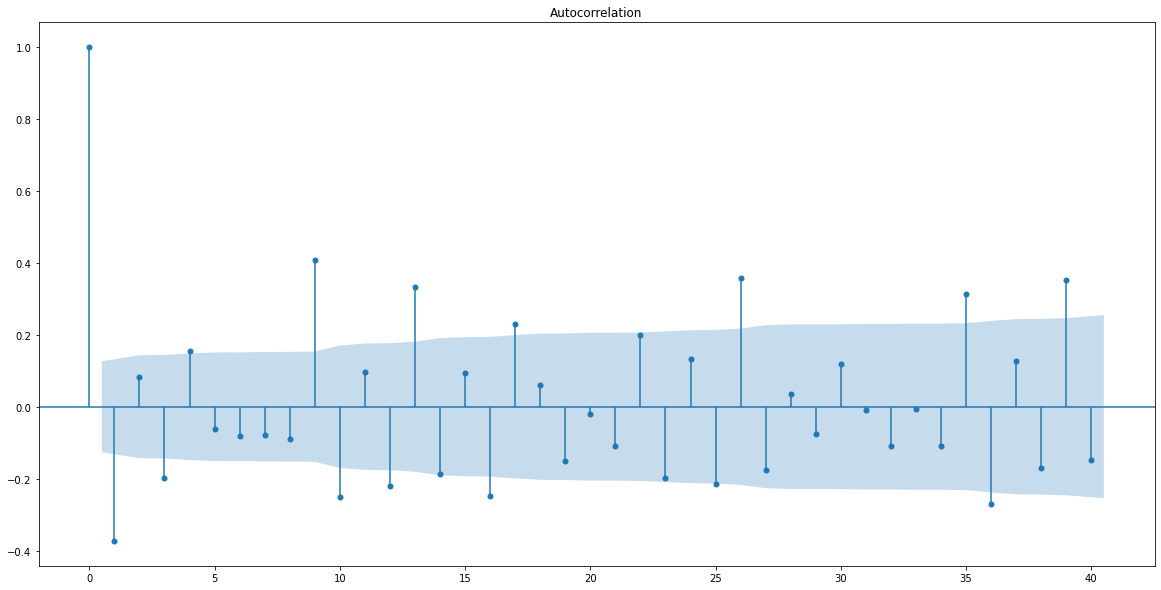

In [365]:
#let's check autocorralation our differenced data
sgt.plot_acf(df_weekly['sales_diff'][1:],lags =40)
plt.show()

There are some autocorrelation, so we can't talk about random walk. 

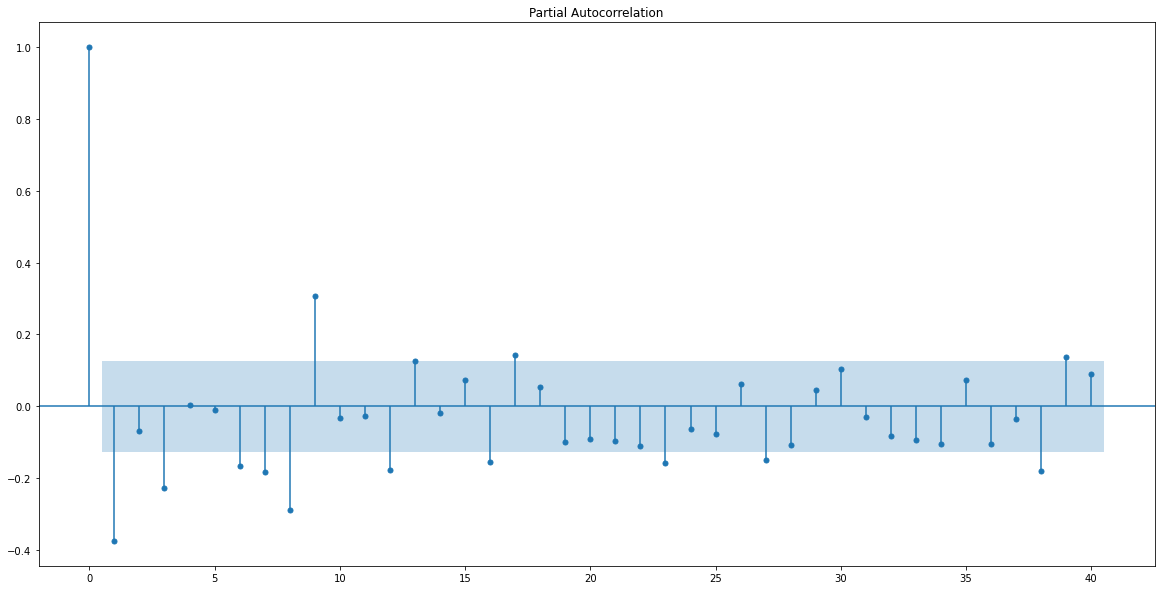

In [368]:
#let's see also partial autocorralation our differenced data
sgt.plot_pacf(df_weekly['sales_diff'][1:],lags =40)
plt.show()

We haven't see on first sight any seasonal effects among 40 lags, but let's do trend decomposition.

According to those plot, we will consider, during creating Arima models, following paramters:  
p= 1, but also 3 
q = 1 but also 3 or 4

f) trend decomposition

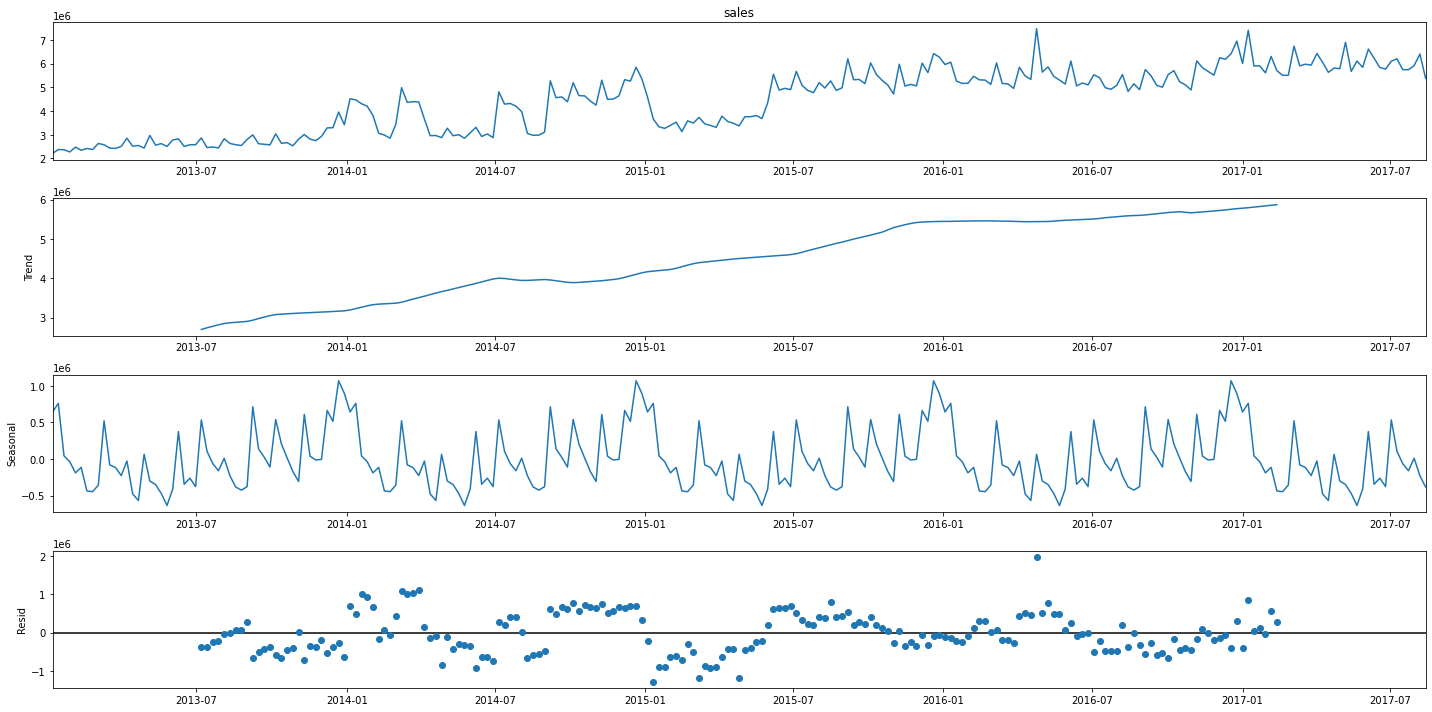

In [320]:
week_decomp = seasonal_decompose(df_weekly['sales'])
week_decomp.plot()
plt.show()

As we can see there is yearly seasonal trend, after each 52 weeks.  
We see also that there is an anomaly point in our data set, in April 2016, when, according to online information was Earthquake, which had impact on sale in 16th week this year.  
Let's smooth this data

g) outlier transformation

In [410]:
following_periods_mean = df_weekly[(df_weekly['year'] == 2016) & (df_weekly['num_week'].isin([15,17]))]['sales'].mean()
df_weekly.loc[(df_weekly['year'] == 2016) & (df_weekly['num_week']==16), 'sales'] = following_periods_mean

Outlier values has been replaced with mean from two nearest values

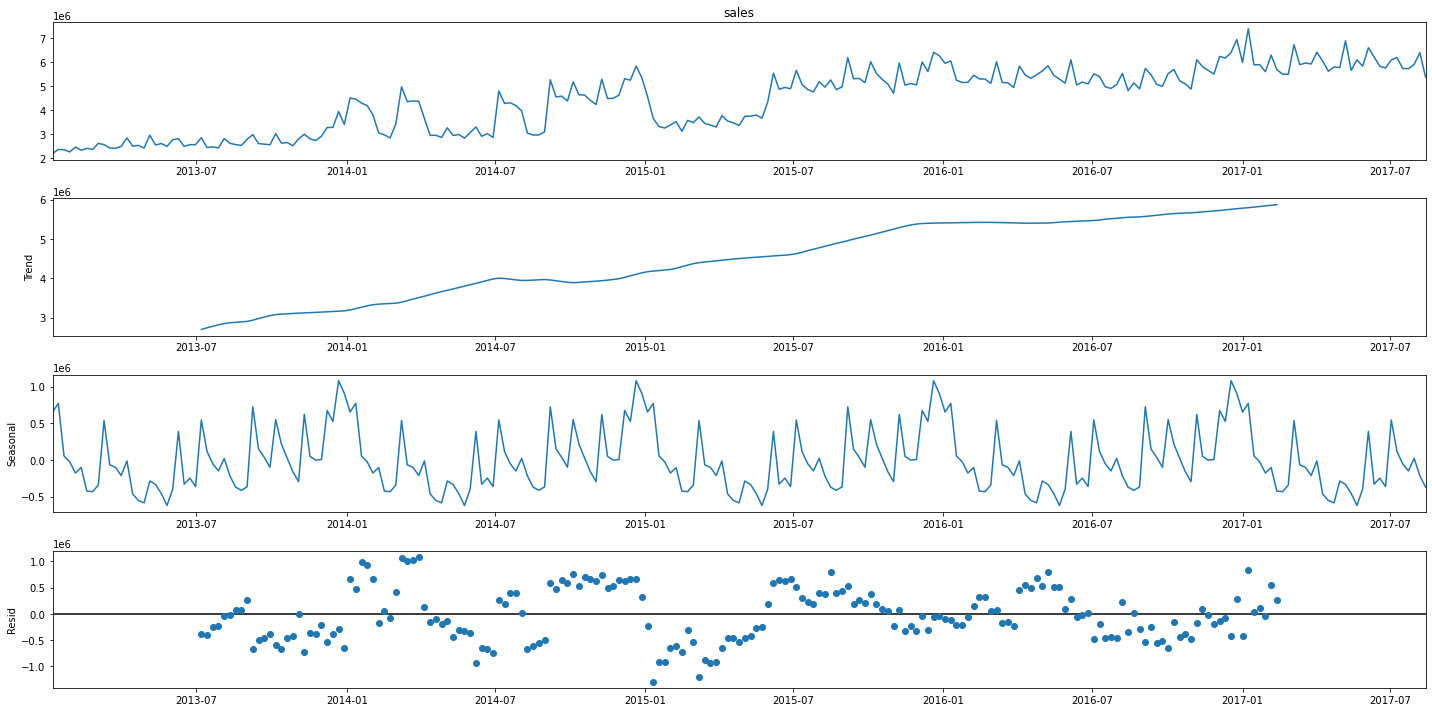

In [322]:
week_decomp = seasonal_decompose(df_weekly['sales'])
week_decomp.plot()
plt.show()

Now it's looks better

h) saesonal stationarity test

In [329]:
seasonal_adf_weekly = sts.adfuller(week_decomp.seasonal)
print('p_value = ', seasonal_adf_weekly[1])

p_value =  1.0212183282840832e-05


Ok, data is completely stationary

i) train/test split

In [411]:
treshold_week = int(len(df_weekly)*0.8)
x_train_weekly= df_weekly[:treshold_week]
x_test_weekly = df_weekly[treshold_week:]
print("train size: ", len(x_train_weekly), "\n",
      "test size: ",  len(x_test_weekly))

train size:  192 
 test size:  49


j) wizualization

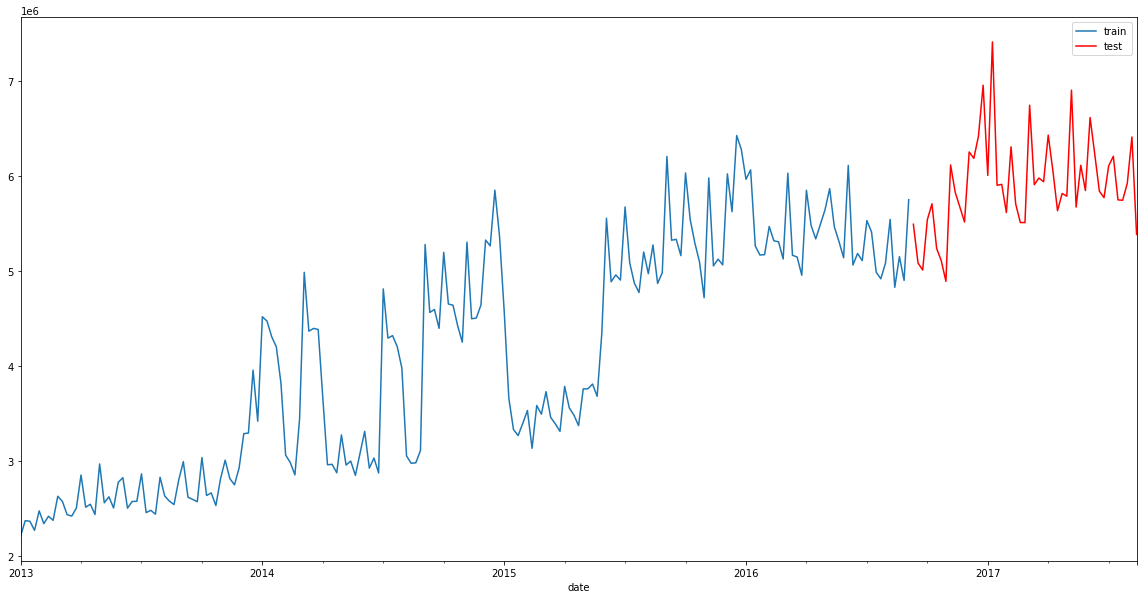

In [84]:
x_train_weekly.sales.plot(label = 'train')
x_test_weekly.sales.plot(label = 'test', color = 'red')
plt.legend()
plt.show()

k) modeling

**- AUTO-ARIMA**

In [442]:
model_auto_weekly = auto_arima(
    x_train_weekly['sales'][4:],
    exogenous = x_train_weekly[['num_week','sales_1week_ago','sales_4week_ago']][4:], 
    m = 5,
    seasonal = True,
    start_p = 3,
    start_q = 3,
    #max_p = 3,
   # max_q = 3,
   # d = 1,
    D = 0,
    maxiter= 110,
    #n_jobs = -1,
    trend = 'ct',
    out_of_sample = int(len(train)*0.2),
    error_action = 'ignore',
    stepwise =True,
    trace = True)    

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(1,0,1)[5] intercept   : AIC=5442.885, Time=5.20 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=5455.736, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=5449.218, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=5446.156, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=5455.736, Time=0.09 sec
 ARIMA(3,0,3)(0,0,1)[5] intercept   : AIC=5444.228, Time=3.29 sec
 ARIMA(3,0,3)(1,0,0)[5] intercept   : AIC=5444.907, Time=3.66 sec
 ARIMA(3,0,3)(2,0,1)[5] intercept   : AIC=5441.100, Time=9.45 sec
 ARIMA(3,0,3)(2,0,0)[5] intercept   : AIC=5438.761, Time=4.63 sec
 ARIMA(2,0,3)(2,0,0)[5] intercept   : AIC=5437.470, Time=3.08 sec
 ARIMA(2,0,3)(1,0,0)[5] intercept   : AIC=5443.588, Time=3.25 sec
 ARIMA(2,0,3)(2,0,1)[5] intercept   : AIC=5438.867, Time=7.20 sec
 ARIMA(2,0,3)(1,0,1)[5] intercept   : AIC=5444.336, Time=4.08 sec
 ARIMA(1,0,3)(2,0,0)[5] intercept   : AIC=5435.768, Time=4.17 sec
 ARIMA(1,0,3)(1,0,0)[5] intercept

In [428]:
auto_pred_weekly = pd.DataFrame({
    'index' : x_test_weekly.index,
    'result': model_auto_weekly.predict(n_periods= len(x_test_weekly[x_test_weekly.index[0]:x_test_weekly.index[-1]]),
                                        exogenous = x_test_weekly[['num_week','sales_1week_ago','sales_4week_ago','sales_30week_ago','sales_52week_ago']],
                                       )}).set_index('index')

print('R2 score test is: ', round(r2_score(x_test_weekly['sales'], auto_pred_weekly['result']),3))

R2 score test is:  0.399


In [430]:
model_auto_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  140
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 5)   Log Likelihood               -2019.301
Date:                             Sat, 14 May 2022   AIC                           4060.601
Time:                                     16:49:22   BIC                           4092.959
Sample:                                 01-05-2014   HQIC                          4073.750
                                      - 09-04-2016                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         2.877e+04   1.11e+05      0.259      0.795   -1.89e+05    2.46e+05
drift             -463.2674   1160.537     -0.399      0.690   -2737.877    1811.342
num_week          8698.8133   3450.418      2.521      0.012    1936.117    1.55e+04
sales_1week_ago      0.2416      0.184      1.313      0.189      -0.119       0.602
sales_4week_ago      0.0637      0.095      0.673      0.501      -0.122       0.249
sales_30week_ago     0.2089      0.094      2.220      0.026       0.024       0.393
sales_52week_ago     0.5711      0.097      5.891      0.000       0.381       0.761
ar.L1                0.5289      0.203      2.601      0.009       0.130       0.927
ar.L2                0.3264      0.196      1.666      0.096      -0.058       0.710
ma.S.L5             -0.3335      0.109     -3.059      0.002      -0.547      -0.120
sigma2            2.209e+11      0.244   9.05e+11      0.000    2.21e+11    2.21e+11
===================================================================================
Ljung-Box (Q):                       51.64   Jarque-Bera (JB):               126.37
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             1.40
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+27. Standard errors may be unstable.
"""

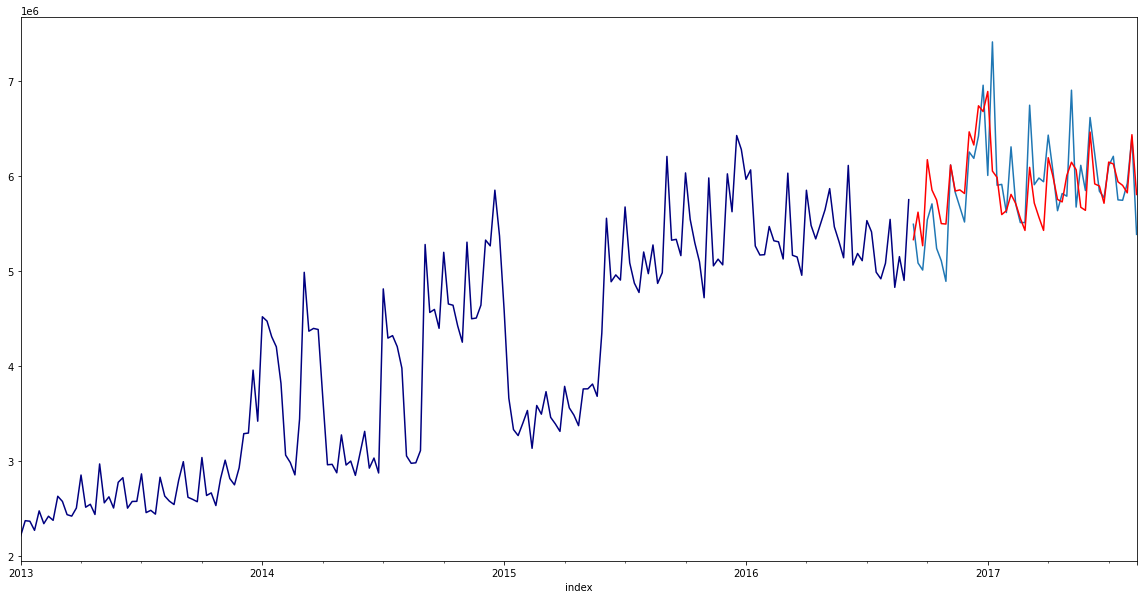

In [429]:
#and plot the results
x_test_weekly['sales'].plot()
x_train_weekly['sales'].plot(color= 'navy')
auto_pred_weekly['result'].plot(color = 'red')

plt.show()

Our best SARIMAX model perform better on 5 week seasonal period

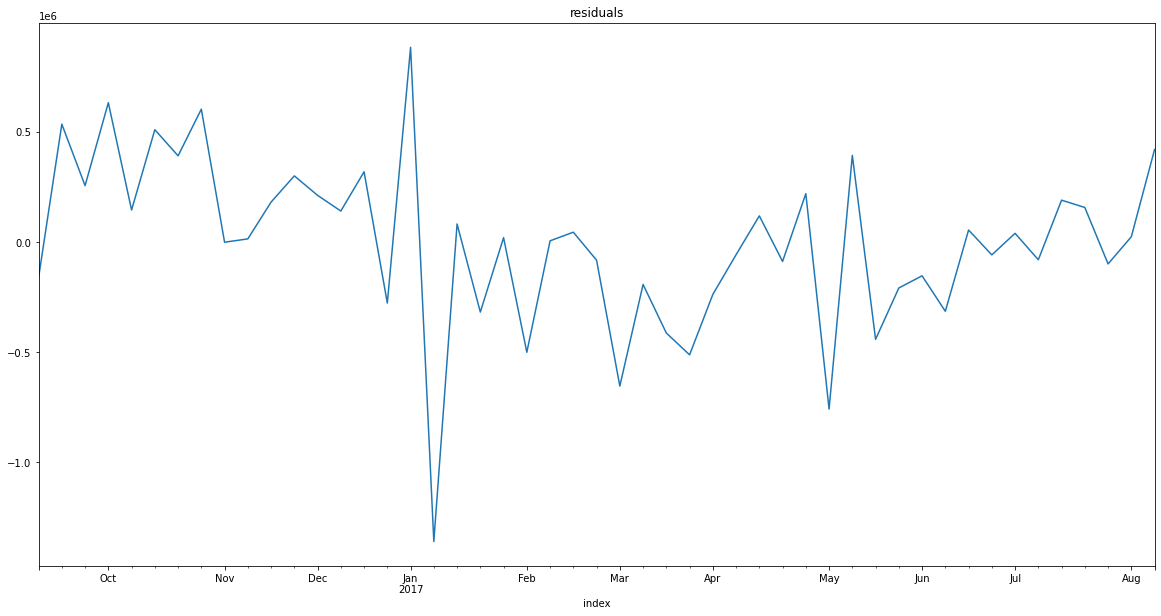

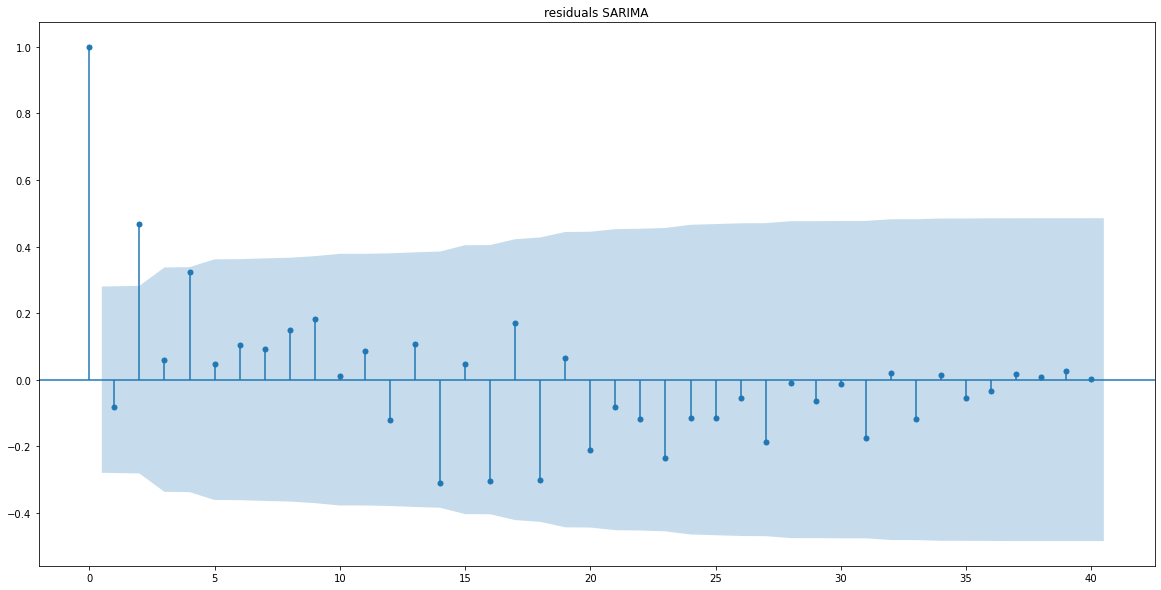

In [431]:
#let's see how our residuals look.

resid_autoarima_weekly =auto_pred_weekly['result']-x_test_weekly['sales']

resid_autoarima_weekly.plot()
plt.title('residuals')

sgt.plot_acf(resid_autoarima_weekly, lags = 40)
plt.title('residuals SARIMA')

plt.show()

It seems that our model perform very good, only 2nd lag is significant

**- Prophet**

In [35]:
#first we have to prepare our dataset 
train_df_weekly = x_train_weekly[['sales','num_week','sales_1week_ago','sales_4week_ago']].dropna().reset_index()
train_df_weekly.rename(columns = {'date': 'ds', 'sales': 'y'}, inplace = True)

test_df_weekly = x_test_weekly[['sales','num_week','sales_1week_ago','sales_4week_ago']].dropna().reset_index()
test_df_weekly.rename(columns = {'date': 'ds', 'sales': 'y'}, inplace = True)

In [86]:
prophet_model_weekly = Prophet(
    yearly_seasonality= True,
    weekly_seasonality= False,
    daily_seasonality= False,
    interval_width= 0.95
)
prophet_model_weekly.add_regressor('num_week')
prophet_model_weekly.add_regressor('sales_1week_ago')
prophet_model_weekly.add_regressor('sales_4week_ago')
prophet_model_weekly.fit(train_df_weekly)

In [87]:
prophet_cv = cross_validation(
    prophet_model_weekly,
    horizon= '63 days',
    initial = '730 days'
)

INFO:fbprophet:Making 17 forecasts with cutoffs between 2015-02-15 00:00:00 and 2016-07-03 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

In [88]:
print('R2 score cross validation is: ', round(r2_score(prophet_cv['y'], prophet_cv['yhat']),3))

R2 score cross validation is:  0.594


In [89]:
forecast_weekly = prophet_model_weekly.predict(test_df_weekly)
forecast_train_weekly = prophet_model_weekly.predict(train_df_weekly)

In [90]:
print('R2 score train is: ', round(r2_score(train_df_weekly['y'], forecast_train_weekly['yhat']),3))
print('R2 score test is: ', round(r2_score(test_df_weekly['y'], forecast_weekly['yhat']),3))

R2 score train is:  0.872
R2 score test is:  0.123


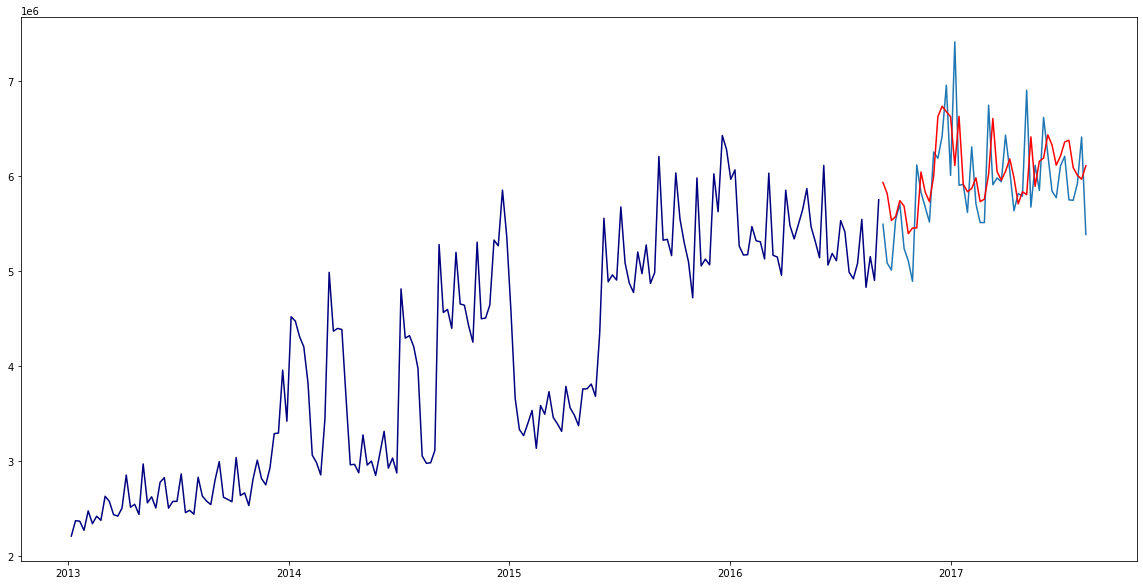

In [614]:
#plot
plt.plot(x_test_weekly.index, x_test_weekly['sales'])
plt.plot(x_train_weekly.index, x_train_weekly['sales'],color= 'navy')
plt.plot(forecast_weekly['ds'],forecast_weekly['yhat'],color = 'red')
plt.figsize = (20,10)
plt.show()


As we can see our prophet model for weekly data, even with exogenous variables don't perform better than our previous SARIMAX weekly model.

**- LightGBM**

In [147]:
#let's first prepare our input data
df_lgbm_all = df_weekly.copy()

df_lgbm_all['sales_5week_ago'] =  df_lgbm_all['sales'].shift(5)
df_lgbm_all['sales_8week_ago'] =  df_lgbm_all['sales'].shift(8)
df_lgbm_all['sales_26week_ago'] =  df_lgbm_all['sales'].shift(26)
df_lgbm_all['sales_52week_ago'] =  df_lgbm_all['sales'].shift(52)

df_lgbm = df_lgbm_all.dropna()

del df_lgbm['sales'],df_lgbm['year'], df_lgbm['sales_diff'], df_lgbm['num_week']

trs= int(len(df_lgbm.dropna())*0.8)

x_train_lgbm_weekly = df_lgbm.iloc[:trs,:]
x_test_lgbm_weekly  = df_lgbm.iloc[trs:,:]

y_train_lgbm_weekly = df_lgbm_all.dropna()['sales'].iloc[:trs]
y_test_lgbm_weekly  = df_lgbm_all.dropna()['sales'].iloc[trs:]

print('train size lenght is: ', len(x_train_lgbm_weekly), '\n'
     'test_size lenght is: ', len(x_test_lgbm_weekly))

train size lenght is:  151 
test_size lenght is:  38


In [148]:
#let's define first some parameters for hyperopt
param_lgbm_weekly = {
    "learning_rate" : hp.loguniform("learning_rate", np.log(0.01), np.log(1)),
    "max_depth" : scope.int(hp.quniform("max_depth", 2,15,1)),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 0.5),
    #"colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1),
    "min_child_weight" : scope.int(hp.quniform("min_child_weight", 2,6,1)),
    "objective" : hp.choice("objective", ['regression'])
}

In [149]:
#cross validation definition
tscv_weekly = TimeSeriesSplit(n_splits = 3)

In [150]:
# model definition
def model_lgbm_hyp_weekly(X_train, Y_train, CV, num_eval, n_estimators  = 500):
    
    def objective(params):
        
        for i, (train_x, test_x) in enumerate(CV.split(X_train,Y_train)):
            x_train, x_val = X_train.iloc[train_x], X_train.iloc[test_x]
            y_train, y_val = Y_train[train_x], Y_train[test_x]
            evalset = [(x_val, y_val)]
            
            model = lgbm.LGBMRegressor(**params, n_jobs = -1, n_estimators = n_estimators)
            model.fit(x_train, y_train, eval_set= evalset,eval_metric = 'mae', early_stopping_rounds = 5, verbose = False )
            
            y_pred = model.predict(x_val, num_iteration = model.best_iteration_)
                    
            score = mean_absolute_error(y_val, y_pred)
            
            return {'loss' : score, 'status': STATUS_OK}
        
        
    params = param_lgbm_weekly
        
    trials = Trials()
        
    best_params = fmin(objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = num_eval,
                        trials = trials,
                        verbose = 2)
        
    hyperparams = space_eval(params, best_params)
        
    print('the best params: ', hyperparams)
        
    return hyperparams

In [151]:
best_params_lgbm_weekly = model_lgbm_hyp_weekly(x_train_lgbm_weekly, y_train_lgbm_weekly, CV = tscv_weekly, num_eval = 50, n_estimators  = 1000)

100%|██████████| 50/50 [00:04<00:00, 12.34trial/s, best loss: 651327.554472665]
the best params:  {'learning_rate': 0.04680647596543203, 'max_depth': 6, 'min_child_weight': 6, 'objective': 'regression', 'reg_lambda': 0.4541521802668129}


In [152]:
best_model_lgbm_weekly = lgbm.LGBMRegressor(**best_params_lgbm_weekly, n_jobs = -1, n_estimators = 500)
best_model_lgbm_weekly.fit(x_train_lgbm_weekly, y_train_lgbm_weekly)

LGBMRegressor(learning_rate=0.04680647596543203, max_depth=6,
              min_child_weight=6, n_estimators=500, objective='regression',
              reg_lambda=0.4541521802668129)

In [153]:
# funtion definition which return y_pred for choosen period based on self, prior predictions
def updated_seq_weekly(y, model, seq_dates, seq_len):
    
    '''
    y - timeseries for past periods
    model - LGBMmodel which will be use to predict
    seq_dates - data frame which contain date as an index .
            Notice seq_dates, should be long or equal to seq_len
    
    
    seq_len - number of periods to predict ahead.
            Notice seq_len can't be longer than seq_dates
    
    '''
    
    y_updated =pd.DataFrame(y.copy())
    y_pred_1by1_weekly = []
    
    for i in range(seq_len):
        x_test_1by1 = pd.DataFrame({'sales_1week_ago': y_updated['sales'][-1],
                                    'sales_4week_ago': y_updated['sales'][-4],
                                    'sales_5week_ago': y_updated['sales'][-5],
                                    'sales_8week_ago': y_updated['sales'][-8],
                                    'sales_26week_ago': y_updated['sales'][-26],
                                    'sales_52week_ago': y_updated['sales'][-52]
                                    },
                                    index = [seq_dates.index[i]])
    
        y_pred = model.predict(x_test_1by1)
        
        new_row = pd.DataFrame({'sales' :y_pred}, index = [x_test_1by1.index[0]])
        y_pred_1by1_weekly = np.concatenate([y_pred_1by1_weekly,y_pred])
    
        y_updated = pd.concat([y_updated,new_row])
        
        
    return y_pred_1by1_weekly

In [154]:
#let's predict future values
y_pred_lgbm_best_1by1_weekly = updated_seq_weekly(y_train_lgbm_weekly, best_model_lgbm_weekly, seq_dates = x_test_lgbm_weekly, seq_len = len(x_test_lgbm_weekly))
print('test r2_score is', round(r2_score(y_test_lgbm_weekly, y_pred_lgbm_best_1by1_weekly ),3))

test r2_score is -0.114


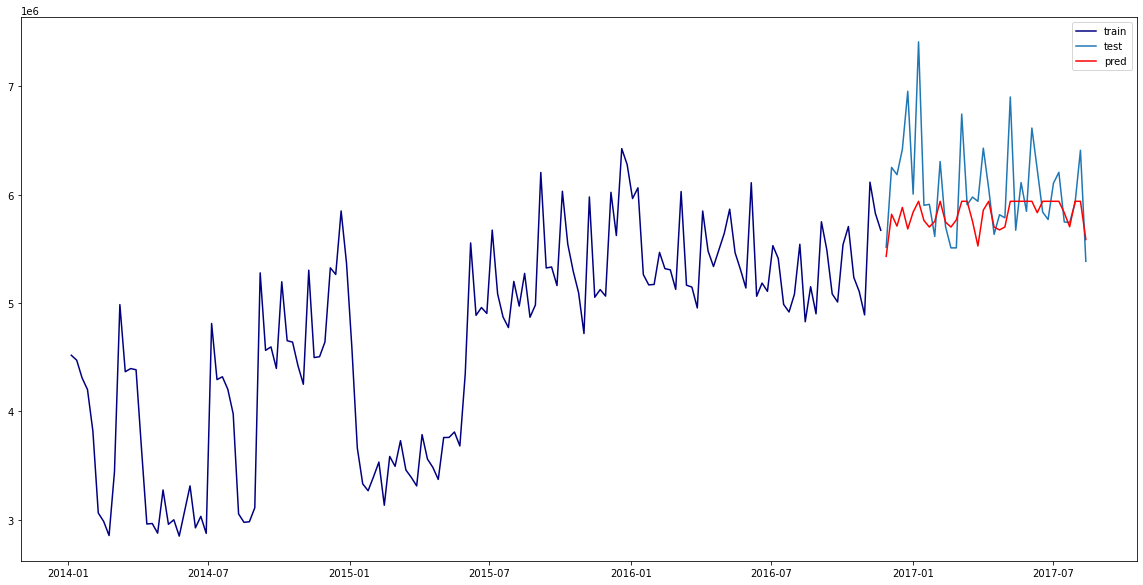

In [155]:
# check or residuals
resid_lgbm_weekly = y_pred_lgbm_best_1by1_weekly - y_test_lgbm_weekly

plt.plot(x_train_lgbm_weekly.index, y_train_lgbm_weekly, label = 'train', color = 'navy')
plt.plot(x_test_lgbm_weekly.index, y_test_lgbm_weekly, label = 'test')
plt.plot( x_test_lgbm_weekly.index,y_pred_lgbm_best_1by1_weekly, label = 'pred', color = 'red')
plt.legend()
plt.show()

As we can see LGBMRegressor perform much worse on weekly data compare to other models.  
The reason is that we have few data points to get good prediction using this model.

**-LSTM**

a) data preparation

In [329]:
tf.random.set_seed(2)

In [348]:
#let's normalize our data to get best results
train_X_weekly = np.array(x_train_weekly['sales']).reshape(-1,1)
test_X_weekly = np.array(x_test_weekly['sales']).reshape(-1,1)
minmax_scaler_weekly = MinMaxScaler().fit(train_X_weekly)
X_train_norm_weekly = minmax_scaler_weekly.transform(train_X_weekly)
X_test_norm_weekly = minmax_scaler_weekly.transform(test_X_weekly)

train_norm_weekly = x_train_weekly.copy()
test_norm_weekly = x_test_weekly.copy()

train_norm_weekly['sales'] = X_train_norm_weekly
test_norm_weekly['sales'] = X_test_norm_weekly

#let's again concate our train and test data to prepare sequential data, and finally split it into train and test
all_df_weekly = pd.concat([train_norm_weekly, test_norm_weekly])

#let's create extra features based on normalized values
del all_df_weekly['sales_1week_ago'], all_df_weekly['sales_4week_ago']

all_df_weekly['sales_1week_ago'] =  all_df_weekly['sales'].shift(1)
all_df_weekly['sales_5week_ago'] =  all_df_weekly['sales'].shift(5)
all_df_weekly['sales_8week_ago'] =  all_df_weekly['sales'].shift(8)
all_df_weekly['sales_26week_ago'] =  all_df_weekly['sales'].shift(26)
all_df_weekly['sales_52week_ago'] =  all_df_weekly['sales'].shift(52)

In [349]:
# #let's create sequential data, using function defined earlier
# xSeq_weekly, y_weekly = convert_to_seq(all_df_weekly['sales'], 8,1)
# xSeq_weekly.shape, y_weekly.shape

In [354]:
#let's create sequential data, using function defined earlier
xSeq_weekly, y_weekly = convert_to_seq(
    #all_df_weekly[['sales','sales_1week_ago','sales_5week_ago', 'sales_52week_ago']].dropna(), 
    all_df_weekly['sales'],
    5,1)
xSeq_weekly.shape, y_weekly.shape

((236, 5, 1), (231, 1))

As we can see our xSeq_weekly lenght is bigger than y_weekly, because of nature of sequence.  
So we won't have targets for our last 5 observations.  
Let's split our data set on train, test, and last 5 observations without targets

In [355]:
treshold_seq_weekly = int(len(y_weekly)*0.8)

train_xSeq_weekly = xSeq_weekly[:treshold_seq_weekly]
test_xSeq_weekly  = xSeq_weekly[treshold_seq_weekly:y_weekly.shape[0]]
future_xSeq_weekly =xSeq_weekly[y_weekly.shape[0]:]

train_y_weekly = y_weekly[:treshold_seq_weekly]
test_y_weekly = y_weekly[treshold_seq_weekly:]


train_xSeq_weekly.shape, test_xSeq_weekly.shape, future_xSeq_weekly.shape, train_y_weekly.shape, test_y_weekly.shape

((184, 5, 1), (47, 5, 1), (5, 5, 1), (184, 1), (47, 1))

b) modeling

In [352]:
params_weekly = {'units_lstm': [4,8,16, 32],
          'layers_num': [2,3,4],
          'dropout_lstm': [0,0.2,0.3, 0.5],
          'dropout_out': [0.2,0.5],
         }

In [195]:
data_weekly = pd.DataFrame({'name' : [],
       'result': []})

for units_lstm in params_weekly['units_lstm']:
    for layers_num in params_weekly['layers_num']:
        for dropout_lstm in params_weekly['dropout_lstm']:
            for dropout_out in params_weekly['dropout_out']:
               
                model_weekly = model_lstm(train_xSeq_weekly, train_y_weekly, test_xSeq_weekly, test_y_weekly, units_lstm= units_lstm, seq_len = 5,
                   dropout_lstm = dropout_lstm, dropout_out = dropout_out, layers_num = layers_num, num_feature = 1, epoch = 50)
                
                
                y_pred_weekly = model_weekly.predict(test_xSeq_weekly)
                y_pred_train_weekly = model_weekly.predict(train_xSeq_weekly)
                
                result = r2_score(test_y_weekly, y_pred_weekly)
                
                data_weekly = data_weekly.append({'name' : f' model_units_{units_lstm}_layers_{layers_num}_drop_lstm_{dropout_lstm}_drop_{dropout_out}',
                    'result' : result}, ignore_index = True)
                                   
                data_weekly.sort_values('result', ascending = False)

Epoch 1/50
37/37 - 15s - loss: 0.1779 - val_loss: 0.3500
Epoch 2/50
37/37 - 7s - loss: 0.0828 - val_loss: 0.1412
Epoch 3/50
37/37 - 7s - loss: 0.0571 - val_loss: 0.1004
Epoch 4/50
37/37 - 7s - loss: 0.0555 - val_loss: 0.0797
Epoch 5/50
37/37 - 7s - loss: 0.0519 - val_loss: 0.0623
Epoch 6/50
37/37 - 7s - loss: 0.0503 - val_loss: 0.0475
Epoch 7/50
37/37 - 7s - loss: 0.0443 - val_loss: 0.0468
Epoch 8/50
37/37 - 7s - loss: 0.0361 - val_loss: 0.0363
Epoch 9/50
37/37 - 7s - loss: 0.0295 - val_loss: 0.0412
Epoch 10/50
37/37 - 7s - loss: 0.0412 - val_loss: 0.0347
Epoch 11/50
37/37 - 7s - loss: 0.0331 - val_loss: 0.0281
Epoch 12/50
37/37 - 7s - loss: 0.0327 - val_loss: 0.0257
Epoch 13/50
37/37 - 7s - loss: 0.0258 - val_loss: 0.0275
Epoch 14/50
37/37 - 7s - loss: 0.0364 - val_loss: 0.0347
Epoch 15/50
37/37 - 7s - loss: 0.0381 - val_loss: 0.0331
Epoch 1/50
37/37 - 16s - loss: 0.1467 - val_loss: 0.2648
Epoch 2/50
37/37 - 7s - loss: 0.0766 - val_loss: 0.1518
Epoch 3/50
37/37 - 7s - loss: 0.0804 - v

Epoch 6/50
37/37 - 6s - loss: 0.0466 - val_loss: 0.0667
Epoch 7/50
37/37 - 6s - loss: 0.0439 - val_loss: 0.0582
Epoch 8/50
37/37 - 6s - loss: 0.0413 - val_loss: 0.0288
Epoch 9/50
37/37 - 6s - loss: 0.0416 - val_loss: 0.0378
Epoch 10/50
37/37 - 7s - loss: 0.0357 - val_loss: 0.0328
Epoch 11/50
37/37 - 6s - loss: 0.0387 - val_loss: 0.0328
Epoch 1/50
37/37 - 17s - loss: 0.2737 - val_loss: 0.6628
Epoch 2/50
37/37 - 6s - loss: 0.1822 - val_loss: 0.4893
Epoch 3/50
37/37 - 6s - loss: 0.1301 - val_loss: 0.3401
Epoch 4/50
37/37 - 6s - loss: 0.1144 - val_loss: 0.2810
Epoch 5/50
37/37 - 6s - loss: 0.0907 - val_loss: 0.2405
Epoch 6/50
37/37 - 7s - loss: 0.1055 - val_loss: 0.2567
Epoch 7/50
37/37 - 6s - loss: 0.0887 - val_loss: 0.2074
Epoch 8/50
37/37 - 6s - loss: 0.0835 - val_loss: 0.1957
Epoch 9/50
37/37 - 6s - loss: 0.0774 - val_loss: 0.1503
Epoch 10/50
37/37 - 6s - loss: 0.0769 - val_loss: 0.1096
Epoch 11/50
37/37 - 6s - loss: 0.0598 - val_loss: 0.0914
Epoch 12/50
37/37 - 6s - loss: 0.0533 - val

Epoch 7/50
37/37 - 6s - loss: 0.0877 - val_loss: 0.1945
Epoch 8/50
37/37 - 8s - loss: 0.0748 - val_loss: 0.1720
Epoch 9/50
37/37 - 7s - loss: 0.0746 - val_loss: 0.1243
Epoch 10/50
37/37 - 7s - loss: 0.0838 - val_loss: 0.1336
Epoch 11/50
37/37 - 7s - loss: 0.0740 - val_loss: 0.1287
Epoch 12/50
37/37 - 9s - loss: 0.0660 - val_loss: 0.0974
Epoch 13/50
37/37 - 7s - loss: 0.0603 - val_loss: 0.0627
Epoch 14/50
37/37 - 6s - loss: 0.0594 - val_loss: 0.0652
Epoch 15/50
37/37 - 8s - loss: 0.0634 - val_loss: 0.0568
Epoch 16/50
37/37 - 7s - loss: 0.0562 - val_loss: 0.0698
Epoch 17/50
37/37 - 7s - loss: 0.0529 - val_loss: 0.0582
Epoch 18/50
37/37 - 7s - loss: 0.0601 - val_loss: 0.0538
Epoch 19/50
37/37 - 7s - loss: 0.0588 - val_loss: 0.0602
Epoch 20/50
37/37 - 7s - loss: 0.0555 - val_loss: 0.0571
Epoch 21/50
37/37 - 6s - loss: 0.0582 - val_loss: 0.0835
Epoch 1/50
37/37 - 27s - loss: 0.2246 - val_loss: 0.5220
Epoch 2/50
37/37 - 8s - loss: 0.1138 - val_loss: 0.2086
Epoch 3/50
37/37 - 9s - loss: 0.070

Epoch 11/50
37/37 - 6s - loss: 0.0641 - val_loss: 0.1317
Epoch 12/50
37/37 - 6s - loss: 0.0786 - val_loss: 0.1237
Epoch 13/50
37/37 - 6s - loss: 0.0803 - val_loss: 0.1080
Epoch 14/50
37/37 - 6s - loss: 0.0662 - val_loss: 0.1171
Epoch 15/50
37/37 - 6s - loss: 0.0643 - val_loss: 0.0747
Epoch 16/50
37/37 - 6s - loss: 0.0619 - val_loss: 0.0986
Epoch 17/50
37/37 - 6s - loss: 0.0498 - val_loss: 0.0601
Epoch 18/50
37/37 - 6s - loss: 0.0542 - val_loss: 0.0869
Epoch 19/50
37/37 - 6s - loss: 0.0472 - val_loss: 0.0448
Epoch 20/50
37/37 - 6s - loss: 0.0504 - val_loss: 0.0563
Epoch 21/50
37/37 - 6s - loss: 0.0577 - val_loss: 0.0575
Epoch 22/50
37/37 - 6s - loss: 0.0553 - val_loss: 0.0525
Epoch 1/50
37/37 - 15s - loss: 0.2103 - val_loss: 0.4348
Epoch 2/50
37/37 - 6s - loss: 0.0834 - val_loss: 0.1070
Epoch 3/50
37/37 - 6s - loss: 0.0583 - val_loss: 0.0625
Epoch 4/50
37/37 - 6s - loss: 0.0434 - val_loss: 0.0537
Epoch 5/50
37/37 - 6s - loss: 0.0374 - val_loss: 0.0359
Epoch 6/50
37/37 - 6s - loss: 0.033

Epoch 5/50
37/37 - 7s - loss: 0.0674 - val_loss: 0.0522
Epoch 6/50
37/37 - 6s - loss: 0.0511 - val_loss: 0.0594
Epoch 7/50
37/37 - 7s - loss: 0.0625 - val_loss: 0.0490
Epoch 8/50
37/37 - 6s - loss: 0.0444 - val_loss: 0.0502
Epoch 9/50
37/37 - 6s - loss: 0.0499 - val_loss: 0.0670
Epoch 10/50
37/37 - 7s - loss: 0.0520 - val_loss: 0.0414
Epoch 11/50
37/37 - 6s - loss: 0.0535 - val_loss: 0.0394
Epoch 12/50
37/37 - 6s - loss: 0.0509 - val_loss: 0.0586
Epoch 13/50
37/37 - 6s - loss: 0.0440 - val_loss: 0.0238
Epoch 14/50
37/37 - 6s - loss: 0.0377 - val_loss: 0.0208
Epoch 15/50
37/37 - 6s - loss: 0.0470 - val_loss: 0.0285
Epoch 16/50
37/37 - 6s - loss: 0.0393 - val_loss: 0.0302
Epoch 17/50
37/37 - 6s - loss: 0.0432 - val_loss: 0.0267
Epoch 1/50
37/37 - 17s - loss: 0.1931 - val_loss: 0.3389
Epoch 2/50
37/37 - 6s - loss: 0.0738 - val_loss: 0.0698
Epoch 3/50
37/37 - 6s - loss: 0.0574 - val_loss: 0.0531
Epoch 4/50
37/37 - 6s - loss: 0.0438 - val_loss: 0.0453
Epoch 5/50
37/37 - 6s - loss: 0.0352 - 

Epoch 3/50
37/37 - 6s - loss: 0.0901 - val_loss: 0.1828
Epoch 4/50
37/37 - 6s - loss: 0.0791 - val_loss: 0.1523
Epoch 5/50
37/37 - 6s - loss: 0.0733 - val_loss: 0.1018
Epoch 6/50
37/37 - 6s - loss: 0.0710 - val_loss: 0.0594
Epoch 7/50
37/37 - 7s - loss: 0.0534 - val_loss: 0.0759
Epoch 8/50
37/37 - 6s - loss: 0.0562 - val_loss: 0.0346
Epoch 9/50
37/37 - 6s - loss: 0.0628 - val_loss: 0.0527
Epoch 10/50
37/37 - 7s - loss: 0.0518 - val_loss: 0.0215
Epoch 11/50
37/37 - 6s - loss: 0.0523 - val_loss: 0.0424
Epoch 12/50
37/37 - 6s - loss: 0.0596 - val_loss: 0.0710
Epoch 13/50
37/37 - 6s - loss: 0.0477 - val_loss: 0.0322
Epoch 1/50
37/37 - 19s - loss: 0.1108 - val_loss: 0.0317
Epoch 2/50
37/37 - 6s - loss: 0.0331 - val_loss: 0.0355
Epoch 3/50
37/37 - 7s - loss: 0.0259 - val_loss: 0.0345
Epoch 4/50
37/37 - 6s - loss: 0.0275 - val_loss: 0.0211
Epoch 5/50
37/37 - 6s - loss: 0.0238 - val_loss: 0.0123
Epoch 6/50
37/37 - 6s - loss: 0.0263 - val_loss: 0.0130
Epoch 7/50
37/37 - 6s - loss: 0.0259 - val_

Epoch 1/50
37/37 - 17s - loss: 0.1669 - val_loss: 0.1750
Epoch 2/50
37/37 - 6s - loss: 0.0668 - val_loss: 0.0815
Epoch 3/50
37/37 - 7s - loss: 0.0562 - val_loss: 0.0253
Epoch 4/50
37/37 - 6s - loss: 0.0454 - val_loss: 0.0706
Epoch 5/50
37/37 - 6s - loss: 0.0419 - val_loss: 0.0472
Epoch 6/50
37/37 - 6s - loss: 0.0402 - val_loss: 0.0249
Epoch 7/50
37/37 - 6s - loss: 0.0480 - val_loss: 0.0187
Epoch 8/50
37/37 - 6s - loss: 0.0372 - val_loss: 0.0400
Epoch 9/50
37/37 - 6s - loss: 0.0387 - val_loss: 0.0431
Epoch 10/50
37/37 - 6s - loss: 0.0326 - val_loss: 0.0341
Epoch 1/50
37/37 - 18s - loss: 0.1608 - val_loss: 0.1631
Epoch 2/50
37/37 - 6s - loss: 0.0586 - val_loss: 0.1011
Epoch 3/50
37/37 - 6s - loss: 0.0528 - val_loss: 0.0826
Epoch 4/50
37/37 - 6s - loss: 0.0390 - val_loss: 0.0305
Epoch 5/50
37/37 - 6s - loss: 0.0328 - val_loss: 0.0135
Epoch 6/50
37/37 - 6s - loss: 0.0327 - val_loss: 0.0183
Epoch 7/50
37/37 - 6s - loss: 0.0330 - val_loss: 0.0274
Epoch 8/50
37/37 - 6s - loss: 0.0352 - val_lo

Epoch 6/50
37/37 - 6s - loss: 0.0268 - val_loss: 0.0126
Epoch 7/50
37/37 - 7s - loss: 0.0220 - val_loss: 0.0136
Epoch 8/50
37/37 - 6s - loss: 0.0245 - val_loss: 0.0214
Epoch 9/50
37/37 - 6s - loss: 0.0226 - val_loss: 0.0157
Epoch 1/50
37/37 - 14s - loss: 0.1378 - val_loss: 0.0237
Epoch 2/50
37/37 - 6s - loss: 0.0455 - val_loss: 0.0135
Epoch 3/50
37/37 - 6s - loss: 0.0342 - val_loss: 0.0201
Epoch 4/50
37/37 - 6s - loss: 0.0269 - val_loss: 0.0298
Epoch 5/50
37/37 - 6s - loss: 0.0309 - val_loss: 0.0122
Epoch 6/50
37/37 - 6s - loss: 0.0323 - val_loss: 0.0277
Epoch 7/50
37/37 - 6s - loss: 0.0283 - val_loss: 0.0200
Epoch 8/50
37/37 - 6s - loss: 0.0352 - val_loss: 0.0337
Epoch 1/50
37/37 - 15s - loss: 0.0874 - val_loss: 0.0296
Epoch 2/50
37/37 - 6s - loss: 0.0324 - val_loss: 0.0417
Epoch 3/50
37/37 - 6s - loss: 0.0287 - val_loss: 0.0126
Epoch 4/50
37/37 - 6s - loss: 0.0268 - val_loss: 0.0115
Epoch 5/50
37/37 - 6s - loss: 0.0261 - val_loss: 0.0114
Epoch 6/50
37/37 - 6s - loss: 0.0248 - val_los

In [274]:
data_weekly.sort_values('result', ascending = False)

name    result
56     model_units_16_layers_3_drop_lstm_0_drop_0.2  0.237425
81     model_units_32_layers_3_drop_lstm_0_drop_0.5  0.184367
82   model_units_32_layers_3_drop_lstm_0.2_drop_0.2  0.181878
48     model_units_16_layers_2_drop_lstm_0_drop_0.2  0.173825
51   model_units_16_layers_2_drop_lstm_0.2_drop_0.5  0.172949
..                                              ...       ...
17      model_units_4_layers_4_drop_lstm_0_drop_0.5 -3.135684
71   model_units_16_layers_4_drop_lstm_0.5_drop_0.5 -3.448526
7     model_units_4_layers_2_drop_lstm_0.5_drop_0.5 -3.796638
21    model_units_4_layers_4_drop_lstm_0.3_drop_0.5 -3.944878
15    model_units_4_layers_3_drop_lstm_0.5_drop_0.5 -4.300078

[96 rows x 2 columns]

In [356]:
#let's check our best lstm model with one feature
model_lstm_weekly = model_lstm(train_xSeq_weekly, train_y_weekly, test_xSeq_weekly, test_y_weekly, units_lstm= 16, seq_len = 5,
           dropout_lstm = 0.0, dropout_out = 0.2, layers_num = 3, num_feature = 1, epoch = 50, print_summary = False, name = 'lstm_weekly_best')

y_pred_weekly = model_lstm_weekly.predict(test_xSeq_weekly)
y_pred_train_weekly = model_lstm_weekly.predict(train_xSeq_weekly)

Epoch 1/50
37/37 [==============================] - 19s 238ms/step - loss: 0.1610 - val_loss: 0.1335

Epoch 00001: val_loss improved from inf to 0.13346, saving model to lstm_weekly_best.h5
Epoch 2/50
37/37 [==============================] - 7s 198ms/step - loss: 0.0576 - val_loss: 0.1059

Epoch 00002: val_loss improved from 0.13346 to 0.10588, saving model to lstm_weekly_best.h5
Epoch 3/50
37/37 [==============================] - 7s 198ms/step - loss: 0.0410 - val_loss: 0.0468

Epoch 00003: val_loss improved from 0.10588 to 0.04682, saving model to lstm_weekly_best.h5
Epoch 4/50
37/37 [==============================] - 7s 198ms/step - loss: 0.0314 - val_loss: 0.0223

Epoch 00004: val_loss improved from 0.04682 to 0.02227, saving model to lstm_weekly_best.h5
Epoch 5/50
37/37 [==============================] - 7s 197ms/step - loss: 0.0291 - val_loss: 0.0127

Epoch 00005: val_loss improved from 0.02227 to 0.01272, saving model to lstm_weekly_best.h5
Epoch 6/50
37/37 [====================

In [363]:
model_lstm_weekly = load_model('lstm_weekly_best.h5')

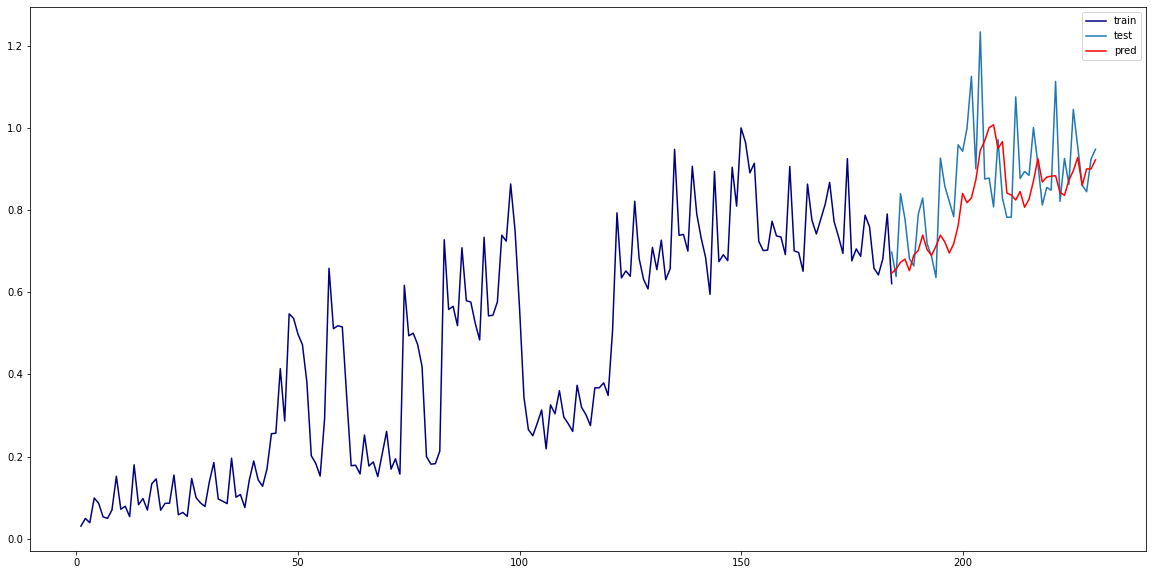

In [359]:
plt.plot(range(1,train_y_weekly.shape[0]+1),train_y_weekly, label = 'train', color = 'navy')
plt.plot(range(train_y_weekly.shape[0],(train_y_weekly.shape[0] + y_pred_weekly.shape[0])),test_y_weekly, label = 'test')
plt.plot(range(train_y_weekly.shape[0],(train_y_weekly.shape[0] + y_pred_weekly.shape[0])),y_pred_weekly, label = 'pred', color = 'red')
plt.legend()
plt.show()

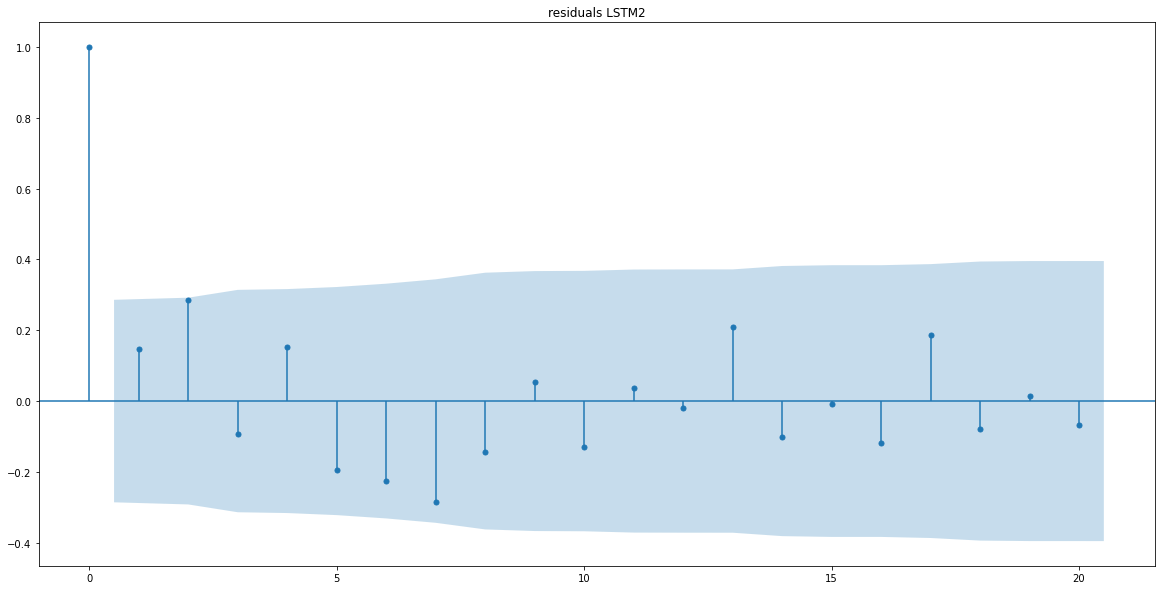

In [360]:
# and let's check if our residuals are white noise
y_err_weekly = test_y_weekly - y_pred_weekly

sgt.plot_acf(y_err_weekly, lags = 20)
plt.title('residuals LSTM2')
plt.show()

In [361]:
print('R2 score train is: ', round(r2_score(train_y_weekly, y_pred_train_weekly),3))
print('R2 score test is: ', round(r2_score(test_y_weekly, y_pred_weekly),3))

R2 score train is:  0.713
R2 score test is:  0.101


Our LSTM model again isn't very precise

In [ ]:
#date_range = pd.date_range(test.index[-1], periods = 365)

In [ ]:
# model_auto1 = SARIMAX(df.sales,order = (3,1,2), seasonal_order=(4, 0, 4, 30), trend = 'ct').fit()
# auto_pred1 = pd.DataFrame({
#     'index' : date_range,
#     'result': model_auto1.predict(start = date_range[0], end = date_range[-1])
#                          }).set_index('index')

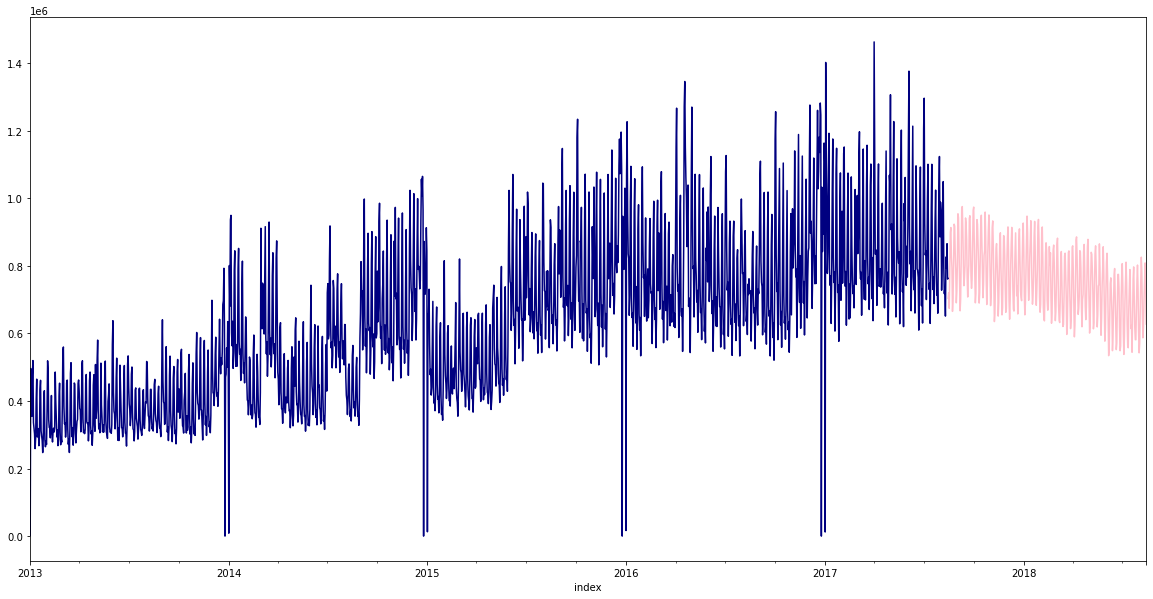

In [ ]:
# #and plot the results
# #test['sales'].plot()
# df.sales.plot(color= 'navy')
# auto_pred1['result'].plot(color = 'pink')

# plt.show()

**10. Summary**

- Our best daily model was prophet multiplicative version.  
we reached 0.672 r2 score on test set. 

In [383]:
#So let's save our model
import json
from fbprophet.serialize import model_to_json

with open("./models/best_daily_model.json", 'w') as fout:
    json.dump(model_to_json(prophet_model_multi), fout)    

- Our best weekly model was SARIMAX(2,0,0)(0,0,1)[5] model with exogeous variables

In [435]:
import pickle
with open('./models/best_weekly_model.pkl', 'wb') as pkl:
    pickle.dump(model_auto_weekly, pkl)